## Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import List
import torch
import torchvision
from tqdm import tqdm
np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

## Load Dataset

In [2]:
cifar_10_data = torchvision.datasets.CIFAR10(root='cifar-10-python/')
cifar_10_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar-10-python/
    Split: Train

(32, 32, 3)


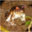

In [3]:
temp_img = cifar_10_data[0][0]
print(np.asarray(temp_img).shape)
temp_img

In [4]:
print(f"Label of the image: {cifar_10_data[0][1]}")

Label of the image: 6


## 1. Numpy Implementation of CNN

### 1.1 Convolution Function

In [5]:
def convolve(image, kernel, stride, padding, activation_fn):
    """
    Convolve the image with the given kernel using the specified stride and padding.
    Apply the activation function to the convolved image.
    """
    w, h, c = image.shape
    kw, kh, kc = kernel.shape

    assert kc == c, "Number of channels in kernel and image should match"

    output_dim_w = (w - kw + 2 * padding) // stride + 1 # Width of the output image
    output_dim_h = (h - kh + 2 * padding) // stride + 1 # Height of the output image

    output = np.zeros((output_dim_w, output_dim_h))

    # Apply padding to the image
    image_padded = np.zeros((w + 2 * padding, h + 2 * padding, c))
    
    if padding != 0:
        image_padded[padding:-padding, padding:-padding, :] = image
    else:
        image_padded = image

    for i in range(0, output_dim_w):
        for j in range(0, output_dim_h):
            w_start = i * stride; w_end = w_start + kw
            h_start = j * stride; h_end = h_start + kh
            output[i, j] = np.sum(image_padded[w_start:w_end, h_start:h_end, :] * kernel)
    
    # Apply the activation
    output = activation_fn(output)
    return output

### 1.2 Pooling function

In [6]:
def pool(activation_map, pool_size_w, pool_size_h, pooling_fn, stride):
    """
    Apply pooling operation to the activation map.
    """
    w, h = activation_map.shape
    output_dim_w = (w - pool_size_w) // stride + 1
    output_dim_h = (h - pool_size_h) // stride + 1

    output = np.zeros((output_dim_w, output_dim_h))

    for i in range(0, output_dim_w):
        for j in range(0, output_dim_h):
            w_start = i * stride; w_end = w_start + pool_size_w
            h_start = j * stride; h_end = h_start + pool_size_h
            output[i, j] = pooling_fn(activation_map[w_start:w_end, h_start:h_end])
    return output

### 1.3 Convolution layer function

In [7]:
def conv_layer(image, kernels, stride, padding, activation_fn, plot = False):
    """
    Conv layer with multiple kernels.
    """
    temp_output = []
    # Create a subplot to plot the image, the kernel and the convolved image
    num_kernels = len(kernels)
    if plot:
        fig, axs = plt.subplots(num_kernels, 3, figsize=(10, 10))
    for i in range(num_kernels):
        kernel = kernels[i]
        convolved_image = convolve(image, kernel, stride, padding, activation_fn)
        temp_output.append(convolved_image)
        if plot:
            axs[i, 0].imshow(image)
            axs[i, 0].set_title("Image")
            axs[i, 1].imshow(kernel)
            axs[i, 1].set_title("Kernel")
            axs[i, 2].imshow(convolved_image)
            axs[i, 2].set_title("Convolved Image")
    if plot:
        plt.tight_layout()
        plt.show()
    temp_output = np.array(temp_output)
    output = np.zeros((temp_output.shape[1], temp_output.shape[2], temp_output.shape[0]))
    for i in range(temp_output.shape[0]):
        output[:, :, i] = temp_output[i]
    return output

### 1.4 Pooling Layer function

In [8]:
def pool_layer(activation_map_volume, pool_size_w, pool_size_h, pooling_fn, stride,
               plot = False):
    """
    Pool layer
    """
    temp_output = []
    num_activation_maps = activation_map_volume.shape[2]
    if plot:
        fig, axs = plt.subplots(num_activation_maps, 2, figsize=(10, 10))
    for i in range(num_activation_maps):
        activation_map = activation_map_volume[:, :, i]
        pooled_output = pool(activation_map, pool_size_w, pool_size_h, pooling_fn, stride)
        temp_output.append(pooled_output)
        if plot:
            axs[i, 0].imshow(activation_map)
            axs[i, 0].set_title("Activation Map")
            axs[i, 1].imshow(pooled_output)
            axs[i, 1].set_title("Pooled Output")
    if plot:
        plt.tight_layout()
        plt.show()
        
    temp_output = np.array(temp_output)

    output = np.zeros((temp_output.shape[1], temp_output.shape[2], temp_output.shape[0]))
    for i in range(temp_output.shape[0]):
        output[:, :, i] = temp_output[i]
    return output

### 1.5 Flattening (Unraveling) function

In [9]:
def flatten(activation_map_volume, weight_matrix):
    """
    Outputs `weight_matrix` @ `activation_map_volume`(flattened).
    """
    flattened = activation_map_volume.flatten()
    return weight_matrix @ flattened

### 1.6 MLP layer

In [10]:
def mlp_layer(vec, n_hidden, sizes_hidden, n_output, activation_fn):
    """
    MLP layer, takes a vector as input and outputs a vector.
    """
    x = vec
    for i in range(n_hidden):
        w = np.random.normal(size=(sizes_hidden[i], x.shape[0]), scale = 0.1)
        b = np.random.normal(size=(sizes_hidden[i],), scale = 0.1)
        x = activation_fn(w @ x + b)
    w = np.random.normal(size=(n_output, x.shape[0]), scale = 0.1)
    b = np.random.normal(size=(n_output, ), scale = 0.1)
    x = w @ x + b
    # Apply softmax
    y = np.exp(x) / np.sum(np.exp(x))
    return x, y

### 1.7 Forward Propagation

In [11]:
class CNN:
    def __init__(self):
        # ReLU activation function
        self.relu = lambda x: np.maximum(0, x)
        # Max function
        self.max_fn = lambda x: np.max(x)

        self.conv1_kernels = np.random.normal(size = (4, 5, 5, 3), scale = 0.1)
        self.conv1_stride = 1
        self.conv1_padding = (5 - 1) // 2 # Same padding

        self.pool1_size_w = 2; self.pool1_size_h = 2
        self.pool1_stride = 2

        self.conv2_kernels = np.random.normal(size = (4, 5, 5, 4), scale = 0.1)
        self.conv2_stride = 1
        self.conv2_padding = (5 - 1) // 2 # Same padding

        self.pool2_size_w = 2; self.pool2_size_h = 2
        self.pool2_stride = 2

        self.mlp_n_hidden = 1
        self.mlp_sizes_hidden = [49]
        self.mlp_n_output = 10

    def forward(self, image, verbose = False, plot = False):

        if verbose:
            print("Convolution Layer 1:")
            print(f"\tInput shape: {image.shape}")

        conv1_output = conv_layer(image, self.conv1_kernels, self.conv1_stride,
                                  self.conv1_padding, self.relu, plot)
        
        if verbose:
            print(f"\tOutput shape: {conv1_output.shape}\n")

            print("Pooling Layer 1:")
            print(f"\tInput shape: {conv1_output.shape}")

        pool1_output = pool_layer(conv1_output, self.pool1_size_w, self.pool1_size_h,
                                  self.max_fn, self.pool1_stride, plot)
        if verbose:
            print(f"\tOutput shape: {pool1_output.shape}\n")

            print("Convolution Layer 2:")
            print(f"\tInput shape: {pool1_output.shape}")

        conv2_output = conv_layer(pool1_output, self.conv2_kernels, self.conv2_stride,
                                  self.conv2_padding, self.relu, plot)
        if verbose:
            print(f"\tOutput shape: {conv2_output.shape}\n")

            print("Pooling Layer 2:")
            print(f"\tInput shape: {conv2_output.shape}")

        pool2_output = pool_layer(conv2_output, self.pool2_size_w, self.pool2_size_h,
                                  self.max_fn, self.pool2_stride, plot)
        if verbose:
            print(f"\tOutput shape: {pool2_output.shape}\n")

            print("Flatten Layer:")
            print(f"\tInput shape: {pool2_output.shape}")

        flattened = flatten(pool2_output, np.eye(pool2_output.size))
        if verbose:
            print(f"\tOutput shape: {flattened.shape}\n")

            print("MLP Layer:")
            print(f"\tInput shape: {flattened.shape}")

        _, output = mlp_layer(flattened, self.mlp_n_hidden, self.mlp_sizes_hidden,
                              self.mlp_n_output, self.relu)
        if verbose:
            print(f"\tOutput shape: {output.shape}\n")
            
        return output

In [12]:
cnn_model = CNN()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26197451040897446..0.18522781845089378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1987568914600893..0.24632421124852863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18672651925917483..0.38527314906547216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3241267340069073..0.2143944089325326].


Convolution Layer 1:
	Input shape: (32, 32, 3)


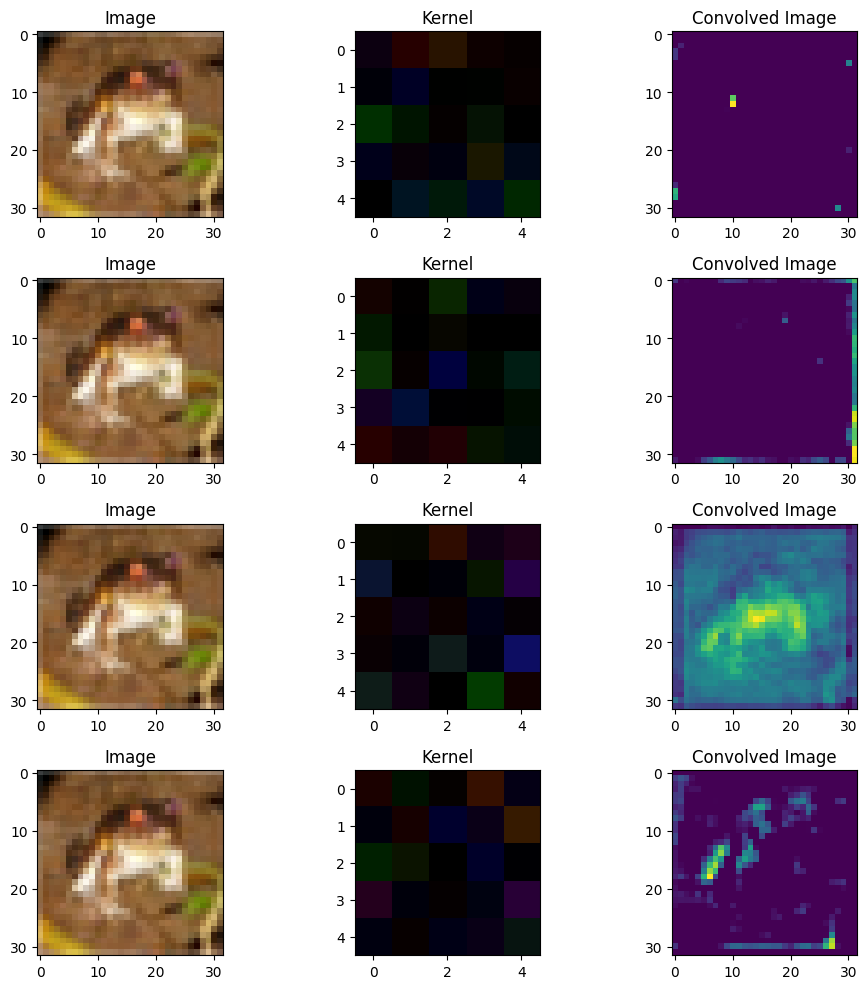

	Output shape: (32, 32, 4)

Pooling Layer 1:
	Input shape: (32, 32, 4)


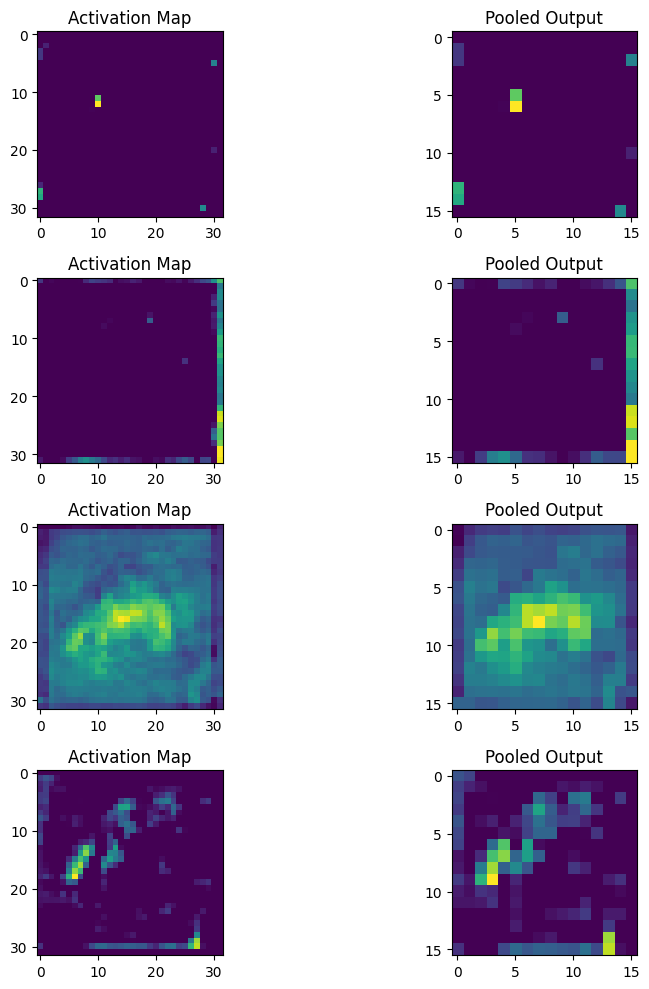

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0592152042985934].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2123895724309807..0.21898029332176724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0592152042985934].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2301921164735585..0.30788808084552377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0592152042985934].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24716445001272894..0.2270692857804396].
Clipping input data to the valid range for imshow with RGB data ([0

	Output shape: (16, 16, 4)

Convolution Layer 2:
	Input shape: (16, 16, 4)


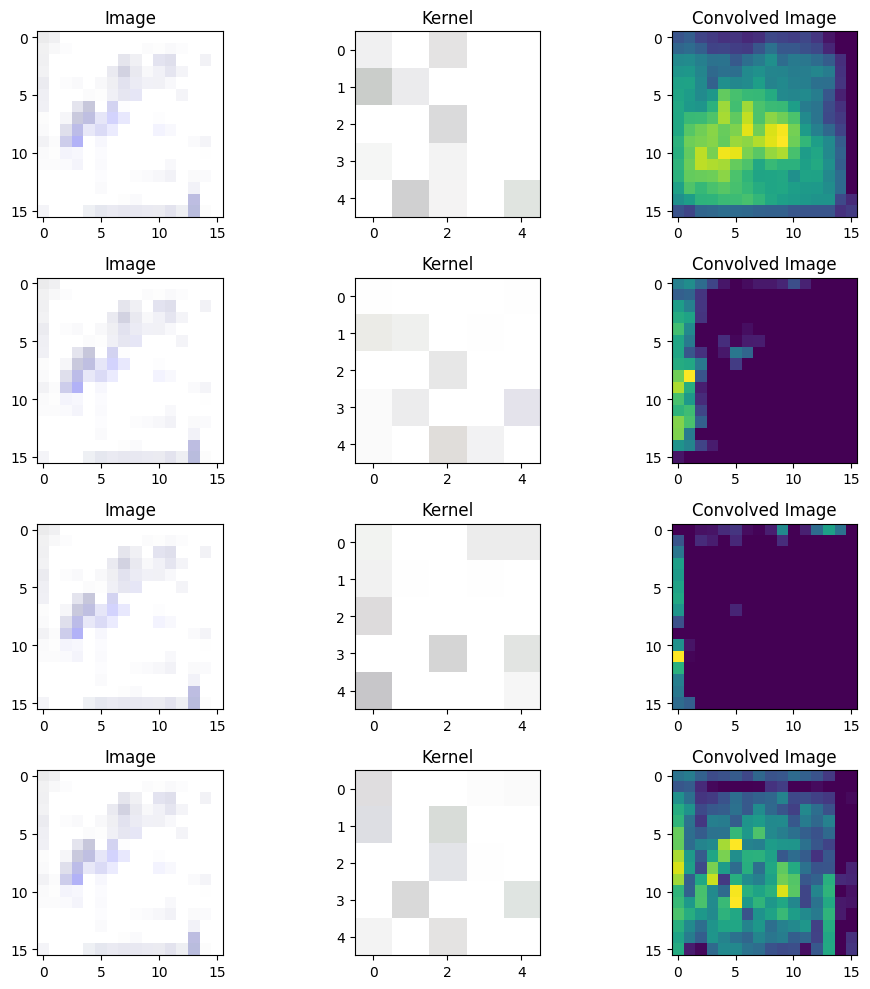

	Output shape: (16, 16, 4)

Pooling Layer 2:
	Input shape: (16, 16, 4)


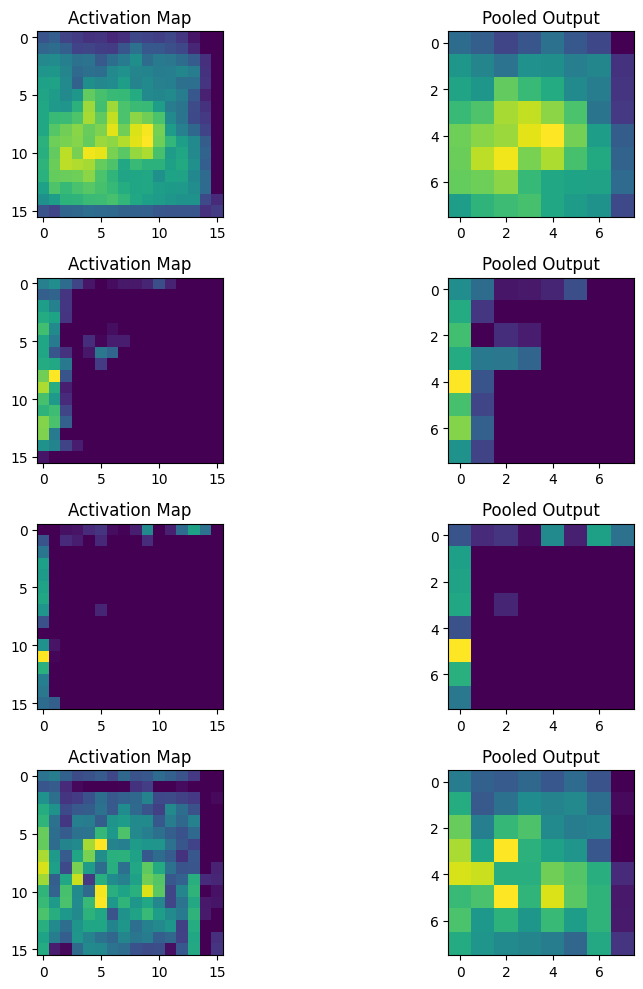

	Output shape: (8, 8, 4)

Flatten Layer:
	Input shape: (8, 8, 4)
	Output shape: (256,)

MLP Layer:
	Input shape: (256,)
	Output shape: (10,)



array([0.10983455, 0.09593677, 0.09997766, 0.08738314, 0.09639929,
       0.0969602 , 0.11475286, 0.08455001, 0.13075296, 0.08345257])

In [13]:
# Verify the forward pass
# Divide by 255 to normalize the image
temp_img = np.asarray(temp_img) / 255
cnn_model.forward(temp_img, verbose = True, plot = True)

### 1.8.a Forward pass for one image of each class

In [14]:
# Choose one image from each class
label_to_img = dict()
for i in range(len(cifar_10_data)):
    img, label = cifar_10_data[i]
    if label not in label_to_img:
        label_to_img[label] = np.asarray(img)

        if len(label_to_img) == 10:
            break

In [15]:
outputs = dict()
for label, img in label_to_img.items():
    outputs[label] = cnn_model.forward(img)
    print(f"Label: {label}, Output: {outputs[label]}")

Label: 6, Output: [1.00264892e-33 4.56357713e-52 1.00000000e+00 2.10018710e-37
 1.02619042e-55 5.30956748e-43 4.50727180e-48 1.13231851e-16
 1.40189116e-32 4.05346310e-38]
Label: 9, Output: [9.47695804e-90 1.06308073e-92 5.09610972e-83 1.00000000e+00
 1.83677116e-74 2.31913391e-47 1.06638662e-28 4.50272920e-11
 5.93004547e-97 4.90689460e-13]
Label: 4, Output: [3.24670995e-08 9.58764847e-01 9.09383719e-16 2.44828672e-28
 1.43708898e-21 4.01138921e-45 1.29672477e-31 4.12351202e-02
 4.52084823e-31 1.29536166e-20]
Label: 1, Output: [3.03423469e-25 4.72831299e-03 1.09631269e-24 7.31419537e-63
 7.23787479e-18 9.95271686e-01 8.92396545e-20 2.30245423e-29
 3.07646923e-38 5.50859170e-10]
Label: 2, Output: [1.22893901e-36 4.23201439e-33 1.26334323e-19 1.00000000e+00
 1.16365435e-25 1.37853036e-63 1.99294189e-37 3.58226935e-40
 9.16634279e-31 1.35066580e-24]
Label: 7, Output: [1.46735048e-26 1.00000000e+00 3.10575063e-59 8.99520931e-50
 1.76683420e-82 3.82799538e-19 3.56227305e-41 2.68251762e-21


**Question:** Do you see any trend in the output vectors?<br><br>
**Answer:** Yes, we can see that the output vectors are sparse i.e. most of the values are close to zero and only one value is close to 1. Therefore, we can say that the model is trying to learn the features of the images and is trying to predict the correct class. Although, the model is not perfect, it will required training to learn the same.

### 1.8.b Forward pass for 3 images from each class, t-SNE plots

In [16]:
# Choose three images from each class
label_to_imgs = dict()

for i in range(len(cifar_10_data)):
    img, label = cifar_10_data[i]
    if label not in label_to_imgs:
        label_to_imgs[label] = [np.asarray(img)]
    else:
        if len(label_to_imgs[label]) < 3:
            label_to_imgs[label].append(np.asarray(img))

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)

# Get the outputs for all the images
outputs = dict()
X = []

for label, imgs in label_to_imgs.items():
    outputs[label] = []
    for img in imgs:
        outputs[label].append(cnn_model.forward(img))

    outputs[label] = np.array(outputs[label])
    X.append(outputs[label])

X = np.concatenate(X, axis=0)
X_embedded = tsne.fit_transform(X)
print(X_embedded.shape)

(30, 2)


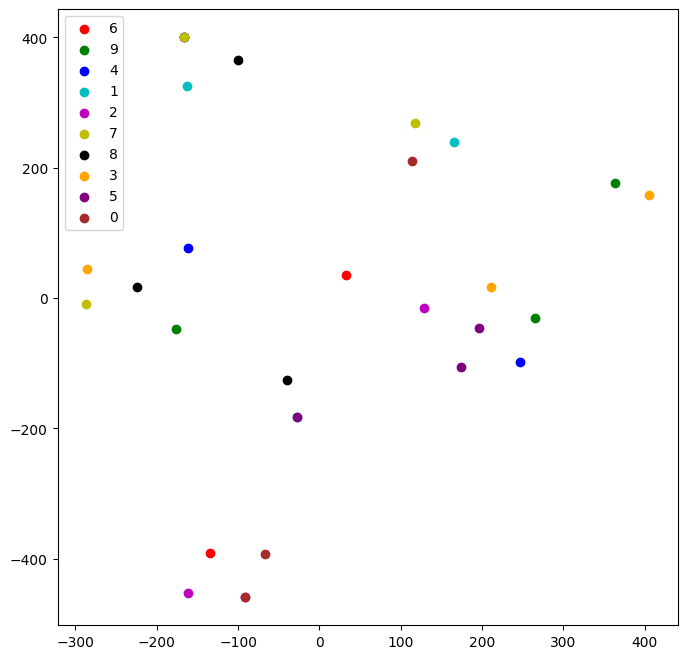

In [18]:
# Plot the t-SNE embeddings
plt.figure(figsize=(8, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for i, (label, imgs) in enumerate(label_to_imgs.items()):
    start = i * 3
    end = start + 3
    plt.scatter(X_embedded[start:end, 0], X_embedded[start:end, 1], c=colors[i], label=label)
plt.legend()
plt.show()

**Question:** Does a randomly initialized network show any discriminability?<br><br>
**Answer:** We can see that the randomly initialized network does not show discriminability in a consistent manner. The t-SNE plots for the images of the same class are clustered together for some classes but not for all. This is because the model is randomly initialized and has not learned the features of the images. Therefore, the model is not able to predict the correct class for the images.

## 2. Pytorch Implementation

### 2.1

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class CNN_Torch(nn.Module):
    def __init__(self):
        super(CNN_Torch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=4 * 8 * 8, out_features=49)
        self.fc2 = nn.Linear(in_features=49, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 4 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

### 2.2

In [21]:
from torch.utils.data import DataLoader, Subset

cifar_10_data_tensor = torchvision.datasets.CIFAR10(root='cifar-10-python/',
                                             transform = torchvision.transforms.ToTensor())
# All the images are converted to tensors with each value in range [0, 1]

train_per_class = 100
test_per_class = 10

# Get indices for the train and test split
train_indices = []
test_indices = []
class_counts = {i: 0 for i in range(10)}

for idx, (image, label) in enumerate(cifar_10_data):
    if class_counts[label] < train_per_class:
        train_indices.append(idx)
        class_counts[label] += 1
    elif class_counts[label] < train_per_class + test_per_class:
        test_indices.append(idx)
        class_counts[label] += 1

train_data = Subset(cifar_10_data_tensor, train_indices)
test_data = Subset(cifar_10_data_tensor, test_indices)

print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")

Number of training examples: 1000
Number of test examples: 100


In [22]:
loss_fn = nn.CrossEntropyLoss()

In [23]:
def train_cnn(optimizer, model, num_epochs = 15, batch_size = 100):
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_errors = []
    test_errors = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Train step
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, dim = 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_errors.append(train_loss / len(train_loader))
        train_accuracies.append(100.0 * correct / total)

        # Test accuracy and error
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, dim = 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_errors.append(test_loss / len(test_loader))
        test_accuracies.append(100.0 * correct / total)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_errors[-1]:.4f}, Test Loss: {test_errors[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%")

        # Shuffle the training data
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    return train_errors, test_errors, train_accuracies, test_accuracies

In [24]:
def plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_errors, label='Train')
    plt.plot(test_errors, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Number of epochs are kept constant at $200$ for all the problems. This is to compare the performances in different situations.

#### 2.2.a) Vanilla SGD

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 41.01it/s]


Epoch 1/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 45.10it/s]


Epoch 2/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 51.92it/s]


Epoch 3/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 47.65it/s]


Epoch 4/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 59.83it/s]


Epoch 5/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 47.30it/s]


Epoch 6/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 48.32it/s]


Epoch 7/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 46.69it/s]


Epoch 8/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 50.64it/s]


Epoch 9/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 44.12it/s]


Epoch 10/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 43.31it/s]


Epoch 11/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 40.96it/s]


Epoch 12/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 48.85it/s]


Epoch 13/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 58.09it/s]


Epoch 14/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 54.94it/s]


Epoch 15/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 44.19it/s]


Epoch 16/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 49.41it/s]


Epoch 17/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 49.24it/s]


Epoch 18/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 47.87it/s]


Epoch 19/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 48.36it/s]


Epoch 20/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 46.17it/s]


Epoch 21/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 52.34it/s]


Epoch 22/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 47.51it/s]


Epoch 23/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 39.89it/s]


Epoch 24/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 52.93it/s]


Epoch 25/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 44.21it/s]


Epoch 26/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 50.43it/s]


Epoch 27/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 49.67it/s]


Epoch 28/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 44.55it/s]


Epoch 29/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 47.22it/s]


Epoch 30/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 53.79it/s]


Epoch 31/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 51.90it/s]


Epoch 32/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 52.34it/s]


Epoch 33/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 51.37it/s]


Epoch 34/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 55.60it/s]


Epoch 35/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 42.04it/s]


Epoch 36/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 46.46it/s]


Epoch 37/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 45.34it/s]


Epoch 38/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 49.08it/s]


Epoch 39/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 42.43it/s]


Epoch 40/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 47.87it/s]


Epoch 41/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 47.34it/s]


Epoch 42/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 51.07it/s]


Epoch 43/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 53.75it/s]


Epoch 44/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 45.18it/s]


Epoch 45/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 41.59it/s]


Epoch 46/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 41.26it/s]


Epoch 47/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 50.16it/s]


Epoch 48/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 44.11it/s]


Epoch 49/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 49.97it/s]


Epoch 50/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 50.46it/s]


Epoch 51/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 31.61it/s]


Epoch 52/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 43.68it/s]


Epoch 53/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 48.39it/s]


Epoch 54/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 49.55it/s]


Epoch 55/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 47.42it/s]


Epoch 56/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 53.80it/s]


Epoch 57/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 44.97it/s]


Epoch 58/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 55.30it/s]


Epoch 59/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 44.55it/s]


Epoch 60/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 41.44it/s]


Epoch 61/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 50.26it/s]


Epoch 62/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 44.78it/s]


Epoch 63/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 45.57it/s]


Epoch 64/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 41.47it/s]


Epoch 65/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 44.71it/s]


Epoch 66/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 44.30it/s]


Epoch 67/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 44.40it/s]


Epoch 68/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 52.07it/s]


Epoch 69/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 40.70it/s]


Epoch 70/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 46.48it/s]


Epoch 71/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 45.61it/s]


Epoch 72/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 41.94it/s]


Epoch 73/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 43.68it/s]


Epoch 74/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 45.28it/s]


Epoch 75/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 49.78it/s]


Epoch 76/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 44.70it/s]


Epoch 77/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 49.85it/s]


Epoch 78/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 33.14it/s]


Epoch 79/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 54.89it/s]


Epoch 80/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 52.26it/s]


Epoch 81/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 44.27it/s]


Epoch 82/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 49.64it/s]


Epoch 83/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 52.28it/s]


Epoch 84/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 45.55it/s]


Epoch 85/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 45.96it/s]


Epoch 86/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 49.79it/s]


Epoch 87/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 46.87it/s]


Epoch 88/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 46.72it/s]


Epoch 89/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 49.97it/s]


Epoch 90/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 45.89it/s]


Epoch 91/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 44.47it/s]


Epoch 92/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 44.75it/s]


Epoch 93/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 45.33it/s]


Epoch 94/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 48.88it/s]


Epoch 95/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 48.71it/s]


Epoch 96/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 42.25it/s]


Epoch 97/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 45.89it/s]


Epoch 98/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 42.41it/s]


Epoch 99/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 44.24it/s]


Epoch 100/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 49.06it/s]


Epoch 101/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 43.05it/s]


Epoch 102/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 45.59it/s]


Epoch 103/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 34.05it/s]


Epoch 104/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 46.33it/s]


Epoch 105/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 49.45it/s]


Epoch 106/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 45.16it/s]


Epoch 107/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 46.27it/s]


Epoch 108/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 43.39it/s]


Epoch 109/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 41.92it/s]


Epoch 110/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 40.13it/s]


Epoch 111/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 42.05it/s]


Epoch 112/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 43.31it/s]


Epoch 113/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 45.58it/s]


Epoch 114/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 42.77it/s]


Epoch 115/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 43.64it/s]


Epoch 116/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 45.67it/s]


Epoch 117/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 48.93it/s]


Epoch 118/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 46.65it/s]


Epoch 119/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 50.62it/s]


Epoch 120/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 44.66it/s]


Epoch 121/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 46.03it/s]


Epoch 122/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 48.02it/s]


Epoch 123/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 44.85it/s]


Epoch 124/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 42.23it/s]


Epoch 125/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 42.14it/s]


Epoch 126/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 47.85it/s]


Epoch 127/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 52.24it/s]


Epoch 128/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 51.72it/s]


Epoch 129/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 44.39it/s]


Epoch 130/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 47.12it/s]


Epoch 131/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 43.71it/s]


Epoch 132/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 46.02it/s]


Epoch 133/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 48.56it/s]


Epoch 134/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 51.65it/s]


Epoch 135/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 51.57it/s]


Epoch 136/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 51.05it/s]


Epoch 137/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 49.10it/s]


Epoch 138/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 34.48it/s]


Epoch 139/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 47.30it/s]


Epoch 140/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 46.48it/s]


Epoch 141/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 43.25it/s]


Epoch 142/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 44.26it/s]


Epoch 143/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 45.44it/s]


Epoch 144/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 47.63it/s]


Epoch 145/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 44.16it/s]


Epoch 146/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 48.01it/s]


Epoch 147/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 45.78it/s]


Epoch 148/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 45.99it/s]


Epoch 149/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 48.78it/s]


Epoch 150/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 44.34it/s]


Epoch 151/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 47.20it/s]


Epoch 152/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 45.18it/s]


Epoch 153/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 39.93it/s]


Epoch 154/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 44.36it/s]


Epoch 155/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 37.73it/s]


Epoch 156/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 42.38it/s]


Epoch 157/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 41.34it/s]


Epoch 158/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 45.18it/s]


Epoch 159/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 46.72it/s]


Epoch 160/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 44.75it/s]


Epoch 161/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 52.37it/s]


Epoch 162/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 50.67it/s]


Epoch 163/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 45.08it/s]


Epoch 164/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 48.87it/s]


Epoch 165/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 52.54it/s]


Epoch 166/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 42.95it/s]


Epoch 167/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 47.98it/s]


Epoch 168/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 41.58it/s]


Epoch 169/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 45.38it/s]


Epoch 170/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 43.24it/s]


Epoch 171/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 44.93it/s]


Epoch 172/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 40.59it/s]


Epoch 173/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 42.61it/s]


Epoch 174/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 38.74it/s]


Epoch 175/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 39.06it/s]


Epoch 176/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 42.11it/s]


Epoch 177/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 37.88it/s]


Epoch 178/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 38.51it/s]


Epoch 179/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 29.90it/s]


Epoch 180/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 28.21it/s]


Epoch 181/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 25.09it/s]


Epoch 182/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 25.44it/s]


Epoch 183/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 33.87it/s]


Epoch 184/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 35.73it/s]


Epoch 185/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 37.45it/s]


Epoch 186/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 27.53it/s]


Epoch 187/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 32.69it/s]


Epoch 188/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 32.47it/s]


Epoch 189/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 32.48it/s]


Epoch 190/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 29.44it/s]


Epoch 191/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 30.00it/s]


Epoch 192/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 31.00it/s]


Epoch 193/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 31.86it/s]


Epoch 194/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 30.75it/s]


Epoch 195/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 31.89it/s]


Epoch 196/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 38.20it/s]


Epoch 197/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 41.78it/s]


Epoch 198/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 42.44it/s]


Epoch 199/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 41.93it/s]


Epoch 200/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


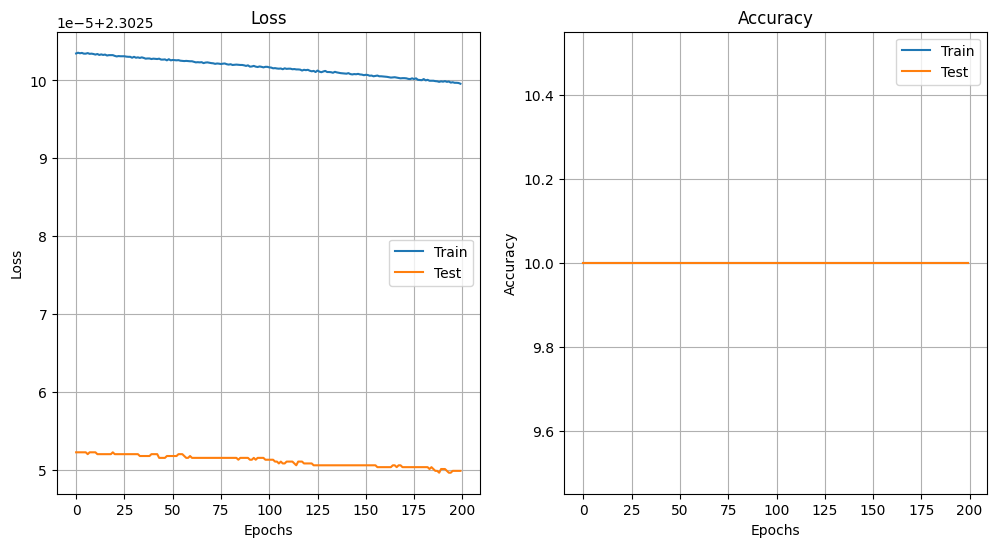

In [25]:
cnn_vanilla_sgd = CNN_Torch()
vanilla_sgd = torch.optim.SGD(cnn_vanilla_sgd.parameters(), lr=0.001)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(vanilla_sgd,
                                                                         cnn_vanilla_sgd,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

| **Train Accuracy** | **Test Accuracy** |
|--------------------|-------------------|
| 10.00%             | 10.00%            |

**Note:** Since it is a deep neural network, vanilla SGD is not able to update the weights properly and the model is not able to learn.

#### 2.2.b) SGD with momentum

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 33.77it/s]


Epoch 1/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 44.73it/s]


Epoch 2/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 44.58it/s]


Epoch 3/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 38.38it/s]


Epoch 4/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 40.66it/s]


Epoch 5/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 45.06it/s]


Epoch 6/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 39.35it/s]


Epoch 7/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 40.78it/s]


Epoch 8/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 49.04it/s]


Epoch 9/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 38.59it/s]


Epoch 10/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 44.83it/s]


Epoch 11/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 45.47it/s]


Epoch 12/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 43.40it/s]


Epoch 13/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 43.86it/s]


Epoch 14/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 46.67it/s]


Epoch 15/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 54.95it/s]


Epoch 16/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 40.05it/s]


Epoch 17/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 43.39it/s]


Epoch 18/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 44.28it/s]


Epoch 19/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 40.55it/s]


Epoch 20/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 37.40it/s]


Epoch 21/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 39.85it/s]


Epoch 22/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 39.97it/s]


Epoch 23/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 42.13it/s]


Epoch 24/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 41.79it/s]


Epoch 25/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 37.89it/s]


Epoch 26/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 44.90it/s]


Epoch 27/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 43.03it/s]


Epoch 28/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 42.25it/s]


Epoch 29/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 44.43it/s]


Epoch 30/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 36.28it/s]


Epoch 31/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 40.76it/s]


Epoch 32/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 42.15it/s]


Epoch 33/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 41.91it/s]


Epoch 34/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 45.05it/s]


Epoch 35/200, Train Loss: 2.3026, Test Loss: 2.3026, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 41.08it/s]


Epoch 36/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 36.94it/s]


Epoch 37/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 39.52it/s]


Epoch 38/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 39.80it/s]


Epoch 39/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 44.64it/s]


Epoch 40/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 43.06it/s]


Epoch 41/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 34.77it/s]


Epoch 42/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 42.35it/s]


Epoch 43/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 43.70it/s]


Epoch 44/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 48.39it/s]


Epoch 45/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 41.61it/s]


Epoch 46/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 47.00it/s]


Epoch 47/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 38.69it/s]


Epoch 48/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 43.13it/s]


Epoch 49/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 41.94it/s]


Epoch 50/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 36.42it/s]


Epoch 51/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 36.61it/s]


Epoch 52/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 53/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 39.60it/s]


Epoch 54/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 43.89it/s]


Epoch 55/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 42.73it/s]


Epoch 56/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 36.05it/s]


Epoch 57/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 41.82it/s]


Epoch 58/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 48.87it/s]


Epoch 59/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 41.69it/s]


Epoch 60/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 47.50it/s]


Epoch 61/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 44.74it/s]


Epoch 62/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 44.81it/s]


Epoch 63/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 42.84it/s]


Epoch 64/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 43.40it/s]


Epoch 65/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 47.79it/s]


Epoch 66/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 43.60it/s]


Epoch 67/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 42.63it/s]


Epoch 68/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 45.93it/s]


Epoch 69/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 42.18it/s]


Epoch 70/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 44.41it/s]


Epoch 71/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 42.97it/s]


Epoch 72/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 43.55it/s]


Epoch 73/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 39.70it/s]


Epoch 74/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 39.07it/s]


Epoch 75/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 38.78it/s]


Epoch 76/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 37.82it/s]


Epoch 77/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 40.27it/s]


Epoch 78/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 37.64it/s]


Epoch 79/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 32.37it/s]


Epoch 80/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 38.91it/s]


Epoch 81/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 41.64it/s]


Epoch 82/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 36.11it/s]


Epoch 83/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 26.34it/s]


Epoch 84/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 33.25it/s]


Epoch 85/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 31.44it/s]


Epoch 86/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 34.75it/s]


Epoch 87/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 37.28it/s]


Epoch 88/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 38.09it/s]


Epoch 89/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 37.02it/s]


Epoch 90/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 36.37it/s]


Epoch 91/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 39.60it/s]


Epoch 92/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 40.90it/s]


Epoch 93/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 35.33it/s]


Epoch 94/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 37.33it/s]


Epoch 95/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 35.72it/s]


Epoch 96/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 35.36it/s]


Epoch 97/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 36.10it/s]


Epoch 98/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 36.75it/s]


Epoch 99/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 37.83it/s]


Epoch 100/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 37.44it/s]


Epoch 101/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 39.91it/s]


Epoch 102/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 38.96it/s]


Epoch 103/200, Train Loss: 2.3026, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 39.47it/s]


Epoch 104/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 39.03it/s]


Epoch 105/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 34.28it/s]


Epoch 106/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 38.55it/s]


Epoch 107/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 42.36it/s]


Epoch 108/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 38.47it/s]


Epoch 109/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 42.02it/s]


Epoch 110/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 41.34it/s]


Epoch 111/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 41.94it/s]


Epoch 112/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 39.29it/s]


Epoch 113/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 40.92it/s]


Epoch 114/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 39.95it/s]


Epoch 115/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 31.91it/s]


Epoch 116/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 38.64it/s]


Epoch 117/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 41.09it/s]


Epoch 118/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 42.97it/s]


Epoch 119/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 39.68it/s]


Epoch 120/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 44.91it/s]


Epoch 121/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 40.13it/s]


Epoch 122/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 38.61it/s]


Epoch 123/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 44.54it/s]


Epoch 124/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 39.12it/s]


Epoch 125/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 40.29it/s]


Epoch 126/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 34.32it/s]


Epoch 127/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 40.16it/s]


Epoch 128/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 39.53it/s]


Epoch 129/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 33.21it/s]


Epoch 130/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 37.68it/s]


Epoch 131/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 40.79it/s]


Epoch 132/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 36.50it/s]


Epoch 133/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 38.97it/s]


Epoch 134/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 36.45it/s]


Epoch 135/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 39.42it/s]


Epoch 136/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 37.43it/s]


Epoch 137/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 35.94it/s]


Epoch 138/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 39.27it/s]


Epoch 139/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 41.52it/s]


Epoch 140/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 39.42it/s]


Epoch 141/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 28.32it/s]


Epoch 142/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 35.83it/s]


Epoch 143/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 34.94it/s]


Epoch 144/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 35.42it/s]


Epoch 145/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 42.06it/s]


Epoch 146/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 37.82it/s]


Epoch 147/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 39.09it/s]


Epoch 148/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 35.62it/s]


Epoch 149/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 34.85it/s]


Epoch 150/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 41.54it/s]


Epoch 151/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 35.96it/s]


Epoch 152/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 33.93it/s]


Epoch 153/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 32.88it/s]


Epoch 154/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 28.65it/s]


Epoch 155/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 31.68it/s]


Epoch 156/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 31.15it/s]


Epoch 157/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 34.03it/s]


Epoch 158/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 32.79it/s]


Epoch 159/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 37.34it/s]


Epoch 160/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 28.59it/s]


Epoch 161/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 36.85it/s]


Epoch 162/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 34.29it/s]


Epoch 163/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 34.76it/s]


Epoch 164/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 37.30it/s]


Epoch 165/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 48.21it/s]


Epoch 166/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 35.76it/s]


Epoch 167/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 36.37it/s]


Epoch 168/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 36.08it/s]


Epoch 169/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 31.56it/s]


Epoch 170/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 34.38it/s]


Epoch 171/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 36.63it/s]


Epoch 172/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 35.14it/s]


Epoch 173/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 34.12it/s]


Epoch 174/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 34.32it/s]


Epoch 175/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 35.19it/s]


Epoch 176/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 34.43it/s]


Epoch 177/200, Train Loss: 2.3025, Test Loss: 2.3025, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 27.77it/s]


Epoch 178/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 30.82it/s]


Epoch 179/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 32.82it/s]


Epoch 180/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 34.44it/s]


Epoch 181/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 29.40it/s]


Epoch 182/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 29.57it/s]


Epoch 183/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 29.44it/s]


Epoch 184/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 31.72it/s]


Epoch 185/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 33.08it/s]


Epoch 186/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 25.35it/s]


Epoch 187/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 31.61it/s]


Epoch 188/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 33.11it/s]


Epoch 189/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 32.13it/s]


Epoch 190/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 33.06it/s]


Epoch 191/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 33.51it/s]


Epoch 192/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 30.65it/s]


Epoch 193/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 30.90it/s]


Epoch 194/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 33.77it/s]


Epoch 195/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 32.72it/s]


Epoch 196/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 29.70it/s]


Epoch 197/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 31.42it/s]


Epoch 198/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 32.06it/s]


Epoch 199/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 34.28it/s]


Epoch 200/200, Train Loss: 2.3025, Test Loss: 2.3024, Train Accuracy: 10.00%, Test Accuracy: 10.00%


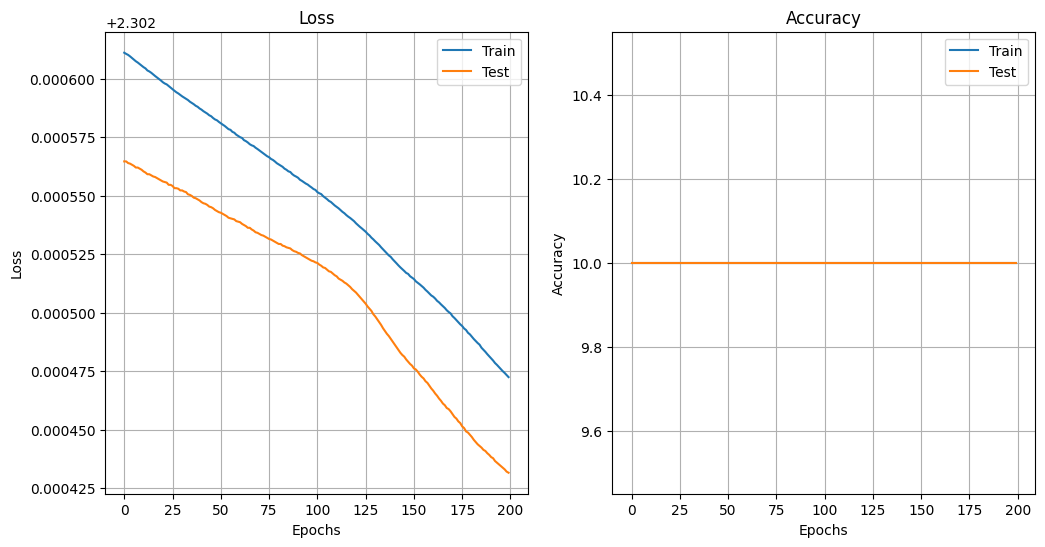

In [26]:
cnn_sgd = CNN_Torch()
sgd = torch.optim.SGD(cnn_sgd.parameters(), lr=0.001, momentum=0.9)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(sgd,
                                                                         cnn_sgd,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

| **Train Accuracy** | **Test Accuracy** |
|--------------------|-------------------|
| 10.00%             | 10.00%            |

**Note:** Since SGD doesn't adapt according to the gradient magnitude, even momentum doesn't help in proper updation of weights.

#### 2.2.c) RMSProp

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 28.36it/s]


Epoch 1/200, Train Loss: 2.3017, Test Loss: 2.2980, Train Accuracy: 10.30%, Test Accuracy: 15.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 30.06it/s]


Epoch 2/200, Train Loss: 2.2936, Test Loss: 2.2879, Train Accuracy: 14.40%, Test Accuracy: 13.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 28.52it/s]


Epoch 3/200, Train Loss: 2.2759, Test Loss: 2.2706, Train Accuracy: 17.20%, Test Accuracy: 18.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 26.20it/s]


Epoch 4/200, Train Loss: 2.2576, Test Loss: 2.2569, Train Accuracy: 18.90%, Test Accuracy: 20.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 22.73it/s]


Epoch 5/200, Train Loss: 2.2481, Test Loss: 2.2322, Train Accuracy: 20.40%, Test Accuracy: 22.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 30.70it/s]


Epoch 6/200, Train Loss: 2.2305, Test Loss: 2.2276, Train Accuracy: 22.00%, Test Accuracy: 23.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 32.81it/s]


Epoch 7/200, Train Loss: 2.2170, Test Loss: 2.2150, Train Accuracy: 24.60%, Test Accuracy: 27.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 33.13it/s]


Epoch 8/200, Train Loss: 2.2198, Test Loss: 2.2150, Train Accuracy: 24.10%, Test Accuracy: 23.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 28.70it/s]


Epoch 9/200, Train Loss: 2.2071, Test Loss: 2.2294, Train Accuracy: 23.40%, Test Accuracy: 24.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Epoch 10/200, Train Loss: 2.2012, Test Loss: 2.2163, Train Accuracy: 25.00%, Test Accuracy: 25.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 27.63it/s]


Epoch 11/200, Train Loss: 2.2015, Test Loss: 2.1979, Train Accuracy: 24.90%, Test Accuracy: 23.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 31.14it/s]


Epoch 12/200, Train Loss: 2.1927, Test Loss: 2.1988, Train Accuracy: 25.30%, Test Accuracy: 27.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 32.53it/s]


Epoch 13/200, Train Loss: 2.1871, Test Loss: 2.2001, Train Accuracy: 27.00%, Test Accuracy: 28.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 33.62it/s]


Epoch 14/200, Train Loss: 2.1851, Test Loss: 2.2118, Train Accuracy: 27.70%, Test Accuracy: 22.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 30.37it/s]


Epoch 15/200, Train Loss: 2.1864, Test Loss: 2.1943, Train Accuracy: 27.40%, Test Accuracy: 26.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


Epoch 16/200, Train Loss: 2.1677, Test Loss: 2.1860, Train Accuracy: 29.10%, Test Accuracy: 29.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 29.44it/s]


Epoch 17/200, Train Loss: 2.1716, Test Loss: 2.1993, Train Accuracy: 28.60%, Test Accuracy: 26.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 29.97it/s]


Epoch 18/200, Train Loss: 2.1638, Test Loss: 2.2196, Train Accuracy: 29.70%, Test Accuracy: 25.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 32.52it/s]


Epoch 19/200, Train Loss: 2.1664, Test Loss: 2.2009, Train Accuracy: 30.40%, Test Accuracy: 24.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 30.64it/s]


Epoch 20/200, Train Loss: 2.1641, Test Loss: 2.1901, Train Accuracy: 29.50%, Test Accuracy: 26.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 24.77it/s]


Epoch 21/200, Train Loss: 2.1528, Test Loss: 2.1845, Train Accuracy: 30.10%, Test Accuracy: 31.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 28.16it/s]


Epoch 22/200, Train Loss: 2.1605, Test Loss: 2.1881, Train Accuracy: 28.80%, Test Accuracy: 24.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 29.18it/s]


Epoch 23/200, Train Loss: 2.1579, Test Loss: 2.1840, Train Accuracy: 29.60%, Test Accuracy: 29.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 26.90it/s]


Epoch 24/200, Train Loss: 2.1475, Test Loss: 2.1775, Train Accuracy: 29.70%, Test Accuracy: 31.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 30.74it/s]


Epoch 25/200, Train Loss: 2.1622, Test Loss: 2.1884, Train Accuracy: 28.70%, Test Accuracy: 24.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 31.52it/s]


Epoch 26/200, Train Loss: 2.1388, Test Loss: 2.1955, Train Accuracy: 31.60%, Test Accuracy: 25.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 33.09it/s]


Epoch 27/200, Train Loss: 2.1463, Test Loss: 2.1916, Train Accuracy: 30.60%, Test Accuracy: 26.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 31.05it/s]


Epoch 28/200, Train Loss: 2.1481, Test Loss: 2.1804, Train Accuracy: 31.40%, Test Accuracy: 25.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 29.77it/s]


Epoch 29/200, Train Loss: 2.1422, Test Loss: 2.1790, Train Accuracy: 31.30%, Test Accuracy: 28.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 33.80it/s]


Epoch 30/200, Train Loss: 2.1311, Test Loss: 2.2109, Train Accuracy: 32.00%, Test Accuracy: 25.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 30.32it/s]


Epoch 31/200, Train Loss: 2.1564, Test Loss: 2.1806, Train Accuracy: 28.60%, Test Accuracy: 27.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 29.40it/s]


Epoch 32/200, Train Loss: 2.1304, Test Loss: 2.2000, Train Accuracy: 32.90%, Test Accuracy: 24.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 28.35it/s]


Epoch 33/200, Train Loss: 2.1283, Test Loss: 2.1951, Train Accuracy: 33.20%, Test Accuracy: 25.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 30.95it/s]


Epoch 34/200, Train Loss: 2.1309, Test Loss: 2.1784, Train Accuracy: 32.00%, Test Accuracy: 29.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 29.38it/s]


Epoch 35/200, Train Loss: 2.1321, Test Loss: 2.1777, Train Accuracy: 33.00%, Test Accuracy: 26.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 24.91it/s]


Epoch 36/200, Train Loss: 2.1393, Test Loss: 2.1861, Train Accuracy: 31.30%, Test Accuracy: 28.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 17.54it/s]


Epoch 37/200, Train Loss: 2.1212, Test Loss: 2.1841, Train Accuracy: 33.20%, Test Accuracy: 26.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 19.82it/s]


Epoch 38/200, Train Loss: 2.1269, Test Loss: 2.1754, Train Accuracy: 32.40%, Test Accuracy: 27.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s]


Epoch 39/200, Train Loss: 2.1274, Test Loss: 2.1793, Train Accuracy: 32.80%, Test Accuracy: 27.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 26.74it/s]


Epoch 40/200, Train Loss: 2.1246, Test Loss: 2.1856, Train Accuracy: 33.60%, Test Accuracy: 27.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 30.38it/s]


Epoch 41/200, Train Loss: 2.1268, Test Loss: 2.1767, Train Accuracy: 32.70%, Test Accuracy: 29.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 28.93it/s]


Epoch 42/200, Train Loss: 2.1207, Test Loss: 2.1743, Train Accuracy: 32.90%, Test Accuracy: 29.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 26.70it/s]


Epoch 43/200, Train Loss: 2.1297, Test Loss: 2.1716, Train Accuracy: 30.90%, Test Accuracy: 28.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 34.41it/s]


Epoch 44/200, Train Loss: 2.1082, Test Loss: 2.1734, Train Accuracy: 34.00%, Test Accuracy: 31.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 32.06it/s]


Epoch 45/200, Train Loss: 2.1080, Test Loss: 2.1839, Train Accuracy: 35.10%, Test Accuracy: 29.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 32.37it/s]


Epoch 46/200, Train Loss: 2.1182, Test Loss: 2.1892, Train Accuracy: 33.90%, Test Accuracy: 25.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 31.75it/s]


Epoch 47/200, Train Loss: 2.1095, Test Loss: 2.1748, Train Accuracy: 34.20%, Test Accuracy: 26.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 30.72it/s]


Epoch 48/200, Train Loss: 2.1107, Test Loss: 2.1717, Train Accuracy: 34.50%, Test Accuracy: 27.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 30.80it/s]


Epoch 49/200, Train Loss: 2.1090, Test Loss: 2.1804, Train Accuracy: 35.10%, Test Accuracy: 30.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 32.81it/s]


Epoch 50/200, Train Loss: 2.1111, Test Loss: 2.1885, Train Accuracy: 34.60%, Test Accuracy: 25.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 31.55it/s]


Epoch 51/200, Train Loss: 2.1189, Test Loss: 2.1661, Train Accuracy: 33.80%, Test Accuracy: 30.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 33.07it/s]


Epoch 52/200, Train Loss: 2.0992, Test Loss: 2.1677, Train Accuracy: 36.10%, Test Accuracy: 29.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 32.45it/s]


Epoch 53/200, Train Loss: 2.1015, Test Loss: 2.1738, Train Accuracy: 35.10%, Test Accuracy: 29.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 33.15it/s]


Epoch 54/200, Train Loss: 2.0978, Test Loss: 2.1712, Train Accuracy: 35.10%, Test Accuracy: 30.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 28.11it/s]


Epoch 55/200, Train Loss: 2.1102, Test Loss: 2.1725, Train Accuracy: 33.80%, Test Accuracy: 28.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 29.60it/s]


Epoch 56/200, Train Loss: 2.1065, Test Loss: 2.1690, Train Accuracy: 35.60%, Test Accuracy: 29.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s]


Epoch 57/200, Train Loss: 2.1020, Test Loss: 2.1718, Train Accuracy: 35.90%, Test Accuracy: 28.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Epoch 58/200, Train Loss: 2.1014, Test Loss: 2.1703, Train Accuracy: 35.10%, Test Accuracy: 27.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 32.35it/s]


Epoch 59/200, Train Loss: 2.0913, Test Loss: 2.1687, Train Accuracy: 36.70%, Test Accuracy: 30.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 29.52it/s]


Epoch 60/200, Train Loss: 2.1032, Test Loss: 2.1799, Train Accuracy: 35.10%, Test Accuracy: 29.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


Epoch 61/200, Train Loss: 2.0912, Test Loss: 2.1709, Train Accuracy: 36.50%, Test Accuracy: 29.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 33.66it/s]


Epoch 62/200, Train Loss: 2.0874, Test Loss: 2.1692, Train Accuracy: 37.20%, Test Accuracy: 30.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 34.39it/s]


Epoch 63/200, Train Loss: 2.1018, Test Loss: 2.1948, Train Accuracy: 35.60%, Test Accuracy: 28.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 31.09it/s]


Epoch 64/200, Train Loss: 2.0863, Test Loss: 2.1769, Train Accuracy: 37.20%, Test Accuracy: 29.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 32.72it/s]


Epoch 65/200, Train Loss: 2.0883, Test Loss: 2.1716, Train Accuracy: 37.30%, Test Accuracy: 26.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 31.44it/s]


Epoch 66/200, Train Loss: 2.0923, Test Loss: 2.1744, Train Accuracy: 36.80%, Test Accuracy: 30.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 31.14it/s]


Epoch 67/200, Train Loss: 2.0916, Test Loss: 2.1657, Train Accuracy: 36.10%, Test Accuracy: 29.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 33.55it/s]


Epoch 68/200, Train Loss: 2.0798, Test Loss: 2.1605, Train Accuracy: 37.60%, Test Accuracy: 30.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 31.28it/s]


Epoch 69/200, Train Loss: 2.0857, Test Loss: 2.1635, Train Accuracy: 37.50%, Test Accuracy: 30.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 32.17it/s]


Epoch 70/200, Train Loss: 2.0793, Test Loss: 2.1681, Train Accuracy: 38.60%, Test Accuracy: 29.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 30.24it/s]


Epoch 71/200, Train Loss: 2.0828, Test Loss: 2.1658, Train Accuracy: 37.70%, Test Accuracy: 29.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 28.44it/s]


Epoch 72/200, Train Loss: 2.0809, Test Loss: 2.1692, Train Accuracy: 38.20%, Test Accuracy: 29.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 32.52it/s]


Epoch 73/200, Train Loss: 2.0768, Test Loss: 2.1795, Train Accuracy: 38.10%, Test Accuracy: 28.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 31.98it/s]


Epoch 74/200, Train Loss: 2.0715, Test Loss: 2.1745, Train Accuracy: 38.90%, Test Accuracy: 29.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 29.24it/s]


Epoch 75/200, Train Loss: 2.0690, Test Loss: 2.1641, Train Accuracy: 39.70%, Test Accuracy: 28.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 32.63it/s]


Epoch 76/200, Train Loss: 2.0650, Test Loss: 2.1622, Train Accuracy: 40.20%, Test Accuracy: 28.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 32.23it/s]


Epoch 77/200, Train Loss: 2.0777, Test Loss: 2.1681, Train Accuracy: 38.10%, Test Accuracy: 27.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 30.84it/s]


Epoch 78/200, Train Loss: 2.0844, Test Loss: 2.1630, Train Accuracy: 37.10%, Test Accuracy: 28.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 31.33it/s]


Epoch 79/200, Train Loss: 2.0694, Test Loss: 2.1694, Train Accuracy: 38.90%, Test Accuracy: 28.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 33.75it/s]


Epoch 80/200, Train Loss: 2.0665, Test Loss: 2.1674, Train Accuracy: 40.00%, Test Accuracy: 29.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 31.42it/s]


Epoch 81/200, Train Loss: 2.0634, Test Loss: 2.2099, Train Accuracy: 40.20%, Test Accuracy: 24.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 29.43it/s]


Epoch 82/200, Train Loss: 2.0595, Test Loss: 2.1619, Train Accuracy: 40.60%, Test Accuracy: 32.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 33.91it/s]


Epoch 83/200, Train Loss: 2.0674, Test Loss: 2.1606, Train Accuracy: 39.30%, Test Accuracy: 30.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 38.76it/s]


Epoch 84/200, Train Loss: 2.0606, Test Loss: 2.1679, Train Accuracy: 40.10%, Test Accuracy: 28.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 33.91it/s]


Epoch 85/200, Train Loss: 2.0594, Test Loss: 2.1535, Train Accuracy: 39.80%, Test Accuracy: 30.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 31.04it/s]


Epoch 86/200, Train Loss: 2.0629, Test Loss: 2.1561, Train Accuracy: 40.00%, Test Accuracy: 29.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 34.58it/s]


Epoch 87/200, Train Loss: 2.0642, Test Loss: 2.1739, Train Accuracy: 39.90%, Test Accuracy: 27.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 40.04it/s]


Epoch 88/200, Train Loss: 2.0592, Test Loss: 2.1560, Train Accuracy: 40.10%, Test Accuracy: 31.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 35.34it/s]


Epoch 89/200, Train Loss: 2.0564, Test Loss: 2.1687, Train Accuracy: 40.30%, Test Accuracy: 30.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 38.79it/s]


Epoch 90/200, Train Loss: 2.0528, Test Loss: 2.1737, Train Accuracy: 40.50%, Test Accuracy: 29.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 37.83it/s]


Epoch 91/200, Train Loss: 2.0562, Test Loss: 2.1585, Train Accuracy: 40.30%, Test Accuracy: 32.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 34.33it/s]


Epoch 92/200, Train Loss: 2.0604, Test Loss: 2.1533, Train Accuracy: 40.30%, Test Accuracy: 30.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 35.69it/s]


Epoch 93/200, Train Loss: 2.0507, Test Loss: 2.1705, Train Accuracy: 41.20%, Test Accuracy: 29.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 33.46it/s]


Epoch 94/200, Train Loss: 2.0531, Test Loss: 2.1574, Train Accuracy: 41.30%, Test Accuracy: 29.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 34.96it/s]


Epoch 95/200, Train Loss: 2.0488, Test Loss: 2.1636, Train Accuracy: 41.60%, Test Accuracy: 29.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 34.87it/s]


Epoch 96/200, Train Loss: 2.0375, Test Loss: 2.1935, Train Accuracy: 42.60%, Test Accuracy: 25.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 26.79it/s]


Epoch 97/200, Train Loss: 2.0587, Test Loss: 2.1694, Train Accuracy: 40.00%, Test Accuracy: 29.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 23.17it/s]


Epoch 98/200, Train Loss: 2.0436, Test Loss: 2.1736, Train Accuracy: 42.90%, Test Accuracy: 29.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s]


Epoch 99/200, Train Loss: 2.0450, Test Loss: 2.1594, Train Accuracy: 42.40%, Test Accuracy: 30.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 16.53it/s]


Epoch 100/200, Train Loss: 2.0540, Test Loss: 2.1724, Train Accuracy: 40.80%, Test Accuracy: 28.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 24.00it/s]


Epoch 101/200, Train Loss: 2.0451, Test Loss: 2.1622, Train Accuracy: 41.80%, Test Accuracy: 30.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 30.12it/s]


Epoch 102/200, Train Loss: 2.0425, Test Loss: 2.1703, Train Accuracy: 42.60%, Test Accuracy: 27.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 35.26it/s]


Epoch 103/200, Train Loss: 2.0330, Test Loss: 2.1757, Train Accuracy: 42.90%, Test Accuracy: 28.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 34.30it/s]


Epoch 104/200, Train Loss: 2.0432, Test Loss: 2.1736, Train Accuracy: 42.10%, Test Accuracy: 29.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 39.22it/s]


Epoch 105/200, Train Loss: 2.0279, Test Loss: 2.1831, Train Accuracy: 44.20%, Test Accuracy: 28.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 32.91it/s]


Epoch 106/200, Train Loss: 2.0412, Test Loss: 2.1694, Train Accuracy: 42.20%, Test Accuracy: 28.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 34.25it/s]


Epoch 107/200, Train Loss: 2.0383, Test Loss: 2.1925, Train Accuracy: 42.50%, Test Accuracy: 26.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 31.75it/s]


Epoch 108/200, Train Loss: 2.0359, Test Loss: 2.1696, Train Accuracy: 42.70%, Test Accuracy: 29.00%


Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 33.45it/s]


Epoch 109/200, Train Loss: 2.0301, Test Loss: 2.1782, Train Accuracy: 43.00%, Test Accuracy: 27.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 23.03it/s]


Epoch 110/200, Train Loss: 2.0376, Test Loss: 2.1602, Train Accuracy: 42.60%, Test Accuracy: 31.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 34.45it/s]


Epoch 111/200, Train Loss: 2.0585, Test Loss: 2.1732, Train Accuracy: 40.40%, Test Accuracy: 29.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 34.69it/s]


Epoch 112/200, Train Loss: 2.0304, Test Loss: 2.1664, Train Accuracy: 43.50%, Test Accuracy: 30.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 36.40it/s]


Epoch 113/200, Train Loss: 2.0276, Test Loss: 2.1752, Train Accuracy: 42.70%, Test Accuracy: 31.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 34.66it/s]


Epoch 114/200, Train Loss: 2.0352, Test Loss: 2.1641, Train Accuracy: 42.90%, Test Accuracy: 28.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 31.53it/s]


Epoch 115/200, Train Loss: 2.0262, Test Loss: 2.1782, Train Accuracy: 43.90%, Test Accuracy: 28.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 32.50it/s]


Epoch 116/200, Train Loss: 2.0356, Test Loss: 2.1790, Train Accuracy: 42.90%, Test Accuracy: 28.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 31.87it/s]


Epoch 117/200, Train Loss: 2.0314, Test Loss: 2.1819, Train Accuracy: 43.30%, Test Accuracy: 27.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 31.88it/s]


Epoch 118/200, Train Loss: 2.0246, Test Loss: 2.1601, Train Accuracy: 43.70%, Test Accuracy: 29.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 31.47it/s]


Epoch 119/200, Train Loss: 2.0299, Test Loss: 2.1748, Train Accuracy: 44.00%, Test Accuracy: 29.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 34.20it/s]


Epoch 120/200, Train Loss: 2.0308, Test Loss: 2.1835, Train Accuracy: 43.70%, Test Accuracy: 27.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 27.68it/s]


Epoch 121/200, Train Loss: 2.0171, Test Loss: 2.1772, Train Accuracy: 44.80%, Test Accuracy: 26.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 27.16it/s]


Epoch 122/200, Train Loss: 2.0174, Test Loss: 2.1803, Train Accuracy: 44.80%, Test Accuracy: 27.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 31.08it/s]


Epoch 123/200, Train Loss: 2.0324, Test Loss: 2.1771, Train Accuracy: 42.80%, Test Accuracy: 25.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 33.75it/s]


Epoch 124/200, Train Loss: 2.0144, Test Loss: 2.1801, Train Accuracy: 45.70%, Test Accuracy: 25.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 37.40it/s]


Epoch 125/200, Train Loss: 2.0254, Test Loss: 2.1749, Train Accuracy: 43.90%, Test Accuracy: 26.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 37.60it/s]


Epoch 126/200, Train Loss: 2.0262, Test Loss: 2.1821, Train Accuracy: 43.30%, Test Accuracy: 24.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 34.59it/s]


Epoch 127/200, Train Loss: 2.0094, Test Loss: 2.1616, Train Accuracy: 46.00%, Test Accuracy: 29.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 31.94it/s]


Epoch 128/200, Train Loss: 2.0232, Test Loss: 2.1669, Train Accuracy: 44.80%, Test Accuracy: 29.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 31.74it/s]


Epoch 129/200, Train Loss: 2.0213, Test Loss: 2.1807, Train Accuracy: 44.50%, Test Accuracy: 27.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 37.12it/s]


Epoch 130/200, Train Loss: 2.0043, Test Loss: 2.1715, Train Accuracy: 46.10%, Test Accuracy: 28.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 34.52it/s]


Epoch 131/200, Train Loss: 2.0082, Test Loss: 2.1628, Train Accuracy: 45.70%, Test Accuracy: 31.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 30.50it/s]


Epoch 132/200, Train Loss: 2.0205, Test Loss: 2.1652, Train Accuracy: 44.10%, Test Accuracy: 28.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 33.21it/s]


Epoch 133/200, Train Loss: 2.0085, Test Loss: 2.1726, Train Accuracy: 45.90%, Test Accuracy: 28.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 26.70it/s]


Epoch 134/200, Train Loss: 2.0113, Test Loss: 2.1747, Train Accuracy: 45.60%, Test Accuracy: 28.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 23.48it/s]


Epoch 135/200, Train Loss: 2.0066, Test Loss: 2.1699, Train Accuracy: 46.50%, Test Accuracy: 31.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 26.95it/s]


Epoch 136/200, Train Loss: 2.0087, Test Loss: 2.1696, Train Accuracy: 46.20%, Test Accuracy: 28.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 28.94it/s]


Epoch 137/200, Train Loss: 2.0093, Test Loss: 2.1662, Train Accuracy: 45.90%, Test Accuracy: 29.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 31.87it/s]


Epoch 138/200, Train Loss: 1.9975, Test Loss: 2.1872, Train Accuracy: 46.80%, Test Accuracy: 26.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 32.40it/s]


Epoch 139/200, Train Loss: 2.0032, Test Loss: 2.1645, Train Accuracy: 45.90%, Test Accuracy: 29.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


Epoch 140/200, Train Loss: 2.0045, Test Loss: 2.1595, Train Accuracy: 46.20%, Test Accuracy: 32.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 23.64it/s]


Epoch 141/200, Train Loss: 2.0009, Test Loss: 2.1682, Train Accuracy: 46.90%, Test Accuracy: 28.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 36.28it/s]


Epoch 142/200, Train Loss: 2.0049, Test Loss: 2.1587, Train Accuracy: 46.60%, Test Accuracy: 31.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 33.59it/s]


Epoch 143/200, Train Loss: 2.0005, Test Loss: 2.1799, Train Accuracy: 46.60%, Test Accuracy: 26.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 29.93it/s]


Epoch 144/200, Train Loss: 2.0024, Test Loss: 2.1578, Train Accuracy: 46.40%, Test Accuracy: 30.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 27.64it/s]


Epoch 145/200, Train Loss: 2.0024, Test Loss: 2.1539, Train Accuracy: 46.20%, Test Accuracy: 30.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 28.70it/s]


Epoch 146/200, Train Loss: 1.9992, Test Loss: 2.1588, Train Accuracy: 46.90%, Test Accuracy: 29.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 29.58it/s]


Epoch 147/200, Train Loss: 1.9872, Test Loss: 2.1686, Train Accuracy: 47.90%, Test Accuracy: 30.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 32.92it/s]


Epoch 148/200, Train Loss: 1.9979, Test Loss: 2.1759, Train Accuracy: 46.80%, Test Accuracy: 27.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s]


Epoch 149/200, Train Loss: 1.9930, Test Loss: 2.1838, Train Accuracy: 47.20%, Test Accuracy: 26.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 29.48it/s]


Epoch 150/200, Train Loss: 1.9971, Test Loss: 2.1749, Train Accuracy: 46.50%, Test Accuracy: 28.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 31.61it/s]


Epoch 151/200, Train Loss: 1.9959, Test Loss: 2.1557, Train Accuracy: 46.90%, Test Accuracy: 30.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 32.38it/s]


Epoch 152/200, Train Loss: 1.9890, Test Loss: 2.1770, Train Accuracy: 47.80%, Test Accuracy: 25.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 27.68it/s]


Epoch 153/200, Train Loss: 1.9899, Test Loss: 2.1702, Train Accuracy: 47.30%, Test Accuracy: 28.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 31.31it/s]


Epoch 154/200, Train Loss: 1.9874, Test Loss: 2.1601, Train Accuracy: 48.30%, Test Accuracy: 30.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 30.18it/s]


Epoch 155/200, Train Loss: 1.9870, Test Loss: 2.1666, Train Accuracy: 47.50%, Test Accuracy: 31.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 31.72it/s]


Epoch 156/200, Train Loss: 1.9836, Test Loss: 2.1621, Train Accuracy: 48.70%, Test Accuracy: 29.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 26.73it/s]


Epoch 157/200, Train Loss: 1.9878, Test Loss: 2.1725, Train Accuracy: 47.80%, Test Accuracy: 26.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 30.96it/s]


Epoch 158/200, Train Loss: 1.9865, Test Loss: 2.1940, Train Accuracy: 47.90%, Test Accuracy: 25.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


Epoch 159/200, Train Loss: 1.9881, Test Loss: 2.1670, Train Accuracy: 47.80%, Test Accuracy: 29.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Epoch 160/200, Train Loss: 1.9850, Test Loss: 2.1772, Train Accuracy: 48.40%, Test Accuracy: 28.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 23.77it/s]


Epoch 161/200, Train Loss: 1.9745, Test Loss: 2.1732, Train Accuracy: 49.70%, Test Accuracy: 27.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 30.19it/s]


Epoch 162/200, Train Loss: 1.9733, Test Loss: 2.1707, Train Accuracy: 49.40%, Test Accuracy: 28.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 30.91it/s]


Epoch 163/200, Train Loss: 1.9804, Test Loss: 2.1626, Train Accuracy: 48.60%, Test Accuracy: 29.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 32.54it/s]


Epoch 164/200, Train Loss: 1.9797, Test Loss: 2.1788, Train Accuracy: 48.80%, Test Accuracy: 26.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 32.91it/s]


Epoch 165/200, Train Loss: 1.9727, Test Loss: 2.1614, Train Accuracy: 49.60%, Test Accuracy: 32.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 31.70it/s]


Epoch 166/200, Train Loss: 1.9669, Test Loss: 2.1686, Train Accuracy: 50.30%, Test Accuracy: 27.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 33.33it/s]


Epoch 167/200, Train Loss: 1.9860, Test Loss: 2.1692, Train Accuracy: 48.10%, Test Accuracy: 29.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 28.29it/s]


Epoch 168/200, Train Loss: 1.9701, Test Loss: 2.1833, Train Accuracy: 49.40%, Test Accuracy: 26.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 30.57it/s]


Epoch 169/200, Train Loss: 1.9769, Test Loss: 2.1881, Train Accuracy: 48.90%, Test Accuracy: 26.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 28.72it/s]


Epoch 170/200, Train Loss: 1.9782, Test Loss: 2.1724, Train Accuracy: 48.80%, Test Accuracy: 29.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 26.27it/s]


Epoch 171/200, Train Loss: 1.9647, Test Loss: 2.1834, Train Accuracy: 50.30%, Test Accuracy: 25.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 23.82it/s]


Epoch 172/200, Train Loss: 1.9746, Test Loss: 2.1647, Train Accuracy: 49.60%, Test Accuracy: 28.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 28.43it/s]


Epoch 173/200, Train Loss: 1.9743, Test Loss: 2.1735, Train Accuracy: 49.50%, Test Accuracy: 29.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 25.55it/s]


Epoch 174/200, Train Loss: 1.9729, Test Loss: 2.1819, Train Accuracy: 49.50%, Test Accuracy: 26.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 27.00it/s]


Epoch 175/200, Train Loss: 1.9633, Test Loss: 2.1623, Train Accuracy: 50.30%, Test Accuracy: 29.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 29.99it/s]


Epoch 176/200, Train Loss: 1.9725, Test Loss: 2.1765, Train Accuracy: 49.10%, Test Accuracy: 28.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 29.42it/s]


Epoch 177/200, Train Loss: 1.9734, Test Loss: 2.1618, Train Accuracy: 49.50%, Test Accuracy: 30.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 36.99it/s]


Epoch 178/200, Train Loss: 1.9646, Test Loss: 2.1631, Train Accuracy: 50.00%, Test Accuracy: 31.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 32.56it/s]


Epoch 179/200, Train Loss: 1.9748, Test Loss: 2.1655, Train Accuracy: 48.50%, Test Accuracy: 29.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 36.63it/s]


Epoch 180/200, Train Loss: 1.9640, Test Loss: 2.1627, Train Accuracy: 50.30%, Test Accuracy: 32.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 31.90it/s]


Epoch 181/200, Train Loss: 1.9655, Test Loss: 2.1656, Train Accuracy: 50.60%, Test Accuracy: 29.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 35.17it/s]


Epoch 182/200, Train Loss: 1.9699, Test Loss: 2.1692, Train Accuracy: 50.00%, Test Accuracy: 28.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 31.49it/s]


Epoch 183/200, Train Loss: 1.9524, Test Loss: 2.1644, Train Accuracy: 51.80%, Test Accuracy: 28.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 26.34it/s]


Epoch 184/200, Train Loss: 1.9715, Test Loss: 2.1675, Train Accuracy: 49.20%, Test Accuracy: 29.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Epoch 185/200, Train Loss: 1.9539, Test Loss: 2.1705, Train Accuracy: 51.50%, Test Accuracy: 30.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


Epoch 186/200, Train Loss: 1.9570, Test Loss: 2.1836, Train Accuracy: 50.70%, Test Accuracy: 28.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 34.79it/s]


Epoch 187/200, Train Loss: 1.9596, Test Loss: 2.1767, Train Accuracy: 50.80%, Test Accuracy: 29.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 34.62it/s]


Epoch 188/200, Train Loss: 1.9543, Test Loss: 2.1759, Train Accuracy: 51.20%, Test Accuracy: 28.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 45.85it/s]


Epoch 189/200, Train Loss: 1.9511, Test Loss: 2.1786, Train Accuracy: 52.10%, Test Accuracy: 27.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 40.49it/s]


Epoch 190/200, Train Loss: 1.9497, Test Loss: 2.1751, Train Accuracy: 51.70%, Test Accuracy: 28.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 28.31it/s]


Epoch 191/200, Train Loss: 1.9573, Test Loss: 2.1796, Train Accuracy: 51.50%, Test Accuracy: 28.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 41.12it/s]


Epoch 192/200, Train Loss: 1.9578, Test Loss: 2.1761, Train Accuracy: 51.20%, Test Accuracy: 28.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 41.89it/s]


Epoch 193/200, Train Loss: 1.9565, Test Loss: 2.1714, Train Accuracy: 50.90%, Test Accuracy: 30.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 32.93it/s]


Epoch 194/200, Train Loss: 1.9603, Test Loss: 2.1749, Train Accuracy: 50.60%, Test Accuracy: 29.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 36.80it/s]


Epoch 195/200, Train Loss: 1.9382, Test Loss: 2.1763, Train Accuracy: 53.10%, Test Accuracy: 27.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 35.99it/s]


Epoch 196/200, Train Loss: 1.9450, Test Loss: 2.1745, Train Accuracy: 52.10%, Test Accuracy: 27.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 34.13it/s]


Epoch 197/200, Train Loss: 1.9478, Test Loss: 2.1788, Train Accuracy: 52.00%, Test Accuracy: 28.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 34.31it/s]


Epoch 198/200, Train Loss: 1.9417, Test Loss: 2.1820, Train Accuracy: 52.50%, Test Accuracy: 27.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 35.07it/s]


Epoch 199/200, Train Loss: 1.9562, Test Loss: 2.1676, Train Accuracy: 50.90%, Test Accuracy: 27.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 41.13it/s]


Epoch 200/200, Train Loss: 1.9430, Test Loss: 2.2035, Train Accuracy: 52.50%, Test Accuracy: 26.00%


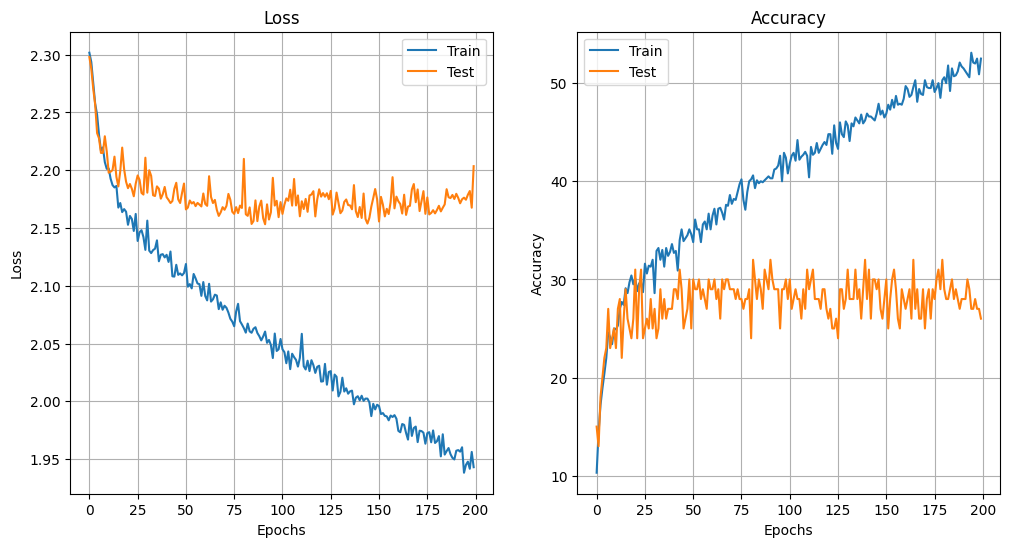

In [27]:
cnn_rms = CNN_Torch()
rms = torch.optim.RMSprop(cnn_rms.parameters(), lr=0.001, alpha=0.9)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(rms,
                                                                         cnn_rms,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

| **Train Accuracy** | **Test Accuracy** |
|--------------------|-------------------|
| 52.50%             | 26.00%            |

**Note:** RMSProp is able to update the weights properly and the model is able to learn to classify the images. However, the model is not able to generalize well

#### 2.3.b Visualize the activation maps

Label: 1
torch.Size([3, 32, 32])


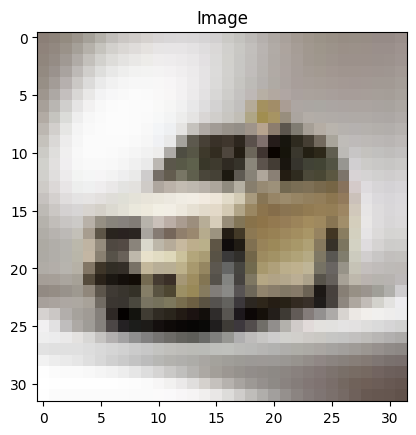

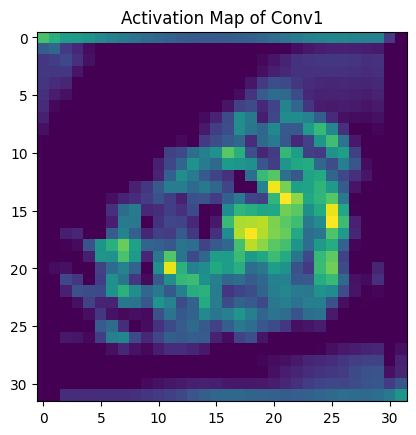

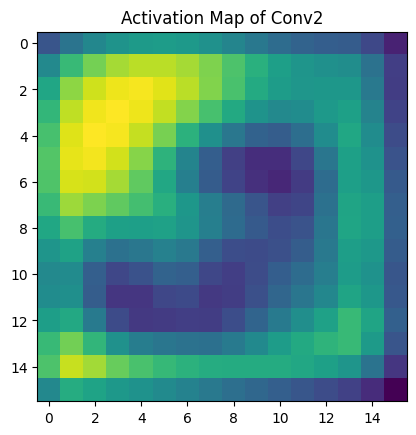

In [28]:
# Pick one image and plot the activation maps at each convolution layer
img, label = test_data[0]
print(f"Label: {label}")
print(img.shape)

# Plot the image
plt.imshow(img.permute(1, 2, 0))
plt.title("Image")
plt.show()

# Convert the image to a batch of size 1
img = img.unsqueeze(0)

# Get the activations at each layer
activation_map_1 = F.relu(cnn_rms.conv1(img))
# Plot the first activation map
plt.imshow(activation_map_1[0, 0].detach().numpy())
plt.title("Activation Map of Conv1")
plt.show()

# Apply pooling
activation_map_1 = cnn_rms.pool1(activation_map_1)

activation_map_2 = F.relu(cnn_rms.conv2(activation_map_1))
# Plot the first activation map
plt.imshow(activation_map_2[0, 0].detach().numpy())
plt.title("Activation Map of Conv2")
plt.show()

#### 2.3.c Accuracy of the classifier
| **Train Accuracy** | **Test Accuracy** |
|--------------------|-------------------|
| 52.50%             | 26.00%            |

### 2.4 Visualize the bottleneck feature using t-SNE

In [29]:
X = []
y = []

for img, label in test_data:
    # Unsqueeze to add a batch dimension
    img = img.unsqueeze(0)

    x = F.relu(cnn_rms.conv1(img))
    x = cnn_rms.pool1(x)
    x = F.relu(cnn_rms.conv2(x))
    x = cnn_rms.pool2(x)
    bottlneck_feat = x.view(-1, 4 * 8 * 8)

    X.append(bottlneck_feat)
    y.append(label)

X = torch.cat(X, dim=0)
print(X.shape)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)

X_embedded = tsne.fit_transform(X.detach().numpy())
print(X_embedded.shape)
y = np.array(y)
print(y.shape)

torch.Size([100, 256])
(100, 2)
(100,)


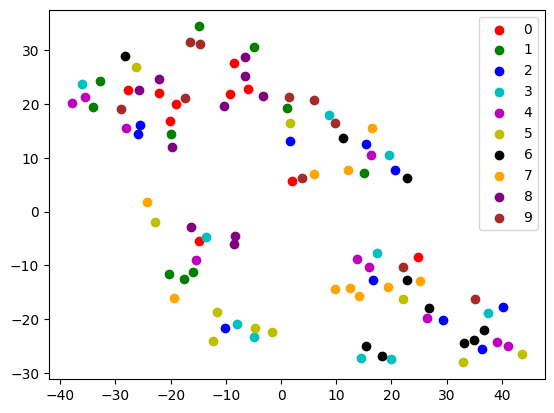

In [30]:
# Plot the t-SNE embeddings
# plt.figure(figsize=(8, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for label in set(y.tolist()):
    X_plot = X_embedded[y == label]
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=colors[label], label=label)
plt.legend()
plt.show()

### 2.5 Apply Dropout at the hidden layer of MLP

In [31]:
class CNN_Torch_Drop(nn.Module):
    def __init__(self, dropout = 0.5):
        super(CNN_Torch_Drop, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=4 * 8 * 8, out_features=49)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        self.fc2 = nn.Linear(in_features=49, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 4 * 8 * 8)  # Flatten the tensor
        # Apply dropout at the hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

Epoch 1/200:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 36.09it/s]


Epoch 1/200, Train Loss: 2.3014, Test Loss: 2.2989, Train Accuracy: 9.90%, Test Accuracy: 10.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 35.80it/s]


Epoch 2/200, Train Loss: 2.2962, Test Loss: 2.2960, Train Accuracy: 9.90%, Test Accuracy: 10.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 33.84it/s]


Epoch 3/200, Train Loss: 2.2904, Test Loss: 2.2901, Train Accuracy: 11.10%, Test Accuracy: 9.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 30.91it/s]


Epoch 4/200, Train Loss: 2.2825, Test Loss: 2.2792, Train Accuracy: 12.40%, Test Accuracy: 20.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 33.36it/s]


Epoch 5/200, Train Loss: 2.2688, Test Loss: 2.2879, Train Accuracy: 16.40%, Test Accuracy: 7.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 29.73it/s]


Epoch 6/200, Train Loss: 2.2585, Test Loss: 2.2551, Train Accuracy: 17.80%, Test Accuracy: 17.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 29.94it/s]


Epoch 7/200, Train Loss: 2.2509, Test Loss: 2.2528, Train Accuracy: 19.80%, Test Accuracy: 19.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 32.81it/s]


Epoch 8/200, Train Loss: 2.2352, Test Loss: 2.2609, Train Accuracy: 21.40%, Test Accuracy: 18.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 32.89it/s]


Epoch 9/200, Train Loss: 2.2307, Test Loss: 2.2500, Train Accuracy: 21.60%, Test Accuracy: 20.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 31.16it/s]


Epoch 10/200, Train Loss: 2.2190, Test Loss: 2.2485, Train Accuracy: 24.30%, Test Accuracy: 17.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 30.89it/s]


Epoch 11/200, Train Loss: 2.2101, Test Loss: 2.2207, Train Accuracy: 24.40%, Test Accuracy: 25.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 32.35it/s]


Epoch 12/200, Train Loss: 2.2111, Test Loss: 2.2160, Train Accuracy: 24.00%, Test Accuracy: 25.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 28.59it/s]


Epoch 13/200, Train Loss: 2.2003, Test Loss: 2.2127, Train Accuracy: 25.40%, Test Accuracy: 24.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 25.61it/s]


Epoch 14/200, Train Loss: 2.1959, Test Loss: 2.2160, Train Accuracy: 26.80%, Test Accuracy: 26.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 36.43it/s]


Epoch 15/200, Train Loss: 2.1929, Test Loss: 2.2052, Train Accuracy: 27.10%, Test Accuracy: 23.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 38.76it/s]


Epoch 16/200, Train Loss: 2.1904, Test Loss: 2.2037, Train Accuracy: 26.30%, Test Accuracy: 26.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 38.57it/s]


Epoch 17/200, Train Loss: 2.1844, Test Loss: 2.1954, Train Accuracy: 26.60%, Test Accuracy: 29.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 37.50it/s]


Epoch 18/200, Train Loss: 2.1866, Test Loss: 2.2125, Train Accuracy: 27.60%, Test Accuracy: 25.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 35.34it/s]


Epoch 19/200, Train Loss: 2.1796, Test Loss: 2.2075, Train Accuracy: 28.20%, Test Accuracy: 26.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 33.26it/s]


Epoch 20/200, Train Loss: 2.1773, Test Loss: 2.1993, Train Accuracy: 28.00%, Test Accuracy: 28.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 34.59it/s]


Epoch 21/200, Train Loss: 2.1775, Test Loss: 2.1988, Train Accuracy: 26.70%, Test Accuracy: 25.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 29.96it/s]


Epoch 22/200, Train Loss: 2.1662, Test Loss: 2.2102, Train Accuracy: 28.80%, Test Accuracy: 24.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 31.58it/s]


Epoch 23/200, Train Loss: 2.1781, Test Loss: 2.1994, Train Accuracy: 26.50%, Test Accuracy: 28.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 38.01it/s]


Epoch 24/200, Train Loss: 2.1635, Test Loss: 2.2040, Train Accuracy: 29.50%, Test Accuracy: 25.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 37.41it/s]


Epoch 25/200, Train Loss: 2.1691, Test Loss: 2.1935, Train Accuracy: 28.70%, Test Accuracy: 28.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 35.97it/s]


Epoch 26/200, Train Loss: 2.1664, Test Loss: 2.2095, Train Accuracy: 29.10%, Test Accuracy: 26.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 34.00it/s]


Epoch 27/200, Train Loss: 2.1720, Test Loss: 2.1977, Train Accuracy: 28.10%, Test Accuracy: 27.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 30.86it/s]


Epoch 28/200, Train Loss: 2.1539, Test Loss: 2.1923, Train Accuracy: 30.80%, Test Accuracy: 29.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 35.53it/s]


Epoch 29/200, Train Loss: 2.1588, Test Loss: 2.1866, Train Accuracy: 29.10%, Test Accuracy: 30.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 32.63it/s]


Epoch 30/200, Train Loss: 2.1559, Test Loss: 2.1875, Train Accuracy: 28.80%, Test Accuracy: 25.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 29.89it/s]


Epoch 31/200, Train Loss: 2.1585, Test Loss: 2.1857, Train Accuracy: 29.90%, Test Accuracy: 26.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 31.69it/s]


Epoch 32/200, Train Loss: 2.1498, Test Loss: 2.1860, Train Accuracy: 30.70%, Test Accuracy: 28.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 32.20it/s]


Epoch 33/200, Train Loss: 2.1457, Test Loss: 2.1790, Train Accuracy: 30.70%, Test Accuracy: 28.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 30.19it/s]


Epoch 34/200, Train Loss: 2.1533, Test Loss: 2.1852, Train Accuracy: 30.70%, Test Accuracy: 28.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 30.55it/s]


Epoch 35/200, Train Loss: 2.1454, Test Loss: 2.1838, Train Accuracy: 30.40%, Test Accuracy: 29.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 33.30it/s]


Epoch 36/200, Train Loss: 2.1317, Test Loss: 2.1905, Train Accuracy: 33.20%, Test Accuracy: 26.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 35.39it/s]


Epoch 37/200, Train Loss: 2.1391, Test Loss: 2.1840, Train Accuracy: 31.40%, Test Accuracy: 28.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 30.71it/s]


Epoch 38/200, Train Loss: 2.1312, Test Loss: 2.1854, Train Accuracy: 32.20%, Test Accuracy: 28.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 30.30it/s]


Epoch 39/200, Train Loss: 2.1481, Test Loss: 2.1836, Train Accuracy: 31.30%, Test Accuracy: 29.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 33.68it/s]


Epoch 40/200, Train Loss: 2.1332, Test Loss: 2.1862, Train Accuracy: 32.50%, Test Accuracy: 27.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 31.15it/s]


Epoch 41/200, Train Loss: 2.1421, Test Loss: 2.1816, Train Accuracy: 31.00%, Test Accuracy: 28.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 30.96it/s]


Epoch 42/200, Train Loss: 2.1331, Test Loss: 2.1754, Train Accuracy: 32.80%, Test Accuracy: 31.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 32.28it/s]


Epoch 43/200, Train Loss: 2.1221, Test Loss: 2.1740, Train Accuracy: 33.60%, Test Accuracy: 30.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 32.75it/s]


Epoch 44/200, Train Loss: 2.1354, Test Loss: 2.2098, Train Accuracy: 32.70%, Test Accuracy: 25.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 35.75it/s]


Epoch 45/200, Train Loss: 2.1208, Test Loss: 2.1725, Train Accuracy: 34.60%, Test Accuracy: 27.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 34.60it/s]


Epoch 46/200, Train Loss: 2.1198, Test Loss: 2.1847, Train Accuracy: 34.50%, Test Accuracy: 27.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Epoch 47/200, Train Loss: 2.1238, Test Loss: 2.1927, Train Accuracy: 33.20%, Test Accuracy: 26.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 23.56it/s]


Epoch 48/200, Train Loss: 2.1171, Test Loss: 2.1770, Train Accuracy: 34.30%, Test Accuracy: 24.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 30.74it/s]


Epoch 49/200, Train Loss: 2.1237, Test Loss: 2.1842, Train Accuracy: 33.00%, Test Accuracy: 31.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 28.73it/s]


Epoch 50/200, Train Loss: 2.1168, Test Loss: 2.1876, Train Accuracy: 34.40%, Test Accuracy: 25.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 30.14it/s]


Epoch 51/200, Train Loss: 2.1217, Test Loss: 2.1837, Train Accuracy: 33.50%, Test Accuracy: 27.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 30.55it/s]


Epoch 52/200, Train Loss: 2.1207, Test Loss: 2.1844, Train Accuracy: 32.90%, Test Accuracy: 28.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 28.36it/s]


Epoch 53/200, Train Loss: 2.1092, Test Loss: 2.1641, Train Accuracy: 34.70%, Test Accuracy: 31.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 31.09it/s]


Epoch 54/200, Train Loss: 2.1132, Test Loss: 2.1602, Train Accuracy: 34.50%, Test Accuracy: 31.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 30.79it/s]


Epoch 55/200, Train Loss: 2.1191, Test Loss: 2.1538, Train Accuracy: 34.10%, Test Accuracy: 31.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 25.61it/s]


Epoch 56/200, Train Loss: 2.1043, Test Loss: 2.1766, Train Accuracy: 36.20%, Test Accuracy: 29.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 26.62it/s]


Epoch 57/200, Train Loss: 2.1082, Test Loss: 2.1772, Train Accuracy: 34.50%, Test Accuracy: 26.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 28.14it/s]


Epoch 58/200, Train Loss: 2.1071, Test Loss: 2.1525, Train Accuracy: 35.60%, Test Accuracy: 30.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 26.73it/s]


Epoch 59/200, Train Loss: 2.1175, Test Loss: 2.1612, Train Accuracy: 34.10%, Test Accuracy: 30.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 29.58it/s]


Epoch 60/200, Train Loss: 2.0954, Test Loss: 2.1714, Train Accuracy: 36.40%, Test Accuracy: 29.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 28.24it/s]


Epoch 61/200, Train Loss: 2.0928, Test Loss: 2.1605, Train Accuracy: 36.90%, Test Accuracy: 31.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 32.37it/s]


Epoch 62/200, Train Loss: 2.1005, Test Loss: 2.1605, Train Accuracy: 35.40%, Test Accuracy: 28.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 31.26it/s]


Epoch 63/200, Train Loss: 2.0997, Test Loss: 2.1991, Train Accuracy: 36.80%, Test Accuracy: 27.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Epoch 64/200, Train Loss: 2.1061, Test Loss: 2.1621, Train Accuracy: 35.30%, Test Accuracy: 31.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 23.19it/s]


Epoch 65/200, Train Loss: 2.0953, Test Loss: 2.1547, Train Accuracy: 36.40%, Test Accuracy: 30.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 30.86it/s]


Epoch 66/200, Train Loss: 2.0983, Test Loss: 2.1792, Train Accuracy: 35.50%, Test Accuracy: 27.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 28.17it/s]


Epoch 67/200, Train Loss: 2.0905, Test Loss: 2.1822, Train Accuracy: 36.90%, Test Accuracy: 27.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 28.87it/s]


Epoch 68/200, Train Loss: 2.0854, Test Loss: 2.1595, Train Accuracy: 38.00%, Test Accuracy: 30.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 29.32it/s]


Epoch 69/200, Train Loss: 2.0969, Test Loss: 2.1416, Train Accuracy: 36.20%, Test Accuracy: 32.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 31.58it/s]


Epoch 70/200, Train Loss: 2.0897, Test Loss: 2.1466, Train Accuracy: 36.40%, Test Accuracy: 32.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 32.77it/s]


Epoch 71/200, Train Loss: 2.0854, Test Loss: 2.1418, Train Accuracy: 37.60%, Test Accuracy: 32.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 31.65it/s]


Epoch 72/200, Train Loss: 2.0751, Test Loss: 2.1442, Train Accuracy: 39.40%, Test Accuracy: 33.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 28.57it/s]


Epoch 73/200, Train Loss: 2.0833, Test Loss: 2.1575, Train Accuracy: 37.40%, Test Accuracy: 30.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 28.54it/s]


Epoch 74/200, Train Loss: 2.0715, Test Loss: 2.1350, Train Accuracy: 39.30%, Test Accuracy: 35.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 29.45it/s]


Epoch 75/200, Train Loss: 2.0744, Test Loss: 2.1768, Train Accuracy: 39.10%, Test Accuracy: 28.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 28.87it/s]


Epoch 76/200, Train Loss: 2.0859, Test Loss: 2.1392, Train Accuracy: 37.70%, Test Accuracy: 34.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 26.60it/s]


Epoch 77/200, Train Loss: 2.0829, Test Loss: 2.1772, Train Accuracy: 37.60%, Test Accuracy: 27.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 29.99it/s]


Epoch 78/200, Train Loss: 2.0797, Test Loss: 2.1543, Train Accuracy: 38.10%, Test Accuracy: 32.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 29.08it/s]


Epoch 79/200, Train Loss: 2.0764, Test Loss: 2.1450, Train Accuracy: 38.10%, Test Accuracy: 32.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 29.07it/s]


Epoch 80/200, Train Loss: 2.0730, Test Loss: 2.1588, Train Accuracy: 39.30%, Test Accuracy: 29.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 26.25it/s]


Epoch 81/200, Train Loss: 2.0698, Test Loss: 2.1496, Train Accuracy: 39.10%, Test Accuracy: 29.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 27.99it/s]


Epoch 82/200, Train Loss: 2.0718, Test Loss: 2.1515, Train Accuracy: 38.80%, Test Accuracy: 30.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 28.38it/s]


Epoch 83/200, Train Loss: 2.0602, Test Loss: 2.1633, Train Accuracy: 39.90%, Test Accuracy: 31.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 27.26it/s]


Epoch 84/200, Train Loss: 2.0577, Test Loss: 2.1539, Train Accuracy: 40.40%, Test Accuracy: 31.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s]


Epoch 85/200, Train Loss: 2.0662, Test Loss: 2.1665, Train Accuracy: 39.60%, Test Accuracy: 29.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 26.11it/s]


Epoch 86/200, Train Loss: 2.0710, Test Loss: 2.1464, Train Accuracy: 38.40%, Test Accuracy: 32.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 31.68it/s]


Epoch 87/200, Train Loss: 2.0550, Test Loss: 2.1452, Train Accuracy: 40.90%, Test Accuracy: 30.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 32.10it/s]


Epoch 88/200, Train Loss: 2.0651, Test Loss: 2.1616, Train Accuracy: 40.40%, Test Accuracy: 30.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 28.30it/s]


Epoch 89/200, Train Loss: 2.0576, Test Loss: 2.1406, Train Accuracy: 40.60%, Test Accuracy: 30.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 28.70it/s]


Epoch 90/200, Train Loss: 2.0546, Test Loss: 2.1441, Train Accuracy: 41.20%, Test Accuracy: 33.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 31.87it/s]


Epoch 91/200, Train Loss: 2.0653, Test Loss: 2.1353, Train Accuracy: 39.60%, Test Accuracy: 31.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 29.76it/s]


Epoch 92/200, Train Loss: 2.0621, Test Loss: 2.1412, Train Accuracy: 40.70%, Test Accuracy: 30.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 35.45it/s]


Epoch 93/200, Train Loss: 2.0409, Test Loss: 2.1613, Train Accuracy: 42.60%, Test Accuracy: 30.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 30.86it/s]


Epoch 94/200, Train Loss: 2.0492, Test Loss: 2.1588, Train Accuracy: 41.60%, Test Accuracy: 30.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 23.91it/s]


Epoch 95/200, Train Loss: 2.0424, Test Loss: 2.1619, Train Accuracy: 41.70%, Test Accuracy: 28.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 28.90it/s]


Epoch 96/200, Train Loss: 2.0568, Test Loss: 2.1305, Train Accuracy: 40.90%, Test Accuracy: 32.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 34.12it/s]


Epoch 97/200, Train Loss: 2.0518, Test Loss: 2.1752, Train Accuracy: 41.30%, Test Accuracy: 27.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 30.02it/s]


Epoch 98/200, Train Loss: 2.0463, Test Loss: 2.1651, Train Accuracy: 41.40%, Test Accuracy: 29.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 31.68it/s]


Epoch 99/200, Train Loss: 2.0478, Test Loss: 2.1539, Train Accuracy: 42.10%, Test Accuracy: 29.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 32.98it/s]


Epoch 100/200, Train Loss: 2.0494, Test Loss: 2.1964, Train Accuracy: 40.60%, Test Accuracy: 24.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 31.69it/s]


Epoch 101/200, Train Loss: 2.0429, Test Loss: 2.1477, Train Accuracy: 42.00%, Test Accuracy: 27.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 28.25it/s]


Epoch 102/200, Train Loss: 2.0427, Test Loss: 2.1314, Train Accuracy: 41.40%, Test Accuracy: 33.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 29.17it/s]


Epoch 103/200, Train Loss: 2.0284, Test Loss: 2.1699, Train Accuracy: 43.00%, Test Accuracy: 30.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


Epoch 104/200, Train Loss: 2.0443, Test Loss: 2.1554, Train Accuracy: 41.90%, Test Accuracy: 28.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 30.12it/s]


Epoch 105/200, Train Loss: 2.0341, Test Loss: 2.1378, Train Accuracy: 43.90%, Test Accuracy: 33.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 30.10it/s]


Epoch 106/200, Train Loss: 2.0310, Test Loss: 2.1502, Train Accuracy: 43.40%, Test Accuracy: 29.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


Epoch 107/200, Train Loss: 2.0281, Test Loss: 2.1313, Train Accuracy: 43.80%, Test Accuracy: 33.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 29.46it/s]


Epoch 108/200, Train Loss: 2.0297, Test Loss: 2.1559, Train Accuracy: 43.60%, Test Accuracy: 29.00%


Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 31.47it/s]


Epoch 109/200, Train Loss: 2.0422, Test Loss: 2.1482, Train Accuracy: 42.00%, Test Accuracy: 32.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 29.01it/s]


Epoch 110/200, Train Loss: 2.0155, Test Loss: 2.1608, Train Accuracy: 45.30%, Test Accuracy: 30.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


Epoch 111/200, Train Loss: 2.0263, Test Loss: 2.1572, Train Accuracy: 43.30%, Test Accuracy: 27.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 31.64it/s]


Epoch 112/200, Train Loss: 2.0214, Test Loss: 2.1570, Train Accuracy: 44.10%, Test Accuracy: 30.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 30.55it/s]


Epoch 113/200, Train Loss: 2.0313, Test Loss: 2.1595, Train Accuracy: 43.30%, Test Accuracy: 29.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 31.23it/s]


Epoch 114/200, Train Loss: 2.0230, Test Loss: 2.1710, Train Accuracy: 43.60%, Test Accuracy: 29.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 28.36it/s]


Epoch 115/200, Train Loss: 2.0311, Test Loss: 2.1479, Train Accuracy: 43.60%, Test Accuracy: 30.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 30.81it/s]


Epoch 116/200, Train Loss: 2.0207, Test Loss: 2.1650, Train Accuracy: 44.40%, Test Accuracy: 30.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 32.10it/s]


Epoch 117/200, Train Loss: 2.0222, Test Loss: 2.1418, Train Accuracy: 44.00%, Test Accuracy: 32.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 26.90it/s]


Epoch 118/200, Train Loss: 2.0077, Test Loss: 2.1407, Train Accuracy: 46.90%, Test Accuracy: 31.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 27.76it/s]


Epoch 119/200, Train Loss: 2.0158, Test Loss: 2.1446, Train Accuracy: 44.90%, Test Accuracy: 29.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 29.24it/s]


Epoch 120/200, Train Loss: 2.0083, Test Loss: 2.1469, Train Accuracy: 47.20%, Test Accuracy: 29.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 28.43it/s]


Epoch 121/200, Train Loss: 2.0148, Test Loss: 2.1599, Train Accuracy: 45.10%, Test Accuracy: 28.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 30.74it/s]


Epoch 122/200, Train Loss: 2.0003, Test Loss: 2.1341, Train Accuracy: 46.80%, Test Accuracy: 31.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 33.92it/s]


Epoch 123/200, Train Loss: 2.0042, Test Loss: 2.1441, Train Accuracy: 47.20%, Test Accuracy: 28.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 38.22it/s]


Epoch 124/200, Train Loss: 2.0130, Test Loss: 2.1719, Train Accuracy: 46.00%, Test Accuracy: 29.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 33.13it/s]


Epoch 125/200, Train Loss: 2.0188, Test Loss: 2.1576, Train Accuracy: 45.00%, Test Accuracy: 29.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 30.84it/s]


Epoch 126/200, Train Loss: 2.0078, Test Loss: 2.1370, Train Accuracy: 46.00%, Test Accuracy: 32.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 27.60it/s]


Epoch 127/200, Train Loss: 2.0082, Test Loss: 2.1592, Train Accuracy: 45.70%, Test Accuracy: 31.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s]


Epoch 128/200, Train Loss: 1.9958, Test Loss: 2.1483, Train Accuracy: 46.40%, Test Accuracy: 30.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 24.42it/s]


Epoch 129/200, Train Loss: 2.0147, Test Loss: 2.1639, Train Accuracy: 46.10%, Test Accuracy: 29.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 26.41it/s]


Epoch 130/200, Train Loss: 2.0015, Test Loss: 2.1580, Train Accuracy: 46.20%, Test Accuracy: 28.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 25.80it/s]


Epoch 131/200, Train Loss: 1.9910, Test Loss: 2.1202, Train Accuracy: 48.40%, Test Accuracy: 35.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 25.11it/s]


Epoch 132/200, Train Loss: 2.0155, Test Loss: 2.1638, Train Accuracy: 44.50%, Test Accuracy: 29.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 28.03it/s]


Epoch 133/200, Train Loss: 2.0052, Test Loss: 2.1687, Train Accuracy: 45.50%, Test Accuracy: 28.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 29.91it/s]


Epoch 134/200, Train Loss: 1.9962, Test Loss: 2.1347, Train Accuracy: 47.10%, Test Accuracy: 34.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 31.80it/s]


Epoch 135/200, Train Loss: 1.9976, Test Loss: 2.1389, Train Accuracy: 47.20%, Test Accuracy: 33.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 32.11it/s]


Epoch 136/200, Train Loss: 1.9915, Test Loss: 2.1361, Train Accuracy: 48.20%, Test Accuracy: 32.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 29.66it/s]


Epoch 137/200, Train Loss: 1.9992, Test Loss: 2.1751, Train Accuracy: 46.30%, Test Accuracy: 28.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 29.28it/s]


Epoch 138/200, Train Loss: 1.9915, Test Loss: 2.1354, Train Accuracy: 47.90%, Test Accuracy: 32.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 26.46it/s]


Epoch 139/200, Train Loss: 1.9906, Test Loss: 2.1582, Train Accuracy: 47.60%, Test Accuracy: 31.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 30.81it/s]


Epoch 140/200, Train Loss: 1.9946, Test Loss: 2.1686, Train Accuracy: 46.70%, Test Accuracy: 26.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 25.82it/s]


Epoch 141/200, Train Loss: 1.9958, Test Loss: 2.1457, Train Accuracy: 47.20%, Test Accuracy: 32.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 23.29it/s]


Epoch 142/200, Train Loss: 1.9842, Test Loss: 2.1807, Train Accuracy: 48.30%, Test Accuracy: 25.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 25.57it/s]


Epoch 143/200, Train Loss: 1.9883, Test Loss: 2.1518, Train Accuracy: 48.00%, Test Accuracy: 31.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 24.98it/s]


Epoch 144/200, Train Loss: 1.9862, Test Loss: 2.1520, Train Accuracy: 47.40%, Test Accuracy: 31.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 26.59it/s]


Epoch 145/200, Train Loss: 1.9993, Test Loss: 2.1550, Train Accuracy: 47.00%, Test Accuracy: 30.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 32.16it/s]


Epoch 146/200, Train Loss: 1.9953, Test Loss: 2.1653, Train Accuracy: 47.50%, Test Accuracy: 29.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 19.75it/s]


Epoch 147/200, Train Loss: 1.9791, Test Loss: 2.1420, Train Accuracy: 48.80%, Test Accuracy: 32.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 25.69it/s]


Epoch 148/200, Train Loss: 1.9818, Test Loss: 2.1403, Train Accuracy: 48.40%, Test Accuracy: 32.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 28.08it/s]


Epoch 149/200, Train Loss: 1.9882, Test Loss: 2.1406, Train Accuracy: 48.40%, Test Accuracy: 33.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 26.23it/s]


Epoch 150/200, Train Loss: 1.9748, Test Loss: 2.1407, Train Accuracy: 49.60%, Test Accuracy: 34.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 25.46it/s]


Epoch 151/200, Train Loss: 1.9745, Test Loss: 2.1445, Train Accuracy: 49.80%, Test Accuracy: 32.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 29.10it/s]


Epoch 152/200, Train Loss: 1.9734, Test Loss: 2.1549, Train Accuracy: 49.40%, Test Accuracy: 30.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 20.68it/s]


Epoch 153/200, Train Loss: 1.9757, Test Loss: 2.1465, Train Accuracy: 48.70%, Test Accuracy: 32.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 19.36it/s]


Epoch 154/200, Train Loss: 1.9843, Test Loss: 2.1788, Train Accuracy: 48.70%, Test Accuracy: 29.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 21.64it/s]


Epoch 155/200, Train Loss: 1.9653, Test Loss: 2.1510, Train Accuracy: 50.50%, Test Accuracy: 30.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 25.12it/s]


Epoch 156/200, Train Loss: 1.9771, Test Loss: 2.1644, Train Accuracy: 49.70%, Test Accuracy: 28.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 27.14it/s]


Epoch 157/200, Train Loss: 1.9740, Test Loss: 2.1716, Train Accuracy: 49.30%, Test Accuracy: 29.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 30.41it/s]


Epoch 158/200, Train Loss: 1.9684, Test Loss: 2.1583, Train Accuracy: 49.60%, Test Accuracy: 29.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 29.07it/s]


Epoch 159/200, Train Loss: 1.9732, Test Loss: 2.1723, Train Accuracy: 49.10%, Test Accuracy: 28.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 30.14it/s]


Epoch 160/200, Train Loss: 1.9754, Test Loss: 2.1722, Train Accuracy: 48.80%, Test Accuracy: 27.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 29.31it/s]


Epoch 161/200, Train Loss: 1.9740, Test Loss: 2.1415, Train Accuracy: 49.10%, Test Accuracy: 33.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 29.81it/s]


Epoch 162/200, Train Loss: 1.9588, Test Loss: 2.1696, Train Accuracy: 51.30%, Test Accuracy: 27.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 25.30it/s]


Epoch 163/200, Train Loss: 1.9720, Test Loss: 2.1609, Train Accuracy: 49.00%, Test Accuracy: 30.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 29.93it/s]


Epoch 164/200, Train Loss: 1.9664, Test Loss: 2.1540, Train Accuracy: 50.20%, Test Accuracy: 31.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 20.27it/s]


Epoch 165/200, Train Loss: 1.9607, Test Loss: 2.1791, Train Accuracy: 50.40%, Test Accuracy: 27.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 26.21it/s]


Epoch 166/200, Train Loss: 1.9613, Test Loss: 2.1770, Train Accuracy: 51.20%, Test Accuracy: 27.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 27.54it/s]


Epoch 167/200, Train Loss: 1.9511, Test Loss: 2.1808, Train Accuracy: 51.40%, Test Accuracy: 28.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 27.71it/s]


Epoch 168/200, Train Loss: 1.9610, Test Loss: 2.1836, Train Accuracy: 51.40%, Test Accuracy: 28.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 28.71it/s]


Epoch 169/200, Train Loss: 1.9531, Test Loss: 2.1603, Train Accuracy: 51.60%, Test Accuracy: 30.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 29.65it/s]


Epoch 170/200, Train Loss: 1.9655, Test Loss: 2.1495, Train Accuracy: 50.40%, Test Accuracy: 31.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 29.60it/s]


Epoch 171/200, Train Loss: 1.9680, Test Loss: 2.1880, Train Accuracy: 50.30%, Test Accuracy: 27.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 23.26it/s]


Epoch 172/200, Train Loss: 1.9696, Test Loss: 2.1759, Train Accuracy: 50.00%, Test Accuracy: 27.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 26.26it/s]


Epoch 173/200, Train Loss: 1.9501, Test Loss: 2.1603, Train Accuracy: 52.30%, Test Accuracy: 29.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 33.26it/s]


Epoch 174/200, Train Loss: 1.9583, Test Loss: 2.1728, Train Accuracy: 50.90%, Test Accuracy: 28.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 35.74it/s]


Epoch 175/200, Train Loss: 1.9472, Test Loss: 2.1683, Train Accuracy: 52.20%, Test Accuracy: 28.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 33.69it/s]


Epoch 176/200, Train Loss: 1.9505, Test Loss: 2.1484, Train Accuracy: 51.50%, Test Accuracy: 32.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 38.97it/s]


Epoch 177/200, Train Loss: 1.9585, Test Loss: 2.1488, Train Accuracy: 51.00%, Test Accuracy: 32.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 39.86it/s]


Epoch 178/200, Train Loss: 1.9651, Test Loss: 2.1585, Train Accuracy: 50.10%, Test Accuracy: 31.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 37.83it/s]


Epoch 179/200, Train Loss: 1.9460, Test Loss: 2.1914, Train Accuracy: 52.10%, Test Accuracy: 27.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 31.80it/s]


Epoch 180/200, Train Loss: 1.9644, Test Loss: 2.1497, Train Accuracy: 49.90%, Test Accuracy: 34.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 35.13it/s]


Epoch 181/200, Train Loss: 1.9585, Test Loss: 2.1784, Train Accuracy: 51.20%, Test Accuracy: 29.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 28.66it/s]


Epoch 182/200, Train Loss: 1.9406, Test Loss: 2.1640, Train Accuracy: 51.90%, Test Accuracy: 29.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 22.34it/s]


Epoch 183/200, Train Loss: 1.9371, Test Loss: 2.1520, Train Accuracy: 53.50%, Test Accuracy: 31.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 22.43it/s]


Epoch 184/200, Train Loss: 1.9402, Test Loss: 2.1638, Train Accuracy: 53.50%, Test Accuracy: 27.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 24.55it/s]


Epoch 185/200, Train Loss: 1.9426, Test Loss: 2.1543, Train Accuracy: 52.00%, Test Accuracy: 30.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


Epoch 186/200, Train Loss: 1.9445, Test Loss: 2.1614, Train Accuracy: 52.40%, Test Accuracy: 27.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


Epoch 187/200, Train Loss: 1.9351, Test Loss: 2.1602, Train Accuracy: 53.90%, Test Accuracy: 30.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 36.22it/s]


Epoch 188/200, Train Loss: 1.9308, Test Loss: 2.1697, Train Accuracy: 53.50%, Test Accuracy: 27.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 35.70it/s]


Epoch 189/200, Train Loss: 1.9299, Test Loss: 2.1641, Train Accuracy: 54.50%, Test Accuracy: 26.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 32.09it/s]


Epoch 190/200, Train Loss: 1.9391, Test Loss: 2.1517, Train Accuracy: 53.10%, Test Accuracy: 32.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 33.53it/s]


Epoch 191/200, Train Loss: 1.9385, Test Loss: 2.1881, Train Accuracy: 53.50%, Test Accuracy: 27.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 19.32it/s]


Epoch 192/200, Train Loss: 1.9389, Test Loss: 2.1547, Train Accuracy: 53.40%, Test Accuracy: 32.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 30.64it/s]


Epoch 193/200, Train Loss: 1.9399, Test Loss: 2.1804, Train Accuracy: 53.00%, Test Accuracy: 27.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 28.51it/s]


Epoch 194/200, Train Loss: 1.9329, Test Loss: 2.1806, Train Accuracy: 53.50%, Test Accuracy: 27.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 34.83it/s]


Epoch 195/200, Train Loss: 1.9384, Test Loss: 2.1481, Train Accuracy: 52.70%, Test Accuracy: 33.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 38.22it/s]


Epoch 196/200, Train Loss: 1.9322, Test Loss: 2.1498, Train Accuracy: 53.70%, Test Accuracy: 29.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 42.15it/s]


Epoch 197/200, Train Loss: 1.9362, Test Loss: 2.1682, Train Accuracy: 52.80%, Test Accuracy: 31.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 39.70it/s]


Epoch 198/200, Train Loss: 1.9237, Test Loss: 2.1827, Train Accuracy: 54.30%, Test Accuracy: 28.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 39.38it/s]


Epoch 199/200, Train Loss: 1.9257, Test Loss: 2.1626, Train Accuracy: 55.10%, Test Accuracy: 29.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 43.81it/s]


Epoch 200/200, Train Loss: 1.9228, Test Loss: 2.1721, Train Accuracy: 55.10%, Test Accuracy: 28.00%


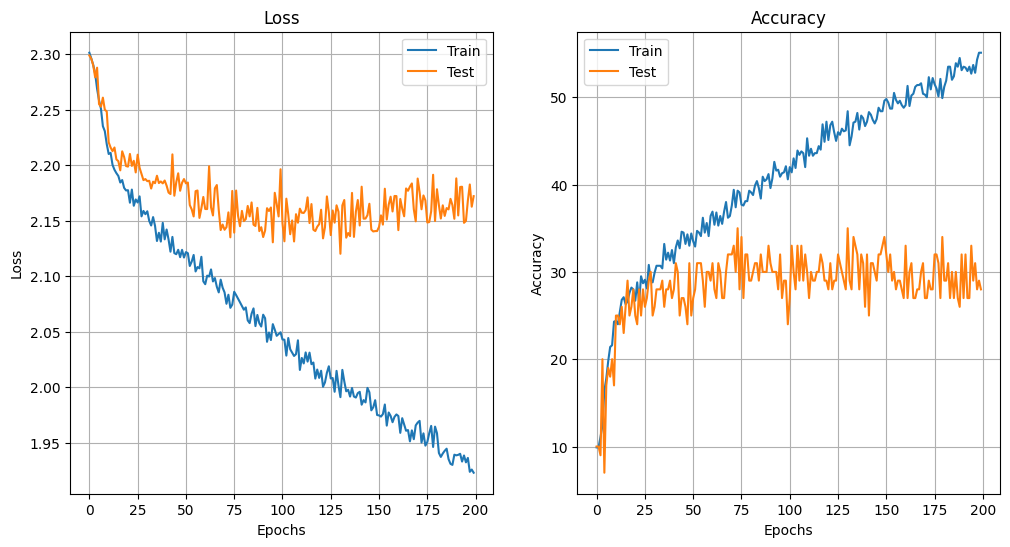

In [32]:
cnn_rms_drop = CNN_Torch_Drop(dropout=0.2)
rms = torch.optim.RMSprop(cnn_rms_drop.parameters(), lr=0.001, alpha=0.9)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(rms,
                                                                         cnn_rms_drop,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 28.85it/s]


Epoch 1/200, Train Loss: 2.3023, Test Loss: 2.3011, Train Accuracy: 10.20%, Test Accuracy: 10.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 36.88it/s]


Epoch 2/200, Train Loss: 2.3001, Test Loss: 2.2968, Train Accuracy: 12.30%, Test Accuracy: 10.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 32.06it/s]


Epoch 3/200, Train Loss: 2.2920, Test Loss: 2.2884, Train Accuracy: 11.90%, Test Accuracy: 12.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 27.04it/s]


Epoch 4/200, Train Loss: 2.2870, Test Loss: 2.2788, Train Accuracy: 14.10%, Test Accuracy: 13.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 34.68it/s]


Epoch 5/200, Train Loss: 2.2763, Test Loss: 2.2646, Train Accuracy: 16.50%, Test Accuracy: 20.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 29.06it/s]


Epoch 6/200, Train Loss: 2.2691, Test Loss: 2.2673, Train Accuracy: 15.40%, Test Accuracy: 20.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 26.19it/s]


Epoch 7/200, Train Loss: 2.2594, Test Loss: 2.2543, Train Accuracy: 17.40%, Test Accuracy: 23.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 29.90it/s]


Epoch 8/200, Train Loss: 2.2491, Test Loss: 2.2331, Train Accuracy: 19.90%, Test Accuracy: 22.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 31.18it/s]


Epoch 9/200, Train Loss: 2.2382, Test Loss: 2.2295, Train Accuracy: 20.90%, Test Accuracy: 20.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s]


Epoch 10/200, Train Loss: 2.2458, Test Loss: 2.2252, Train Accuracy: 19.70%, Test Accuracy: 22.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 30.89it/s]


Epoch 11/200, Train Loss: 2.2333, Test Loss: 2.2219, Train Accuracy: 21.00%, Test Accuracy: 24.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 31.36it/s]


Epoch 12/200, Train Loss: 2.2205, Test Loss: 2.2232, Train Accuracy: 22.80%, Test Accuracy: 23.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 26.57it/s]


Epoch 13/200, Train Loss: 2.2235, Test Loss: 2.2120, Train Accuracy: 22.20%, Test Accuracy: 24.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 31.85it/s]


Epoch 14/200, Train Loss: 2.2154, Test Loss: 2.2185, Train Accuracy: 23.90%, Test Accuracy: 24.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 32.63it/s]


Epoch 15/200, Train Loss: 2.2155, Test Loss: 2.2135, Train Accuracy: 22.00%, Test Accuracy: 23.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 24.80it/s]


Epoch 16/200, Train Loss: 2.2037, Test Loss: 2.2133, Train Accuracy: 25.20%, Test Accuracy: 24.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 19.94it/s]


Epoch 17/200, Train Loss: 2.2026, Test Loss: 2.2061, Train Accuracy: 24.10%, Test Accuracy: 23.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s]


Epoch 18/200, Train Loss: 2.1929, Test Loss: 2.2104, Train Accuracy: 27.00%, Test Accuracy: 23.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 22.01it/s]


Epoch 19/200, Train Loss: 2.2047, Test Loss: 2.2039, Train Accuracy: 25.00%, Test Accuracy: 23.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 29.18it/s]


Epoch 20/200, Train Loss: 2.2070, Test Loss: 2.2056, Train Accuracy: 22.40%, Test Accuracy: 21.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 29.14it/s]


Epoch 21/200, Train Loss: 2.2068, Test Loss: 2.2180, Train Accuracy: 24.00%, Test Accuracy: 24.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 32.49it/s]


Epoch 22/200, Train Loss: 2.1946, Test Loss: 2.2006, Train Accuracy: 25.60%, Test Accuracy: 21.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 30.63it/s]


Epoch 23/200, Train Loss: 2.1856, Test Loss: 2.2009, Train Accuracy: 26.70%, Test Accuracy: 22.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 20.13it/s]


Epoch 24/200, Train Loss: 2.1850, Test Loss: 2.1980, Train Accuracy: 26.90%, Test Accuracy: 23.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s]


Epoch 25/200, Train Loss: 2.1939, Test Loss: 2.2088, Train Accuracy: 26.00%, Test Accuracy: 22.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 19.01it/s]


Epoch 26/200, Train Loss: 2.1776, Test Loss: 2.1950, Train Accuracy: 27.80%, Test Accuracy: 25.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 18.42it/s]


Epoch 27/200, Train Loss: 2.1760, Test Loss: 2.2026, Train Accuracy: 28.30%, Test Accuracy: 23.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 24.69it/s]


Epoch 28/200, Train Loss: 2.1818, Test Loss: 2.1968, Train Accuracy: 26.80%, Test Accuracy: 23.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 20.89it/s]


Epoch 29/200, Train Loss: 2.1830, Test Loss: 2.2068, Train Accuracy: 25.30%, Test Accuracy: 22.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 26.56it/s]


Epoch 30/200, Train Loss: 2.1822, Test Loss: 2.1969, Train Accuracy: 26.50%, Test Accuracy: 22.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 27.21it/s]


Epoch 31/200, Train Loss: 2.1729, Test Loss: 2.2070, Train Accuracy: 27.70%, Test Accuracy: 23.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 19.55it/s]


Epoch 32/200, Train Loss: 2.1739, Test Loss: 2.1958, Train Accuracy: 28.00%, Test Accuracy: 24.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 16.11it/s]


Epoch 33/200, Train Loss: 2.1695, Test Loss: 2.2043, Train Accuracy: 27.50%, Test Accuracy: 20.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 21.25it/s]


Epoch 34/200, Train Loss: 2.1694, Test Loss: 2.2008, Train Accuracy: 27.90%, Test Accuracy: 21.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 19.54it/s]


Epoch 35/200, Train Loss: 2.1742, Test Loss: 2.2248, Train Accuracy: 27.30%, Test Accuracy: 19.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 18.42it/s]


Epoch 36/200, Train Loss: 2.1640, Test Loss: 2.2108, Train Accuracy: 29.50%, Test Accuracy: 22.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 27.34it/s]


Epoch 37/200, Train Loss: 2.1674, Test Loss: 2.1943, Train Accuracy: 28.10%, Test Accuracy: 22.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 17.17it/s]


Epoch 38/200, Train Loss: 2.1697, Test Loss: 2.2052, Train Accuracy: 26.80%, Test Accuracy: 23.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 23.29it/s]


Epoch 39/200, Train Loss: 2.1650, Test Loss: 2.1952, Train Accuracy: 30.10%, Test Accuracy: 22.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 32.70it/s]


Epoch 40/200, Train Loss: 2.1672, Test Loss: 2.2019, Train Accuracy: 28.40%, Test Accuracy: 23.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 29.51it/s]


Epoch 41/200, Train Loss: 2.1564, Test Loss: 2.2056, Train Accuracy: 29.60%, Test Accuracy: 22.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 23.08it/s]


Epoch 42/200, Train Loss: 2.1699, Test Loss: 2.1943, Train Accuracy: 27.40%, Test Accuracy: 23.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 29.60it/s]


Epoch 43/200, Train Loss: 2.1468, Test Loss: 2.2034, Train Accuracy: 30.50%, Test Accuracy: 23.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 32.12it/s]


Epoch 44/200, Train Loss: 2.1637, Test Loss: 2.1964, Train Accuracy: 28.40%, Test Accuracy: 25.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


Epoch 45/200, Train Loss: 2.1549, Test Loss: 2.2001, Train Accuracy: 29.40%, Test Accuracy: 25.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 28.46it/s]


Epoch 46/200, Train Loss: 2.1613, Test Loss: 2.1968, Train Accuracy: 29.30%, Test Accuracy: 23.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 29.32it/s]


Epoch 47/200, Train Loss: 2.1547, Test Loss: 2.2036, Train Accuracy: 30.00%, Test Accuracy: 23.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


Epoch 48/200, Train Loss: 2.1595, Test Loss: 2.1923, Train Accuracy: 29.20%, Test Accuracy: 23.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 21.17it/s]


Epoch 49/200, Train Loss: 2.1488, Test Loss: 2.1959, Train Accuracy: 30.70%, Test Accuracy: 24.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 20.78it/s]


Epoch 50/200, Train Loss: 2.1518, Test Loss: 2.2012, Train Accuracy: 28.80%, Test Accuracy: 22.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 24.35it/s]


Epoch 51/200, Train Loss: 2.1514, Test Loss: 2.1968, Train Accuracy: 30.30%, Test Accuracy: 26.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 21.40it/s]


Epoch 52/200, Train Loss: 2.1564, Test Loss: 2.1966, Train Accuracy: 29.70%, Test Accuracy: 26.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 22.17it/s]


Epoch 53/200, Train Loss: 2.1576, Test Loss: 2.2011, Train Accuracy: 29.80%, Test Accuracy: 22.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 15.43it/s]


Epoch 54/200, Train Loss: 2.1584, Test Loss: 2.2007, Train Accuracy: 28.80%, Test Accuracy: 25.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 15.75it/s]


Epoch 55/200, Train Loss: 2.1465, Test Loss: 2.1976, Train Accuracy: 30.40%, Test Accuracy: 28.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 10.48it/s]


Epoch 56/200, Train Loss: 2.1492, Test Loss: 2.1939, Train Accuracy: 29.60%, Test Accuracy: 23.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s]


Epoch 57/200, Train Loss: 2.1426, Test Loss: 2.1945, Train Accuracy: 31.00%, Test Accuracy: 25.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


Epoch 58/200, Train Loss: 2.1444, Test Loss: 2.1999, Train Accuracy: 30.70%, Test Accuracy: 22.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s]


Epoch 59/200, Train Loss: 2.1455, Test Loss: 2.1977, Train Accuracy: 31.00%, Test Accuracy: 25.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 14.80it/s]


Epoch 60/200, Train Loss: 2.1545, Test Loss: 2.1962, Train Accuracy: 29.90%, Test Accuracy: 28.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 23.44it/s]


Epoch 61/200, Train Loss: 2.1416, Test Loss: 2.2004, Train Accuracy: 31.10%, Test Accuracy: 23.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 31.21it/s]


Epoch 62/200, Train Loss: 2.1430, Test Loss: 2.2028, Train Accuracy: 30.40%, Test Accuracy: 23.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 29.88it/s]


Epoch 63/200, Train Loss: 2.1477, Test Loss: 2.1991, Train Accuracy: 31.00%, Test Accuracy: 22.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 28.69it/s]


Epoch 64/200, Train Loss: 2.1456, Test Loss: 2.1925, Train Accuracy: 30.50%, Test Accuracy: 27.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 30.95it/s]


Epoch 65/200, Train Loss: 2.1458, Test Loss: 2.1941, Train Accuracy: 29.60%, Test Accuracy: 27.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 34.84it/s]


Epoch 66/200, Train Loss: 2.1406, Test Loss: 2.1984, Train Accuracy: 30.90%, Test Accuracy: 26.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 30.93it/s]


Epoch 67/200, Train Loss: 2.1306, Test Loss: 2.1945, Train Accuracy: 31.50%, Test Accuracy: 25.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 31.86it/s]


Epoch 68/200, Train Loss: 2.1412, Test Loss: 2.1985, Train Accuracy: 31.40%, Test Accuracy: 24.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 30.36it/s]


Epoch 69/200, Train Loss: 2.1455, Test Loss: 2.2033, Train Accuracy: 30.40%, Test Accuracy: 22.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 34.44it/s]


Epoch 70/200, Train Loss: 2.1398, Test Loss: 2.1977, Train Accuracy: 31.50%, Test Accuracy: 25.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 30.92it/s]


Epoch 71/200, Train Loss: 2.1262, Test Loss: 2.1967, Train Accuracy: 33.50%, Test Accuracy: 25.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 26.38it/s]


Epoch 72/200, Train Loss: 2.1301, Test Loss: 2.2045, Train Accuracy: 32.10%, Test Accuracy: 24.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 25.57it/s]


Epoch 73/200, Train Loss: 2.1302, Test Loss: 2.2130, Train Accuracy: 32.90%, Test Accuracy: 21.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 21.65it/s]


Epoch 74/200, Train Loss: 2.1289, Test Loss: 2.2023, Train Accuracy: 31.90%, Test Accuracy: 24.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 24.70it/s]


Epoch 75/200, Train Loss: 2.1232, Test Loss: 2.2078, Train Accuracy: 32.40%, Test Accuracy: 22.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 26.23it/s]


Epoch 76/200, Train Loss: 2.1237, Test Loss: 2.2006, Train Accuracy: 33.50%, Test Accuracy: 27.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 26.36it/s]


Epoch 77/200, Train Loss: 2.1267, Test Loss: 2.2008, Train Accuracy: 32.00%, Test Accuracy: 25.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 25.16it/s]


Epoch 78/200, Train Loss: 2.1199, Test Loss: 2.2040, Train Accuracy: 34.00%, Test Accuracy: 26.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 24.48it/s]


Epoch 79/200, Train Loss: 2.1308, Test Loss: 2.1993, Train Accuracy: 32.80%, Test Accuracy: 27.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 20.80it/s]


Epoch 80/200, Train Loss: 2.1284, Test Loss: 2.2044, Train Accuracy: 33.50%, Test Accuracy: 24.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 20.35it/s]


Epoch 81/200, Train Loss: 2.1278, Test Loss: 2.2010, Train Accuracy: 32.00%, Test Accuracy: 24.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 20.89it/s]


Epoch 82/200, Train Loss: 2.1143, Test Loss: 2.2034, Train Accuracy: 33.70%, Test Accuracy: 22.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s]


Epoch 83/200, Train Loss: 2.1341, Test Loss: 2.1999, Train Accuracy: 32.70%, Test Accuracy: 25.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 18.71it/s]


Epoch 84/200, Train Loss: 2.1163, Test Loss: 2.2014, Train Accuracy: 34.60%, Test Accuracy: 25.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s]


Epoch 85/200, Train Loss: 2.1257, Test Loss: 2.2018, Train Accuracy: 32.20%, Test Accuracy: 23.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 21.13it/s]


Epoch 86/200, Train Loss: 2.1228, Test Loss: 2.2009, Train Accuracy: 32.70%, Test Accuracy: 24.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 20.54it/s]


Epoch 87/200, Train Loss: 2.1234, Test Loss: 2.2012, Train Accuracy: 33.00%, Test Accuracy: 22.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 25.80it/s]


Epoch 88/200, Train Loss: 2.1108, Test Loss: 2.1971, Train Accuracy: 34.50%, Test Accuracy: 26.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 19.32it/s]


Epoch 89/200, Train Loss: 2.1176, Test Loss: 2.2107, Train Accuracy: 34.20%, Test Accuracy: 23.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 25.89it/s]


Epoch 90/200, Train Loss: 2.1128, Test Loss: 2.2141, Train Accuracy: 34.10%, Test Accuracy: 25.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 22.92it/s]


Epoch 91/200, Train Loss: 2.1166, Test Loss: 2.2039, Train Accuracy: 34.20%, Test Accuracy: 23.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 26.41it/s]


Epoch 92/200, Train Loss: 2.1068, Test Loss: 2.2083, Train Accuracy: 34.80%, Test Accuracy: 23.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 23.63it/s]


Epoch 93/200, Train Loss: 2.1201, Test Loss: 2.2090, Train Accuracy: 32.50%, Test Accuracy: 23.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 30.91it/s]


Epoch 94/200, Train Loss: 2.1293, Test Loss: 2.2067, Train Accuracy: 32.10%, Test Accuracy: 23.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 19.00it/s]


Epoch 95/200, Train Loss: 2.1094, Test Loss: 2.2035, Train Accuracy: 34.80%, Test Accuracy: 24.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 28.21it/s]


Epoch 96/200, Train Loss: 2.1101, Test Loss: 2.2013, Train Accuracy: 34.00%, Test Accuracy: 24.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 22.73it/s]


Epoch 97/200, Train Loss: 2.1155, Test Loss: 2.2029, Train Accuracy: 34.30%, Test Accuracy: 25.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s]


Epoch 98/200, Train Loss: 2.1025, Test Loss: 2.2057, Train Accuracy: 35.60%, Test Accuracy: 26.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 28.45it/s]


Epoch 99/200, Train Loss: 2.1177, Test Loss: 2.1972, Train Accuracy: 33.70%, Test Accuracy: 26.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 24.38it/s]


Epoch 100/200, Train Loss: 2.1179, Test Loss: 2.2020, Train Accuracy: 33.80%, Test Accuracy: 25.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s]


Epoch 101/200, Train Loss: 2.1117, Test Loss: 2.2014, Train Accuracy: 35.30%, Test Accuracy: 24.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 21.50it/s]


Epoch 102/200, Train Loss: 2.1015, Test Loss: 2.2093, Train Accuracy: 35.30%, Test Accuracy: 25.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 19.55it/s]


Epoch 103/200, Train Loss: 2.0998, Test Loss: 2.2128, Train Accuracy: 36.20%, Test Accuracy: 21.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 29.26it/s]


Epoch 104/200, Train Loss: 2.1029, Test Loss: 2.2041, Train Accuracy: 35.80%, Test Accuracy: 23.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


Epoch 105/200, Train Loss: 2.1177, Test Loss: 2.1994, Train Accuracy: 33.30%, Test Accuracy: 24.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 18.88it/s]


Epoch 106/200, Train Loss: 2.1087, Test Loss: 2.2028, Train Accuracy: 33.80%, Test Accuracy: 24.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 23.36it/s]


Epoch 107/200, Train Loss: 2.0992, Test Loss: 2.2071, Train Accuracy: 35.70%, Test Accuracy: 21.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 23.48it/s]


Epoch 108/200, Train Loss: 2.0905, Test Loss: 2.2037, Train Accuracy: 37.10%, Test Accuracy: 23.00%


Epoch 109/200: 100%|██████████| 10/10 [00:01<00:00,  9.66it/s]


Epoch 109/200, Train Loss: 2.1043, Test Loss: 2.2009, Train Accuracy: 34.90%, Test Accuracy: 25.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s]


Epoch 110/200, Train Loss: 2.0992, Test Loss: 2.2032, Train Accuracy: 36.10%, Test Accuracy: 23.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 10.84it/s]


Epoch 111/200, Train Loss: 2.1123, Test Loss: 2.2044, Train Accuracy: 34.70%, Test Accuracy: 24.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 11.37it/s]


Epoch 112/200, Train Loss: 2.0916, Test Loss: 2.2101, Train Accuracy: 37.10%, Test Accuracy: 23.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 16.83it/s]


Epoch 113/200, Train Loss: 2.1059, Test Loss: 2.1995, Train Accuracy: 35.40%, Test Accuracy: 28.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 20.25it/s]


Epoch 114/200, Train Loss: 2.1021, Test Loss: 2.1912, Train Accuracy: 35.00%, Test Accuracy: 27.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 22.97it/s]


Epoch 115/200, Train Loss: 2.0887, Test Loss: 2.2036, Train Accuracy: 37.10%, Test Accuracy: 25.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 21.18it/s]


Epoch 116/200, Train Loss: 2.1069, Test Loss: 2.2014, Train Accuracy: 35.30%, Test Accuracy: 26.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 15.33it/s]


Epoch 117/200, Train Loss: 2.0901, Test Loss: 2.2007, Train Accuracy: 37.20%, Test Accuracy: 25.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Epoch 118/200, Train Loss: 2.0931, Test Loss: 2.2061, Train Accuracy: 37.00%, Test Accuracy: 23.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s]


Epoch 119/200, Train Loss: 2.0970, Test Loss: 2.2036, Train Accuracy: 35.40%, Test Accuracy: 25.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


Epoch 120/200, Train Loss: 2.0889, Test Loss: 2.2005, Train Accuracy: 37.30%, Test Accuracy: 25.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s]


Epoch 121/200, Train Loss: 2.1035, Test Loss: 2.2104, Train Accuracy: 35.80%, Test Accuracy: 25.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 19.06it/s]


Epoch 122/200, Train Loss: 2.1027, Test Loss: 2.2059, Train Accuracy: 35.90%, Test Accuracy: 26.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 23.35it/s]


Epoch 123/200, Train Loss: 2.0973, Test Loss: 2.2066, Train Accuracy: 36.50%, Test Accuracy: 26.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 22.20it/s]


Epoch 124/200, Train Loss: 2.1029, Test Loss: 2.2114, Train Accuracy: 35.40%, Test Accuracy: 24.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 21.42it/s]


Epoch 125/200, Train Loss: 2.0941, Test Loss: 2.2120, Train Accuracy: 37.20%, Test Accuracy: 25.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 22.00it/s]


Epoch 126/200, Train Loss: 2.0880, Test Loss: 2.2044, Train Accuracy: 37.50%, Test Accuracy: 27.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 20.89it/s]


Epoch 127/200, Train Loss: 2.1006, Test Loss: 2.2049, Train Accuracy: 35.80%, Test Accuracy: 25.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 16.91it/s]


Epoch 128/200, Train Loss: 2.0790, Test Loss: 2.2032, Train Accuracy: 37.70%, Test Accuracy: 25.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s]


Epoch 129/200, Train Loss: 2.0882, Test Loss: 2.2162, Train Accuracy: 37.30%, Test Accuracy: 22.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 20.68it/s]


Epoch 130/200, Train Loss: 2.0943, Test Loss: 2.2162, Train Accuracy: 36.60%, Test Accuracy: 22.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 17.99it/s]


Epoch 131/200, Train Loss: 2.0867, Test Loss: 2.2152, Train Accuracy: 37.70%, Test Accuracy: 24.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 23.05it/s]


Epoch 132/200, Train Loss: 2.0823, Test Loss: 2.2150, Train Accuracy: 36.90%, Test Accuracy: 25.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 18.21it/s]


Epoch 133/200, Train Loss: 2.0786, Test Loss: 2.2103, Train Accuracy: 37.70%, Test Accuracy: 25.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 26.33it/s]


Epoch 134/200, Train Loss: 2.0781, Test Loss: 2.2237, Train Accuracy: 38.30%, Test Accuracy: 22.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 15.79it/s]


Epoch 135/200, Train Loss: 2.0710, Test Loss: 2.2147, Train Accuracy: 39.70%, Test Accuracy: 23.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 17.62it/s]


Epoch 136/200, Train Loss: 2.0958, Test Loss: 2.2039, Train Accuracy: 35.30%, Test Accuracy: 24.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Epoch 137/200, Train Loss: 2.0700, Test Loss: 2.2045, Train Accuracy: 39.10%, Test Accuracy: 27.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 26.18it/s]


Epoch 138/200, Train Loss: 2.0740, Test Loss: 2.1976, Train Accuracy: 38.40%, Test Accuracy: 28.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 26.91it/s]


Epoch 139/200, Train Loss: 2.0838, Test Loss: 2.2140, Train Accuracy: 37.80%, Test Accuracy: 24.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 30.58it/s]


Epoch 140/200, Train Loss: 2.0828, Test Loss: 2.2131, Train Accuracy: 37.90%, Test Accuracy: 25.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 30.66it/s]


Epoch 141/200, Train Loss: 2.0775, Test Loss: 2.2084, Train Accuracy: 38.90%, Test Accuracy: 24.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 29.95it/s]


Epoch 142/200, Train Loss: 2.0733, Test Loss: 2.2123, Train Accuracy: 39.10%, Test Accuracy: 24.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 24.85it/s]


Epoch 143/200, Train Loss: 2.0703, Test Loss: 2.1975, Train Accuracy: 38.70%, Test Accuracy: 28.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 28.24it/s]


Epoch 144/200, Train Loss: 2.0707, Test Loss: 2.2046, Train Accuracy: 39.50%, Test Accuracy: 25.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 29.61it/s]


Epoch 145/200, Train Loss: 2.0820, Test Loss: 2.2063, Train Accuracy: 38.50%, Test Accuracy: 25.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 30.52it/s]


Epoch 146/200, Train Loss: 2.0835, Test Loss: 2.2078, Train Accuracy: 37.40%, Test Accuracy: 25.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 31.31it/s]


Epoch 147/200, Train Loss: 2.0740, Test Loss: 2.2116, Train Accuracy: 39.10%, Test Accuracy: 23.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Epoch 148/200, Train Loss: 2.0824, Test Loss: 2.2119, Train Accuracy: 37.80%, Test Accuracy: 25.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 29.51it/s]


Epoch 149/200, Train Loss: 2.0854, Test Loss: 2.2033, Train Accuracy: 36.20%, Test Accuracy: 27.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 26.85it/s]


Epoch 150/200, Train Loss: 2.0658, Test Loss: 2.2082, Train Accuracy: 40.40%, Test Accuracy: 23.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 29.47it/s]


Epoch 151/200, Train Loss: 2.0646, Test Loss: 2.2118, Train Accuracy: 39.30%, Test Accuracy: 23.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


Epoch 152/200, Train Loss: 2.0806, Test Loss: 2.1952, Train Accuracy: 37.00%, Test Accuracy: 26.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 26.96it/s]


Epoch 153/200, Train Loss: 2.0607, Test Loss: 2.2124, Train Accuracy: 39.60%, Test Accuracy: 23.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 28.92it/s]


Epoch 154/200, Train Loss: 2.0539, Test Loss: 2.2106, Train Accuracy: 41.40%, Test Accuracy: 25.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 27.04it/s]


Epoch 155/200, Train Loss: 2.0803, Test Loss: 2.2145, Train Accuracy: 36.80%, Test Accuracy: 21.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s]


Epoch 156/200, Train Loss: 2.0737, Test Loss: 2.2057, Train Accuracy: 38.40%, Test Accuracy: 25.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


Epoch 157/200, Train Loss: 2.0565, Test Loss: 2.2086, Train Accuracy: 41.30%, Test Accuracy: 25.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 22.43it/s]


Epoch 158/200, Train Loss: 2.0573, Test Loss: 2.2082, Train Accuracy: 40.90%, Test Accuracy: 25.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 29.81it/s]


Epoch 159/200, Train Loss: 2.0799, Test Loss: 2.2093, Train Accuracy: 37.70%, Test Accuracy: 24.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 23.75it/s]


Epoch 160/200, Train Loss: 2.0592, Test Loss: 2.2110, Train Accuracy: 40.70%, Test Accuracy: 23.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 31.76it/s]


Epoch 161/200, Train Loss: 2.0669, Test Loss: 2.2029, Train Accuracy: 39.80%, Test Accuracy: 26.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 32.19it/s]


Epoch 162/200, Train Loss: 2.0671, Test Loss: 2.2168, Train Accuracy: 38.70%, Test Accuracy: 22.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 31.26it/s]


Epoch 163/200, Train Loss: 2.0591, Test Loss: 2.2120, Train Accuracy: 40.00%, Test Accuracy: 25.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 22.94it/s]


Epoch 164/200, Train Loss: 2.0711, Test Loss: 2.2094, Train Accuracy: 39.10%, Test Accuracy: 24.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 27.53it/s]


Epoch 165/200, Train Loss: 2.0729, Test Loss: 2.2053, Train Accuracy: 38.50%, Test Accuracy: 25.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 30.17it/s]


Epoch 166/200, Train Loss: 2.0662, Test Loss: 2.2092, Train Accuracy: 39.90%, Test Accuracy: 26.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 32.79it/s]


Epoch 167/200, Train Loss: 2.0589, Test Loss: 2.2191, Train Accuracy: 40.80%, Test Accuracy: 22.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 33.41it/s]


Epoch 168/200, Train Loss: 2.0630, Test Loss: 2.2080, Train Accuracy: 38.90%, Test Accuracy: 26.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 29.28it/s]


Epoch 169/200, Train Loss: 2.0819, Test Loss: 2.2064, Train Accuracy: 37.80%, Test Accuracy: 25.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 24.09it/s]


Epoch 170/200, Train Loss: 2.0399, Test Loss: 2.2130, Train Accuracy: 42.20%, Test Accuracy: 26.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 26.15it/s]


Epoch 171/200, Train Loss: 2.0605, Test Loss: 2.2110, Train Accuracy: 39.80%, Test Accuracy: 23.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 26.79it/s]


Epoch 172/200, Train Loss: 2.0645, Test Loss: 2.2084, Train Accuracy: 39.70%, Test Accuracy: 26.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 31.12it/s]


Epoch 173/200, Train Loss: 2.0557, Test Loss: 2.2130, Train Accuracy: 39.80%, Test Accuracy: 23.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 34.42it/s]


Epoch 174/200, Train Loss: 2.0511, Test Loss: 2.2037, Train Accuracy: 41.20%, Test Accuracy: 24.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 26.57it/s]


Epoch 175/200, Train Loss: 2.0616, Test Loss: 2.2187, Train Accuracy: 40.40%, Test Accuracy: 23.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s]


Epoch 176/200, Train Loss: 2.0527, Test Loss: 2.2224, Train Accuracy: 41.00%, Test Accuracy: 22.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 28.04it/s]


Epoch 177/200, Train Loss: 2.0467, Test Loss: 2.2224, Train Accuracy: 41.50%, Test Accuracy: 24.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 26.07it/s]


Epoch 178/200, Train Loss: 2.0477, Test Loss: 2.2120, Train Accuracy: 41.40%, Test Accuracy: 25.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 27.20it/s]


Epoch 179/200, Train Loss: 2.0609, Test Loss: 2.2184, Train Accuracy: 40.40%, Test Accuracy: 21.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 29.13it/s]


Epoch 180/200, Train Loss: 2.0574, Test Loss: 2.2039, Train Accuracy: 39.60%, Test Accuracy: 23.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 30.84it/s]


Epoch 181/200, Train Loss: 2.0512, Test Loss: 2.1983, Train Accuracy: 41.10%, Test Accuracy: 26.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 30.35it/s]


Epoch 182/200, Train Loss: 2.0589, Test Loss: 2.1946, Train Accuracy: 39.70%, Test Accuracy: 26.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 30.78it/s]


Epoch 183/200, Train Loss: 2.0631, Test Loss: 2.2079, Train Accuracy: 38.40%, Test Accuracy: 23.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 33.71it/s]


Epoch 184/200, Train Loss: 2.0553, Test Loss: 2.2086, Train Accuracy: 40.90%, Test Accuracy: 27.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 31.73it/s]


Epoch 185/200, Train Loss: 2.0414, Test Loss: 2.2043, Train Accuracy: 43.60%, Test Accuracy: 25.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 35.01it/s]


Epoch 186/200, Train Loss: 2.0507, Test Loss: 2.2181, Train Accuracy: 41.10%, Test Accuracy: 23.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 29.82it/s]


Epoch 187/200, Train Loss: 2.0537, Test Loss: 2.2258, Train Accuracy: 41.00%, Test Accuracy: 22.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 29.52it/s]


Epoch 188/200, Train Loss: 2.0386, Test Loss: 2.2195, Train Accuracy: 41.90%, Test Accuracy: 23.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 24.64it/s]


Epoch 189/200, Train Loss: 2.0370, Test Loss: 2.2329, Train Accuracy: 42.10%, Test Accuracy: 20.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 25.02it/s]


Epoch 190/200, Train Loss: 2.0520, Test Loss: 2.2177, Train Accuracy: 41.10%, Test Accuracy: 25.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 28.15it/s]


Epoch 191/200, Train Loss: 2.0478, Test Loss: 2.2199, Train Accuracy: 41.60%, Test Accuracy: 21.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 28.50it/s]


Epoch 192/200, Train Loss: 2.0508, Test Loss: 2.2179, Train Accuracy: 41.40%, Test Accuracy: 22.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 32.02it/s]


Epoch 193/200, Train Loss: 2.0456, Test Loss: 2.1975, Train Accuracy: 42.10%, Test Accuracy: 26.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 31.69it/s]


Epoch 194/200, Train Loss: 2.0553, Test Loss: 2.2120, Train Accuracy: 41.00%, Test Accuracy: 23.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 24.26it/s]


Epoch 195/200, Train Loss: 2.0404, Test Loss: 2.2069, Train Accuracy: 42.50%, Test Accuracy: 25.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 24.17it/s]


Epoch 196/200, Train Loss: 2.0524, Test Loss: 2.2122, Train Accuracy: 41.10%, Test Accuracy: 25.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 28.04it/s]


Epoch 197/200, Train Loss: 2.0447, Test Loss: 2.2199, Train Accuracy: 41.60%, Test Accuracy: 24.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 28.42it/s]


Epoch 198/200, Train Loss: 2.0423, Test Loss: 2.2187, Train Accuracy: 42.50%, Test Accuracy: 22.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 30.67it/s]


Epoch 199/200, Train Loss: 2.0467, Test Loss: 2.2022, Train Accuracy: 41.40%, Test Accuracy: 27.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 33.42it/s]


Epoch 200/200, Train Loss: 2.0442, Test Loss: 2.2225, Train Accuracy: 41.90%, Test Accuracy: 24.00%


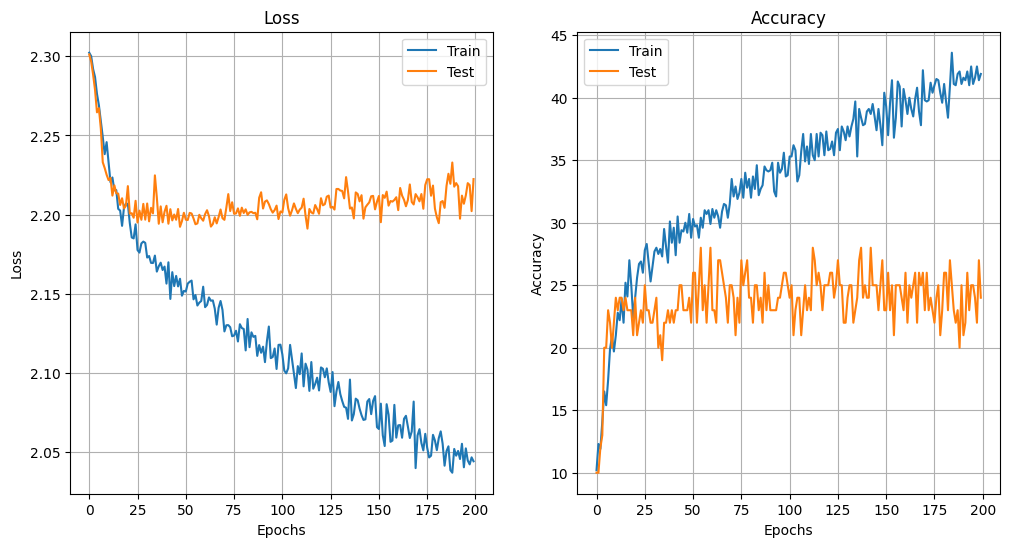

In [33]:
cnn_rms_drop = CNN_Torch_Drop(dropout=0.5)
rms = torch.optim.RMSprop(cnn_rms_drop.parameters(), lr=0.001, alpha=0.9)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(rms,
                                                                         cnn_rms_drop,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 30.85it/s]


Epoch 1/200, Train Loss: 2.3020, Test Loss: 2.3023, Train Accuracy: 10.70%, Test Accuracy: 12.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 38.57it/s]


Epoch 2/200, Train Loss: 2.3011, Test Loss: 2.3015, Train Accuracy: 10.80%, Test Accuracy: 10.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 35.58it/s]


Epoch 3/200, Train Loss: 2.3024, Test Loss: 2.3014, Train Accuracy: 9.80%, Test Accuracy: 10.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 39.96it/s]


Epoch 4/200, Train Loss: 2.3023, Test Loss: 2.3004, Train Accuracy: 10.40%, Test Accuracy: 13.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 37.51it/s]


Epoch 5/200, Train Loss: 2.2996, Test Loss: 2.2984, Train Accuracy: 10.90%, Test Accuracy: 16.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 32.81it/s]


Epoch 6/200, Train Loss: 2.2994, Test Loss: 2.2961, Train Accuracy: 11.20%, Test Accuracy: 11.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 35.55it/s]


Epoch 7/200, Train Loss: 2.2969, Test Loss: 2.2924, Train Accuracy: 11.90%, Test Accuracy: 17.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 41.72it/s]


Epoch 8/200, Train Loss: 2.2980, Test Loss: 2.2898, Train Accuracy: 12.70%, Test Accuracy: 16.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 35.23it/s]


Epoch 9/200, Train Loss: 2.2898, Test Loss: 2.2847, Train Accuracy: 13.50%, Test Accuracy: 22.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 30.00it/s]


Epoch 10/200, Train Loss: 2.2861, Test Loss: 2.2776, Train Accuracy: 13.10%, Test Accuracy: 22.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 38.12it/s]


Epoch 11/200, Train Loss: 2.2862, Test Loss: 2.2722, Train Accuracy: 12.60%, Test Accuracy: 20.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 40.92it/s]


Epoch 12/200, Train Loss: 2.2802, Test Loss: 2.2648, Train Accuracy: 14.40%, Test Accuracy: 19.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 41.70it/s]


Epoch 13/200, Train Loss: 2.2733, Test Loss: 2.2585, Train Accuracy: 15.40%, Test Accuracy: 20.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 35.27it/s]


Epoch 14/200, Train Loss: 2.2669, Test Loss: 2.2521, Train Accuracy: 16.70%, Test Accuracy: 22.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 36.91it/s]


Epoch 15/200, Train Loss: 2.2661, Test Loss: 2.2481, Train Accuracy: 16.10%, Test Accuracy: 22.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 41.15it/s]


Epoch 16/200, Train Loss: 2.2629, Test Loss: 2.2459, Train Accuracy: 16.40%, Test Accuracy: 22.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 40.15it/s]


Epoch 17/200, Train Loss: 2.2613, Test Loss: 2.2425, Train Accuracy: 17.50%, Test Accuracy: 23.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 36.29it/s]


Epoch 18/200, Train Loss: 2.2516, Test Loss: 2.2437, Train Accuracy: 19.30%, Test Accuracy: 20.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 38.87it/s]


Epoch 19/200, Train Loss: 2.2603, Test Loss: 2.2343, Train Accuracy: 16.40%, Test Accuracy: 21.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 38.16it/s]


Epoch 20/200, Train Loss: 2.2500, Test Loss: 2.2309, Train Accuracy: 18.80%, Test Accuracy: 23.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 38.49it/s]


Epoch 21/200, Train Loss: 2.2606, Test Loss: 2.2312, Train Accuracy: 16.90%, Test Accuracy: 20.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 38.63it/s]


Epoch 22/200, Train Loss: 2.2518, Test Loss: 2.2290, Train Accuracy: 18.00%, Test Accuracy: 19.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 38.03it/s]


Epoch 23/200, Train Loss: 2.2503, Test Loss: 2.2374, Train Accuracy: 19.30%, Test Accuracy: 19.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 35.20it/s]


Epoch 24/200, Train Loss: 2.2458, Test Loss: 2.2287, Train Accuracy: 17.90%, Test Accuracy: 22.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 39.77it/s]


Epoch 25/200, Train Loss: 2.2456, Test Loss: 2.2302, Train Accuracy: 17.30%, Test Accuracy: 22.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 32.18it/s]


Epoch 26/200, Train Loss: 2.2491, Test Loss: 2.2250, Train Accuracy: 17.80%, Test Accuracy: 21.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 32.65it/s]


Epoch 27/200, Train Loss: 2.2458, Test Loss: 2.2207, Train Accuracy: 18.60%, Test Accuracy: 21.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 28.38it/s]


Epoch 28/200, Train Loss: 2.2478, Test Loss: 2.2284, Train Accuracy: 19.20%, Test Accuracy: 23.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 30.13it/s]


Epoch 29/200, Train Loss: 2.2337, Test Loss: 2.2220, Train Accuracy: 21.00%, Test Accuracy: 22.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 31.97it/s]


Epoch 30/200, Train Loss: 2.2340, Test Loss: 2.2192, Train Accuracy: 18.90%, Test Accuracy: 24.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 31.16it/s]


Epoch 31/200, Train Loss: 2.2424, Test Loss: 2.2298, Train Accuracy: 18.60%, Test Accuracy: 20.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 32.19it/s]


Epoch 32/200, Train Loss: 2.2343, Test Loss: 2.2179, Train Accuracy: 20.40%, Test Accuracy: 22.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 33.64it/s]


Epoch 33/200, Train Loss: 2.2382, Test Loss: 2.2155, Train Accuracy: 19.00%, Test Accuracy: 19.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 41.54it/s]


Epoch 34/200, Train Loss: 2.2306, Test Loss: 2.2133, Train Accuracy: 20.40%, Test Accuracy: 22.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 31.78it/s]


Epoch 35/200, Train Loss: 2.2325, Test Loss: 2.2200, Train Accuracy: 20.70%, Test Accuracy: 20.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 39.10it/s]


Epoch 36/200, Train Loss: 2.2414, Test Loss: 2.2230, Train Accuracy: 18.70%, Test Accuracy: 22.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 36.09it/s]


Epoch 37/200, Train Loss: 2.2331, Test Loss: 2.2153, Train Accuracy: 20.20%, Test Accuracy: 21.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 42.04it/s]


Epoch 38/200, Train Loss: 2.2271, Test Loss: 2.2082, Train Accuracy: 20.20%, Test Accuracy: 21.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 31.20it/s]


Epoch 39/200, Train Loss: 2.2369, Test Loss: 2.2128, Train Accuracy: 21.00%, Test Accuracy: 22.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 30.81it/s]


Epoch 40/200, Train Loss: 2.2336, Test Loss: 2.2116, Train Accuracy: 21.00%, Test Accuracy: 23.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 37.62it/s]


Epoch 41/200, Train Loss: 2.2286, Test Loss: 2.2142, Train Accuracy: 21.30%, Test Accuracy: 22.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 41.83it/s]


Epoch 42/200, Train Loss: 2.2328, Test Loss: 2.2108, Train Accuracy: 18.70%, Test Accuracy: 20.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 39.49it/s]


Epoch 43/200, Train Loss: 2.2290, Test Loss: 2.2076, Train Accuracy: 21.80%, Test Accuracy: 23.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 33.59it/s]


Epoch 44/200, Train Loss: 2.2267, Test Loss: 2.2047, Train Accuracy: 21.70%, Test Accuracy: 22.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 41.18it/s]


Epoch 45/200, Train Loss: 2.2244, Test Loss: 2.2069, Train Accuracy: 20.60%, Test Accuracy: 22.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 47.10it/s]


Epoch 46/200, Train Loss: 2.2322, Test Loss: 2.2163, Train Accuracy: 20.80%, Test Accuracy: 19.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 39.54it/s]


Epoch 47/200, Train Loss: 2.2263, Test Loss: 2.2059, Train Accuracy: 20.70%, Test Accuracy: 21.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 38.41it/s]


Epoch 48/200, Train Loss: 2.2250, Test Loss: 2.2024, Train Accuracy: 20.20%, Test Accuracy: 24.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 52.32it/s]


Epoch 49/200, Train Loss: 2.2094, Test Loss: 2.2004, Train Accuracy: 23.10%, Test Accuracy: 23.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 43.31it/s]


Epoch 50/200, Train Loss: 2.2236, Test Loss: 2.2064, Train Accuracy: 20.80%, Test Accuracy: 24.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 39.52it/s]


Epoch 51/200, Train Loss: 2.2111, Test Loss: 2.2023, Train Accuracy: 22.40%, Test Accuracy: 23.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 36.81it/s]


Epoch 52/200, Train Loss: 2.2061, Test Loss: 2.2014, Train Accuracy: 24.20%, Test Accuracy: 23.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 35.11it/s]


Epoch 53/200, Train Loss: 2.2246, Test Loss: 2.2186, Train Accuracy: 21.30%, Test Accuracy: 23.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 28.68it/s]


Epoch 54/200, Train Loss: 2.2190, Test Loss: 2.2036, Train Accuracy: 20.60%, Test Accuracy: 21.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 34.35it/s]


Epoch 55/200, Train Loss: 2.2257, Test Loss: 2.2016, Train Accuracy: 21.90%, Test Accuracy: 24.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 40.44it/s]


Epoch 56/200, Train Loss: 2.2247, Test Loss: 2.2020, Train Accuracy: 22.20%, Test Accuracy: 23.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 43.67it/s]


Epoch 57/200, Train Loss: 2.2112, Test Loss: 2.2010, Train Accuracy: 21.90%, Test Accuracy: 25.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 43.60it/s]


Epoch 58/200, Train Loss: 2.2166, Test Loss: 2.2004, Train Accuracy: 21.70%, Test Accuracy: 22.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 42.59it/s]


Epoch 59/200, Train Loss: 2.2145, Test Loss: 2.1997, Train Accuracy: 21.50%, Test Accuracy: 26.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 40.55it/s]


Epoch 60/200, Train Loss: 2.2119, Test Loss: 2.2015, Train Accuracy: 21.60%, Test Accuracy: 23.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 39.99it/s]


Epoch 61/200, Train Loss: 2.2104, Test Loss: 2.1948, Train Accuracy: 21.70%, Test Accuracy: 23.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 38.85it/s]


Epoch 62/200, Train Loss: 2.2152, Test Loss: 2.1961, Train Accuracy: 22.00%, Test Accuracy: 24.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 40.90it/s]


Epoch 63/200, Train Loss: 2.2082, Test Loss: 2.1980, Train Accuracy: 23.50%, Test Accuracy: 21.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 44.47it/s]


Epoch 64/200, Train Loss: 2.2145, Test Loss: 2.1923, Train Accuracy: 21.80%, Test Accuracy: 28.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 43.06it/s]


Epoch 65/200, Train Loss: 2.2101, Test Loss: 2.1978, Train Accuracy: 23.10%, Test Accuracy: 23.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 42.87it/s]


Epoch 66/200, Train Loss: 2.2183, Test Loss: 2.1946, Train Accuracy: 21.00%, Test Accuracy: 22.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 40.32it/s]


Epoch 67/200, Train Loss: 2.2151, Test Loss: 2.2000, Train Accuracy: 22.10%, Test Accuracy: 23.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 35.37it/s]


Epoch 68/200, Train Loss: 2.2140, Test Loss: 2.2010, Train Accuracy: 22.20%, Test Accuracy: 24.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 39.58it/s]


Epoch 69/200, Train Loss: 2.1986, Test Loss: 2.2055, Train Accuracy: 23.00%, Test Accuracy: 23.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 39.82it/s]


Epoch 70/200, Train Loss: 2.2252, Test Loss: 2.2048, Train Accuracy: 20.70%, Test Accuracy: 23.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 35.84it/s]


Epoch 71/200, Train Loss: 2.2007, Test Loss: 2.2007, Train Accuracy: 23.80%, Test Accuracy: 25.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 35.98it/s]


Epoch 72/200, Train Loss: 2.2098, Test Loss: 2.2027, Train Accuracy: 21.80%, Test Accuracy: 24.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 35.01it/s]


Epoch 73/200, Train Loss: 2.2146, Test Loss: 2.1974, Train Accuracy: 22.00%, Test Accuracy: 24.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 32.09it/s]


Epoch 74/200, Train Loss: 2.2067, Test Loss: 2.2048, Train Accuracy: 22.00%, Test Accuracy: 23.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 37.63it/s]


Epoch 75/200, Train Loss: 2.1941, Test Loss: 2.2016, Train Accuracy: 23.40%, Test Accuracy: 22.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 41.60it/s]


Epoch 76/200, Train Loss: 2.2015, Test Loss: 2.1983, Train Accuracy: 24.10%, Test Accuracy: 22.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 43.01it/s]


Epoch 77/200, Train Loss: 2.2069, Test Loss: 2.2001, Train Accuracy: 23.30%, Test Accuracy: 21.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 42.95it/s]


Epoch 78/200, Train Loss: 2.1928, Test Loss: 2.2067, Train Accuracy: 25.00%, Test Accuracy: 23.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 39.32it/s]


Epoch 79/200, Train Loss: 2.2021, Test Loss: 2.1944, Train Accuracy: 23.90%, Test Accuracy: 25.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 44.24it/s]


Epoch 80/200, Train Loss: 2.2070, Test Loss: 2.2093, Train Accuracy: 22.30%, Test Accuracy: 21.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 44.77it/s]


Epoch 81/200, Train Loss: 2.2072, Test Loss: 2.2045, Train Accuracy: 21.90%, Test Accuracy: 22.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 44.26it/s]


Epoch 82/200, Train Loss: 2.2055, Test Loss: 2.2030, Train Accuracy: 22.70%, Test Accuracy: 22.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 42.64it/s]


Epoch 83/200, Train Loss: 2.2108, Test Loss: 2.2056, Train Accuracy: 21.60%, Test Accuracy: 21.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 41.42it/s]


Epoch 84/200, Train Loss: 2.1978, Test Loss: 2.2006, Train Accuracy: 22.90%, Test Accuracy: 22.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 42.42it/s]


Epoch 85/200, Train Loss: 2.2184, Test Loss: 2.1987, Train Accuracy: 22.20%, Test Accuracy: 24.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 42.14it/s]


Epoch 86/200, Train Loss: 2.2067, Test Loss: 2.1940, Train Accuracy: 22.10%, Test Accuracy: 26.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 42.46it/s]


Epoch 87/200, Train Loss: 2.2004, Test Loss: 2.2003, Train Accuracy: 23.60%, Test Accuracy: 23.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 45.64it/s]


Epoch 88/200, Train Loss: 2.1924, Test Loss: 2.1953, Train Accuracy: 23.40%, Test Accuracy: 26.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 31.79it/s]


Epoch 89/200, Train Loss: 2.1992, Test Loss: 2.1976, Train Accuracy: 22.90%, Test Accuracy: 25.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 41.92it/s]


Epoch 90/200, Train Loss: 2.2054, Test Loss: 2.2129, Train Accuracy: 22.80%, Test Accuracy: 23.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 46.00it/s]


Epoch 91/200, Train Loss: 2.2036, Test Loss: 2.2008, Train Accuracy: 24.00%, Test Accuracy: 22.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 41.07it/s]


Epoch 92/200, Train Loss: 2.2020, Test Loss: 2.2016, Train Accuracy: 22.60%, Test Accuracy: 24.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 44.11it/s]


Epoch 93/200, Train Loss: 2.1955, Test Loss: 2.1896, Train Accuracy: 24.20%, Test Accuracy: 26.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 40.92it/s]


Epoch 94/200, Train Loss: 2.2092, Test Loss: 2.1927, Train Accuracy: 21.90%, Test Accuracy: 23.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 44.17it/s]


Epoch 95/200, Train Loss: 2.1940, Test Loss: 2.1932, Train Accuracy: 24.20%, Test Accuracy: 24.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 38.63it/s]


Epoch 96/200, Train Loss: 2.1975, Test Loss: 2.1906, Train Accuracy: 23.00%, Test Accuracy: 25.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 34.75it/s]


Epoch 97/200, Train Loss: 2.1905, Test Loss: 2.1926, Train Accuracy: 24.30%, Test Accuracy: 26.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 37.96it/s]


Epoch 98/200, Train Loss: 2.2017, Test Loss: 2.1946, Train Accuracy: 21.80%, Test Accuracy: 27.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 44.63it/s]


Epoch 99/200, Train Loss: 2.1975, Test Loss: 2.2040, Train Accuracy: 22.00%, Test Accuracy: 21.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 42.93it/s]


Epoch 100/200, Train Loss: 2.1977, Test Loss: 2.1970, Train Accuracy: 23.40%, Test Accuracy: 24.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 42.60it/s]


Epoch 101/200, Train Loss: 2.1930, Test Loss: 2.1946, Train Accuracy: 24.70%, Test Accuracy: 25.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 44.48it/s]


Epoch 102/200, Train Loss: 2.1939, Test Loss: 2.1974, Train Accuracy: 24.60%, Test Accuracy: 24.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 41.30it/s]


Epoch 103/200, Train Loss: 2.1718, Test Loss: 2.2094, Train Accuracy: 27.20%, Test Accuracy: 25.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 42.05it/s]


Epoch 104/200, Train Loss: 2.1973, Test Loss: 2.1923, Train Accuracy: 24.10%, Test Accuracy: 27.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 37.09it/s]


Epoch 105/200, Train Loss: 2.1916, Test Loss: 2.1954, Train Accuracy: 26.00%, Test Accuracy: 27.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 45.32it/s]


Epoch 106/200, Train Loss: 2.1913, Test Loss: 2.1967, Train Accuracy: 24.30%, Test Accuracy: 26.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 40.38it/s]


Epoch 107/200, Train Loss: 2.1839, Test Loss: 2.2005, Train Accuracy: 25.40%, Test Accuracy: 23.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 48.67it/s]


Epoch 108/200, Train Loss: 2.2030, Test Loss: 2.1999, Train Accuracy: 22.80%, Test Accuracy: 20.00%


Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 38.28it/s]


Epoch 109/200, Train Loss: 2.1856, Test Loss: 2.1977, Train Accuracy: 24.10%, Test Accuracy: 25.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 38.20it/s]


Epoch 110/200, Train Loss: 2.1810, Test Loss: 2.1954, Train Accuracy: 25.50%, Test Accuracy: 25.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 35.63it/s]


Epoch 111/200, Train Loss: 2.1830, Test Loss: 2.2040, Train Accuracy: 25.10%, Test Accuracy: 21.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 39.92it/s]


Epoch 112/200, Train Loss: 2.1870, Test Loss: 2.2015, Train Accuracy: 24.10%, Test Accuracy: 23.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 39.08it/s]


Epoch 113/200, Train Loss: 2.1940, Test Loss: 2.2016, Train Accuracy: 24.40%, Test Accuracy: 25.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 33.46it/s]


Epoch 114/200, Train Loss: 2.1894, Test Loss: 2.1772, Train Accuracy: 25.00%, Test Accuracy: 29.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 37.13it/s]


Epoch 115/200, Train Loss: 2.1881, Test Loss: 2.1973, Train Accuracy: 25.30%, Test Accuracy: 26.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 38.45it/s]


Epoch 116/200, Train Loss: 2.1875, Test Loss: 2.1760, Train Accuracy: 25.40%, Test Accuracy: 29.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 43.11it/s]


Epoch 117/200, Train Loss: 2.1960, Test Loss: 2.2049, Train Accuracy: 25.20%, Test Accuracy: 24.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 34.98it/s]


Epoch 118/200, Train Loss: 2.1843, Test Loss: 2.1883, Train Accuracy: 25.00%, Test Accuracy: 25.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 36.61it/s]


Epoch 119/200, Train Loss: 2.1891, Test Loss: 2.2048, Train Accuracy: 25.60%, Test Accuracy: 23.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 39.89it/s]


Epoch 120/200, Train Loss: 2.1817, Test Loss: 2.1896, Train Accuracy: 25.60%, Test Accuracy: 27.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 39.11it/s]


Epoch 121/200, Train Loss: 2.1810, Test Loss: 2.1968, Train Accuracy: 25.90%, Test Accuracy: 24.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 41.40it/s]


Epoch 122/200, Train Loss: 2.1914, Test Loss: 2.1901, Train Accuracy: 26.10%, Test Accuracy: 28.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 43.67it/s]


Epoch 123/200, Train Loss: 2.1795, Test Loss: 2.1851, Train Accuracy: 25.40%, Test Accuracy: 27.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 41.51it/s]


Epoch 124/200, Train Loss: 2.1784, Test Loss: 2.1853, Train Accuracy: 25.90%, Test Accuracy: 29.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 37.99it/s]


Epoch 125/200, Train Loss: 2.1940, Test Loss: 2.1948, Train Accuracy: 24.20%, Test Accuracy: 23.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 37.76it/s]


Epoch 126/200, Train Loss: 2.1877, Test Loss: 2.1923, Train Accuracy: 25.10%, Test Accuracy: 25.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 27.73it/s]


Epoch 127/200, Train Loss: 2.1796, Test Loss: 2.2173, Train Accuracy: 25.50%, Test Accuracy: 20.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 40.69it/s]


Epoch 128/200, Train Loss: 2.1834, Test Loss: 2.2103, Train Accuracy: 26.40%, Test Accuracy: 21.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 40.86it/s]


Epoch 129/200, Train Loss: 2.1924, Test Loss: 2.2032, Train Accuracy: 25.70%, Test Accuracy: 22.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 30.30it/s]


Epoch 130/200, Train Loss: 2.1733, Test Loss: 2.2203, Train Accuracy: 26.60%, Test Accuracy: 19.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 37.05it/s]


Epoch 131/200, Train Loss: 2.1753, Test Loss: 2.2208, Train Accuracy: 27.80%, Test Accuracy: 22.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 37.31it/s]


Epoch 132/200, Train Loss: 2.1824, Test Loss: 2.1937, Train Accuracy: 26.30%, Test Accuracy: 26.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 36.78it/s]


Epoch 133/200, Train Loss: 2.1662, Test Loss: 2.2089, Train Accuracy: 28.80%, Test Accuracy: 21.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 39.24it/s]


Epoch 134/200, Train Loss: 2.1721, Test Loss: 2.2009, Train Accuracy: 27.70%, Test Accuracy: 24.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 39.50it/s]


Epoch 135/200, Train Loss: 2.1817, Test Loss: 2.1961, Train Accuracy: 26.40%, Test Accuracy: 26.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 41.93it/s]


Epoch 136/200, Train Loss: 2.1885, Test Loss: 2.1959, Train Accuracy: 23.70%, Test Accuracy: 25.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 36.28it/s]


Epoch 137/200, Train Loss: 2.1635, Test Loss: 2.2079, Train Accuracy: 27.50%, Test Accuracy: 22.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 41.01it/s]


Epoch 138/200, Train Loss: 2.1848, Test Loss: 2.1874, Train Accuracy: 24.50%, Test Accuracy: 24.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 44.03it/s]


Epoch 139/200, Train Loss: 2.1733, Test Loss: 2.1876, Train Accuracy: 26.20%, Test Accuracy: 27.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 32.15it/s]


Epoch 140/200, Train Loss: 2.1786, Test Loss: 2.1843, Train Accuracy: 26.10%, Test Accuracy: 29.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 30.56it/s]


Epoch 141/200, Train Loss: 2.1660, Test Loss: 2.1949, Train Accuracy: 27.30%, Test Accuracy: 24.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 35.57it/s]


Epoch 142/200, Train Loss: 2.1813, Test Loss: 2.1923, Train Accuracy: 26.40%, Test Accuracy: 22.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 39.12it/s]


Epoch 143/200, Train Loss: 2.1706, Test Loss: 2.2045, Train Accuracy: 26.40%, Test Accuracy: 21.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 39.79it/s]


Epoch 144/200, Train Loss: 2.1775, Test Loss: 2.1869, Train Accuracy: 26.60%, Test Accuracy: 24.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 36.90it/s]


Epoch 145/200, Train Loss: 2.1717, Test Loss: 2.1906, Train Accuracy: 26.80%, Test Accuracy: 23.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 31.33it/s]


Epoch 146/200, Train Loss: 2.1677, Test Loss: 2.1836, Train Accuracy: 27.10%, Test Accuracy: 26.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 27.22it/s]


Epoch 147/200, Train Loss: 2.1751, Test Loss: 2.1977, Train Accuracy: 26.70%, Test Accuracy: 24.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 30.50it/s]


Epoch 148/200, Train Loss: 2.1825, Test Loss: 2.1973, Train Accuracy: 25.90%, Test Accuracy: 23.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 34.39it/s]


Epoch 149/200, Train Loss: 2.1759, Test Loss: 2.1901, Train Accuracy: 25.80%, Test Accuracy: 24.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 38.35it/s]


Epoch 150/200, Train Loss: 2.1575, Test Loss: 2.1757, Train Accuracy: 29.40%, Test Accuracy: 29.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 42.56it/s]


Epoch 151/200, Train Loss: 2.1759, Test Loss: 2.1740, Train Accuracy: 25.10%, Test Accuracy: 25.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 34.45it/s]


Epoch 152/200, Train Loss: 2.1825, Test Loss: 2.1869, Train Accuracy: 25.20%, Test Accuracy: 24.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 37.69it/s]


Epoch 153/200, Train Loss: 2.1789, Test Loss: 2.1875, Train Accuracy: 25.30%, Test Accuracy: 27.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 42.42it/s]


Epoch 154/200, Train Loss: 2.1765, Test Loss: 2.2113, Train Accuracy: 25.80%, Test Accuracy: 20.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 37.05it/s]


Epoch 155/200, Train Loss: 2.1701, Test Loss: 2.1913, Train Accuracy: 26.80%, Test Accuracy: 25.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 35.97it/s]


Epoch 156/200, Train Loss: 2.1684, Test Loss: 2.1998, Train Accuracy: 27.10%, Test Accuracy: 25.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 39.38it/s]


Epoch 157/200, Train Loss: 2.1637, Test Loss: 2.1800, Train Accuracy: 28.50%, Test Accuracy: 27.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 37.39it/s]


Epoch 158/200, Train Loss: 2.1709, Test Loss: 2.1951, Train Accuracy: 26.00%, Test Accuracy: 23.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 36.92it/s]


Epoch 159/200, Train Loss: 2.1567, Test Loss: 2.1824, Train Accuracy: 29.00%, Test Accuracy: 24.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 34.30it/s]


Epoch 160/200, Train Loss: 2.1676, Test Loss: 2.2013, Train Accuracy: 26.90%, Test Accuracy: 24.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 41.36it/s]


Epoch 161/200, Train Loss: 2.1502, Test Loss: 2.2027, Train Accuracy: 29.20%, Test Accuracy: 24.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 37.92it/s]


Epoch 162/200, Train Loss: 2.1689, Test Loss: 2.1900, Train Accuracy: 27.10%, Test Accuracy: 25.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 37.77it/s]


Epoch 163/200, Train Loss: 2.1726, Test Loss: 2.1878, Train Accuracy: 27.10%, Test Accuracy: 26.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 34.26it/s]


Epoch 164/200, Train Loss: 2.1684, Test Loss: 2.1798, Train Accuracy: 27.20%, Test Accuracy: 28.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 28.94it/s]


Epoch 165/200, Train Loss: 2.1601, Test Loss: 2.2007, Train Accuracy: 29.10%, Test Accuracy: 22.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Epoch 166/200, Train Loss: 2.1669, Test Loss: 2.1859, Train Accuracy: 26.70%, Test Accuracy: 24.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 36.36it/s]


Epoch 167/200, Train Loss: 2.1631, Test Loss: 2.2225, Train Accuracy: 27.30%, Test Accuracy: 22.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 44.04it/s]


Epoch 168/200, Train Loss: 2.1715, Test Loss: 2.1918, Train Accuracy: 27.30%, Test Accuracy: 24.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 46.34it/s]


Epoch 169/200, Train Loss: 2.1629, Test Loss: 2.2004, Train Accuracy: 27.60%, Test Accuracy: 23.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 48.99it/s]


Epoch 170/200, Train Loss: 2.1591, Test Loss: 2.2048, Train Accuracy: 28.30%, Test Accuracy: 21.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 38.59it/s]


Epoch 171/200, Train Loss: 2.1647, Test Loss: 2.1924, Train Accuracy: 28.50%, Test Accuracy: 28.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 44.72it/s]


Epoch 172/200, Train Loss: 2.1737, Test Loss: 2.1848, Train Accuracy: 27.20%, Test Accuracy: 27.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 39.56it/s]


Epoch 173/200, Train Loss: 2.1747, Test Loss: 2.1911, Train Accuracy: 26.10%, Test Accuracy: 25.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 42.53it/s]


Epoch 174/200, Train Loss: 2.1617, Test Loss: 2.2063, Train Accuracy: 28.30%, Test Accuracy: 21.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 43.87it/s]


Epoch 175/200, Train Loss: 2.1685, Test Loss: 2.1830, Train Accuracy: 27.50%, Test Accuracy: 25.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 37.27it/s]


Epoch 176/200, Train Loss: 2.1608, Test Loss: 2.1807, Train Accuracy: 27.40%, Test Accuracy: 26.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 40.85it/s]


Epoch 177/200, Train Loss: 2.1695, Test Loss: 2.1855, Train Accuracy: 27.30%, Test Accuracy: 24.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 38.45it/s]


Epoch 178/200, Train Loss: 2.1609, Test Loss: 2.1815, Train Accuracy: 28.40%, Test Accuracy: 25.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 38.61it/s]


Epoch 179/200, Train Loss: 2.1641, Test Loss: 2.1787, Train Accuracy: 28.00%, Test Accuracy: 26.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 40.80it/s]


Epoch 180/200, Train Loss: 2.1572, Test Loss: 2.1753, Train Accuracy: 28.00%, Test Accuracy: 28.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 43.18it/s]


Epoch 181/200, Train Loss: 2.1583, Test Loss: 2.1865, Train Accuracy: 29.40%, Test Accuracy: 28.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 44.04it/s]


Epoch 182/200, Train Loss: 2.1587, Test Loss: 2.1810, Train Accuracy: 29.20%, Test Accuracy: 27.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 29.84it/s]


Epoch 183/200, Train Loss: 2.1620, Test Loss: 2.1722, Train Accuracy: 28.80%, Test Accuracy: 27.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 36.61it/s]


Epoch 184/200, Train Loss: 2.1598, Test Loss: 2.1773, Train Accuracy: 27.60%, Test Accuracy: 27.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 38.12it/s]


Epoch 185/200, Train Loss: 2.1612, Test Loss: 2.1953, Train Accuracy: 27.40%, Test Accuracy: 27.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 40.27it/s]


Epoch 186/200, Train Loss: 2.1531, Test Loss: 2.1937, Train Accuracy: 29.20%, Test Accuracy: 28.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 41.46it/s]


Epoch 187/200, Train Loss: 2.1706, Test Loss: 2.1990, Train Accuracy: 26.90%, Test Accuracy: 25.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 43.21it/s]


Epoch 188/200, Train Loss: 2.1584, Test Loss: 2.1936, Train Accuracy: 28.80%, Test Accuracy: 25.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 39.72it/s]


Epoch 189/200, Train Loss: 2.1594, Test Loss: 2.2140, Train Accuracy: 29.40%, Test Accuracy: 25.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 39.88it/s]


Epoch 190/200, Train Loss: 2.1771, Test Loss: 2.1723, Train Accuracy: 25.40%, Test Accuracy: 28.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 36.64it/s]


Epoch 191/200, Train Loss: 2.1502, Test Loss: 2.1891, Train Accuracy: 28.60%, Test Accuracy: 27.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 42.72it/s]


Epoch 192/200, Train Loss: 2.1608, Test Loss: 2.1840, Train Accuracy: 28.20%, Test Accuracy: 23.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 42.36it/s]


Epoch 193/200, Train Loss: 2.1582, Test Loss: 2.1827, Train Accuracy: 27.70%, Test Accuracy: 24.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 35.14it/s]


Epoch 194/200, Train Loss: 2.1548, Test Loss: 2.1788, Train Accuracy: 29.30%, Test Accuracy: 25.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 31.21it/s]


Epoch 195/200, Train Loss: 2.1578, Test Loss: 2.2077, Train Accuracy: 27.60%, Test Accuracy: 20.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 40.83it/s]


Epoch 196/200, Train Loss: 2.1604, Test Loss: 2.1784, Train Accuracy: 28.00%, Test Accuracy: 28.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 36.91it/s]


Epoch 197/200, Train Loss: 2.1592, Test Loss: 2.1795, Train Accuracy: 27.80%, Test Accuracy: 30.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 41.07it/s]


Epoch 198/200, Train Loss: 2.1523, Test Loss: 2.2027, Train Accuracy: 28.60%, Test Accuracy: 25.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 39.55it/s]


Epoch 199/200, Train Loss: 2.1652, Test Loss: 2.2334, Train Accuracy: 28.70%, Test Accuracy: 20.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 38.80it/s]


Epoch 200/200, Train Loss: 2.1492, Test Loss: 2.1829, Train Accuracy: 29.30%, Test Accuracy: 29.00%


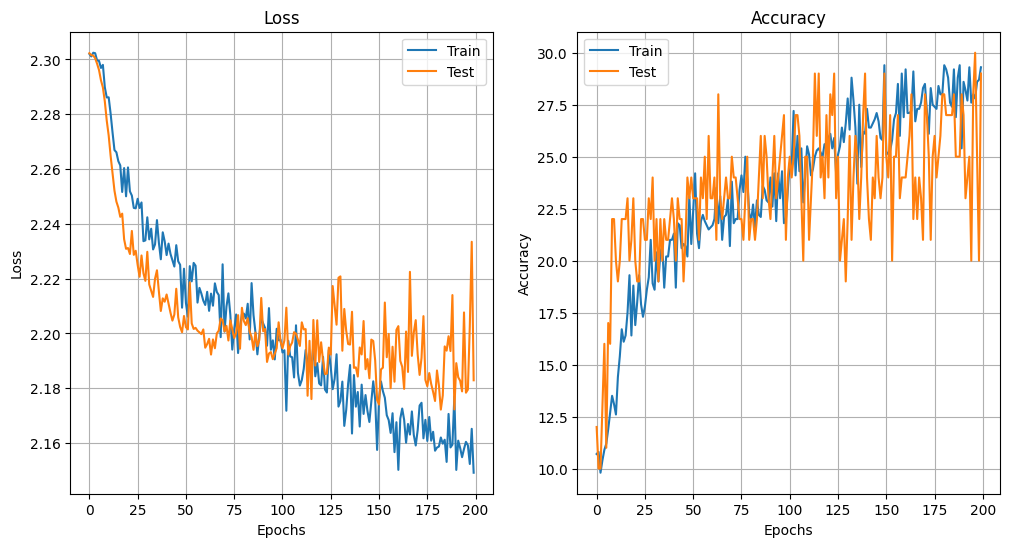

In [34]:
cnn_rms_drop = CNN_Torch_Drop(dropout=0.8)
rms = torch.optim.RMSprop(cnn_rms_drop.parameters(), lr=0.001, alpha=0.9)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(rms,
                                                                         cnn_rms_drop,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

|**Dropout**|**Train Accuracy**|**Test Accuracy**|
|-----------|------------------|-----------------|
| 0.2      | 55.10%           | 28.00%          |
| 0.5      | 41.90%           | 24.00%          |
| 0.8      | 29.30%           | 29.00%          |

**Observations:**
- $0.2$ dropout rate is the most optimal because it is able to learn the features of the images and is able to generalize relatively well.
- Using a very high dropout rate (like $0.8$) results in underfitting since the most of the features are dropped during training.

### 2.6 Apply Batch Normalization

In [35]:
class CNN_Drop_BN(nn.Module):
    def __init__(self, dropout = 0.2):
        super(CNN_Drop_BN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=4 * 8 * 8, out_features=49)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Batch normalization layer
        self.bn = nn.BatchNorm1d(num_features=49)

        self.fc2 = nn.Linear(in_features=49, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 4 * 8 * 8)  # Flatten the tensor
        x = self.fc1(x)
        # Apply batch normalization before the activation function
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

Epoch 1/200:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 29.09it/s]


Epoch 1/200, Train Loss: 2.2799, Test Loss: 2.3019, Train Accuracy: 19.70%, Test Accuracy: 13.00%


Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 47.45it/s]


Epoch 2/200, Train Loss: 2.2423, Test Loss: 2.2982, Train Accuracy: 26.90%, Test Accuracy: 10.00%


Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 48.05it/s]


Epoch 3/200, Train Loss: 2.2228, Test Loss: 2.2937, Train Accuracy: 29.10%, Test Accuracy: 22.00%


Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 43.84it/s]


Epoch 4/200, Train Loss: 2.2042, Test Loss: 2.2868, Train Accuracy: 30.80%, Test Accuracy: 20.00%


Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 44.05it/s]


Epoch 5/200, Train Loss: 2.1886, Test Loss: 2.2618, Train Accuracy: 34.20%, Test Accuracy: 23.00%


Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 43.50it/s]


Epoch 6/200, Train Loss: 2.1727, Test Loss: 2.2524, Train Accuracy: 36.30%, Test Accuracy: 25.00%


Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 38.83it/s]


Epoch 7/200, Train Loss: 2.1571, Test Loss: 2.2185, Train Accuracy: 38.00%, Test Accuracy: 34.00%


Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 44.55it/s]


Epoch 8/200, Train Loss: 2.1364, Test Loss: 2.2300, Train Accuracy: 40.20%, Test Accuracy: 16.00%


Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 42.46it/s]


Epoch 9/200, Train Loss: 2.1247, Test Loss: 2.1737, Train Accuracy: 41.70%, Test Accuracy: 31.00%


Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 43.33it/s]


Epoch 10/200, Train Loss: 2.1143, Test Loss: 2.1721, Train Accuracy: 41.50%, Test Accuracy: 34.00%


Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 44.55it/s]


Epoch 11/200, Train Loss: 2.1014, Test Loss: 2.1610, Train Accuracy: 43.80%, Test Accuracy: 35.00%


Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 43.52it/s]


Epoch 12/200, Train Loss: 2.0863, Test Loss: 2.1611, Train Accuracy: 44.70%, Test Accuracy: 37.00%


Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 38.08it/s]


Epoch 13/200, Train Loss: 2.0763, Test Loss: 2.1621, Train Accuracy: 44.30%, Test Accuracy: 29.00%


Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 39.54it/s]


Epoch 14/200, Train Loss: 2.0681, Test Loss: 2.1535, Train Accuracy: 45.90%, Test Accuracy: 31.00%


Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 41.08it/s]


Epoch 15/200, Train Loss: 2.0485, Test Loss: 2.1563, Train Accuracy: 48.70%, Test Accuracy: 31.00%


Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 39.09it/s]


Epoch 16/200, Train Loss: 2.0399, Test Loss: 2.1583, Train Accuracy: 49.10%, Test Accuracy: 30.00%


Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 40.69it/s]


Epoch 17/200, Train Loss: 2.0255, Test Loss: 2.1575, Train Accuracy: 50.10%, Test Accuracy: 33.00%


Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 40.37it/s]


Epoch 18/200, Train Loss: 2.0221, Test Loss: 2.1400, Train Accuracy: 50.50%, Test Accuracy: 32.00%


Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 42.12it/s]


Epoch 19/200, Train Loss: 2.0045, Test Loss: 2.1467, Train Accuracy: 52.10%, Test Accuracy: 30.00%


Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 35.84it/s]


Epoch 20/200, Train Loss: 1.9938, Test Loss: 2.1473, Train Accuracy: 54.20%, Test Accuracy: 31.00%


Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 38.56it/s]


Epoch 21/200, Train Loss: 1.9851, Test Loss: 2.1379, Train Accuracy: 54.20%, Test Accuracy: 32.00%


Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 41.12it/s]


Epoch 22/200, Train Loss: 1.9784, Test Loss: 2.1519, Train Accuracy: 53.60%, Test Accuracy: 28.00%


Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 47.05it/s]


Epoch 23/200, Train Loss: 1.9666, Test Loss: 2.1512, Train Accuracy: 55.90%, Test Accuracy: 31.00%


Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 43.39it/s]


Epoch 24/200, Train Loss: 1.9428, Test Loss: 2.1364, Train Accuracy: 59.20%, Test Accuracy: 33.00%


Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 36.45it/s]


Epoch 25/200, Train Loss: 1.9463, Test Loss: 2.1586, Train Accuracy: 57.80%, Test Accuracy: 27.00%


Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 43.62it/s]


Epoch 26/200, Train Loss: 1.9299, Test Loss: 2.1308, Train Accuracy: 60.70%, Test Accuracy: 36.00%


Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 40.38it/s]


Epoch 27/200, Train Loss: 1.9318, Test Loss: 2.1250, Train Accuracy: 60.00%, Test Accuracy: 31.00%


Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 43.22it/s]


Epoch 28/200, Train Loss: 1.9203, Test Loss: 2.1367, Train Accuracy: 62.80%, Test Accuracy: 30.00%


Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 32.44it/s]


Epoch 29/200, Train Loss: 1.9068, Test Loss: 2.1174, Train Accuracy: 63.80%, Test Accuracy: 36.00%


Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 38.62it/s]


Epoch 30/200, Train Loss: 1.9041, Test Loss: 2.1840, Train Accuracy: 62.60%, Test Accuracy: 22.00%


Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 36.86it/s]


Epoch 31/200, Train Loss: 1.8960, Test Loss: 2.1493, Train Accuracy: 63.50%, Test Accuracy: 26.00%


Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 38.44it/s]


Epoch 32/200, Train Loss: 1.8837, Test Loss: 2.1307, Train Accuracy: 65.30%, Test Accuracy: 34.00%


Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 34.91it/s]


Epoch 33/200, Train Loss: 1.8665, Test Loss: 2.1926, Train Accuracy: 67.90%, Test Accuracy: 26.00%


Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 37.98it/s]


Epoch 34/200, Train Loss: 1.8683, Test Loss: 2.1107, Train Accuracy: 66.40%, Test Accuracy: 37.00%


Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 37.80it/s]


Epoch 35/200, Train Loss: 1.8560, Test Loss: 2.1341, Train Accuracy: 68.80%, Test Accuracy: 28.00%


Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 37.64it/s]


Epoch 36/200, Train Loss: 1.8460, Test Loss: 2.1063, Train Accuracy: 69.10%, Test Accuracy: 35.00%


Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 40.79it/s]


Epoch 37/200, Train Loss: 1.8396, Test Loss: 2.1206, Train Accuracy: 69.40%, Test Accuracy: 34.00%


Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 42.78it/s]


Epoch 38/200, Train Loss: 1.8387, Test Loss: 2.1127, Train Accuracy: 69.20%, Test Accuracy: 36.00%


Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 37.15it/s]


Epoch 39/200, Train Loss: 1.8212, Test Loss: 2.1396, Train Accuracy: 70.70%, Test Accuracy: 36.00%


Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 39.63it/s]


Epoch 40/200, Train Loss: 1.8132, Test Loss: 2.1183, Train Accuracy: 71.60%, Test Accuracy: 36.00%


Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 37.45it/s]


Epoch 41/200, Train Loss: 1.8153, Test Loss: 2.1712, Train Accuracy: 72.30%, Test Accuracy: 27.00%


Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 42.10it/s]


Epoch 42/200, Train Loss: 1.7999, Test Loss: 2.1410, Train Accuracy: 72.80%, Test Accuracy: 30.00%


Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 43.00it/s]


Epoch 43/200, Train Loss: 1.7865, Test Loss: 2.1124, Train Accuracy: 76.20%, Test Accuracy: 37.00%


Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 38.56it/s]


Epoch 44/200, Train Loss: 1.7806, Test Loss: 2.1023, Train Accuracy: 75.80%, Test Accuracy: 34.00%


Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 37.91it/s]


Epoch 45/200, Train Loss: 1.7680, Test Loss: 2.1290, Train Accuracy: 76.70%, Test Accuracy: 31.00%


Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 33.16it/s]


Epoch 46/200, Train Loss: 1.7774, Test Loss: 2.1088, Train Accuracy: 75.60%, Test Accuracy: 37.00%


Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 38.24it/s]


Epoch 47/200, Train Loss: 1.7547, Test Loss: 2.1226, Train Accuracy: 77.70%, Test Accuracy: 32.00%


Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 33.38it/s]


Epoch 48/200, Train Loss: 1.7551, Test Loss: 2.1404, Train Accuracy: 77.80%, Test Accuracy: 29.00%


Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 24.56it/s]


Epoch 49/200, Train Loss: 1.7414, Test Loss: 2.1020, Train Accuracy: 79.50%, Test Accuracy: 33.00%


Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 32.53it/s]


Epoch 50/200, Train Loss: 1.7564, Test Loss: 2.1584, Train Accuracy: 77.10%, Test Accuracy: 29.00%


Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 32.58it/s]


Epoch 51/200, Train Loss: 1.7350, Test Loss: 2.0965, Train Accuracy: 78.70%, Test Accuracy: 37.00%


Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 40.73it/s]


Epoch 52/200, Train Loss: 1.7303, Test Loss: 2.0954, Train Accuracy: 79.40%, Test Accuracy: 38.00%


Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 44.23it/s]


Epoch 53/200, Train Loss: 1.7200, Test Loss: 2.0951, Train Accuracy: 79.90%, Test Accuracy: 37.00%


Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 41.59it/s]


Epoch 54/200, Train Loss: 1.7161, Test Loss: 2.1037, Train Accuracy: 80.80%, Test Accuracy: 34.00%


Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 43.08it/s]


Epoch 55/200, Train Loss: 1.7154, Test Loss: 2.0839, Train Accuracy: 82.20%, Test Accuracy: 38.00%


Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 40.45it/s]


Epoch 56/200, Train Loss: 1.7048, Test Loss: 2.1183, Train Accuracy: 81.20%, Test Accuracy: 36.00%


Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 34.18it/s]


Epoch 57/200, Train Loss: 1.7043, Test Loss: 2.0705, Train Accuracy: 81.60%, Test Accuracy: 41.00%


Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 21.78it/s]


Epoch 58/200, Train Loss: 1.6908, Test Loss: 2.0892, Train Accuracy: 82.60%, Test Accuracy: 37.00%


Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 31.85it/s]


Epoch 59/200, Train Loss: 1.6944, Test Loss: 2.1206, Train Accuracy: 83.20%, Test Accuracy: 31.00%


Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 37.84it/s]


Epoch 60/200, Train Loss: 1.6854, Test Loss: 2.1367, Train Accuracy: 83.60%, Test Accuracy: 33.00%


Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 25.27it/s]


Epoch 61/200, Train Loss: 1.6689, Test Loss: 2.1191, Train Accuracy: 84.60%, Test Accuracy: 35.00%


Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 32.99it/s]


Epoch 62/200, Train Loss: 1.6783, Test Loss: 2.0906, Train Accuracy: 83.60%, Test Accuracy: 39.00%


Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 35.38it/s]


Epoch 63/200, Train Loss: 1.6822, Test Loss: 2.1198, Train Accuracy: 83.30%, Test Accuracy: 35.00%


Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 30.66it/s]


Epoch 64/200, Train Loss: 1.6699, Test Loss: 2.0976, Train Accuracy: 84.90%, Test Accuracy: 34.00%


Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 32.76it/s]


Epoch 65/200, Train Loss: 1.6619, Test Loss: 2.1021, Train Accuracy: 84.90%, Test Accuracy: 36.00%


Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 29.56it/s]


Epoch 66/200, Train Loss: 1.6607, Test Loss: 2.1294, Train Accuracy: 84.30%, Test Accuracy: 31.00%


Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 33.79it/s]


Epoch 67/200, Train Loss: 1.6521, Test Loss: 2.0965, Train Accuracy: 85.50%, Test Accuracy: 35.00%


Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 30.12it/s]


Epoch 68/200, Train Loss: 1.6563, Test Loss: 2.0792, Train Accuracy: 85.60%, Test Accuracy: 37.00%


Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 34.91it/s]


Epoch 69/200, Train Loss: 1.6494, Test Loss: 2.1034, Train Accuracy: 85.90%, Test Accuracy: 37.00%


Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 32.59it/s]


Epoch 70/200, Train Loss: 1.6552, Test Loss: 2.1091, Train Accuracy: 85.30%, Test Accuracy: 32.00%


Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 34.48it/s]


Epoch 71/200, Train Loss: 1.6459, Test Loss: 2.1119, Train Accuracy: 86.40%, Test Accuracy: 35.00%


Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 40.84it/s]


Epoch 72/200, Train Loss: 1.6403, Test Loss: 2.1057, Train Accuracy: 86.60%, Test Accuracy: 31.00%


Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 34.45it/s]


Epoch 73/200, Train Loss: 1.6435, Test Loss: 2.1055, Train Accuracy: 86.60%, Test Accuracy: 34.00%


Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 39.19it/s]


Epoch 74/200, Train Loss: 1.6475, Test Loss: 2.1138, Train Accuracy: 85.30%, Test Accuracy: 32.00%


Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 29.43it/s]


Epoch 75/200, Train Loss: 1.6323, Test Loss: 2.0811, Train Accuracy: 87.20%, Test Accuracy: 38.00%


Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 35.77it/s]


Epoch 76/200, Train Loss: 1.6408, Test Loss: 2.0952, Train Accuracy: 86.00%, Test Accuracy: 35.00%


Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 33.38it/s]


Epoch 77/200, Train Loss: 1.6383, Test Loss: 2.1035, Train Accuracy: 86.40%, Test Accuracy: 37.00%


Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 26.78it/s]


Epoch 78/200, Train Loss: 1.6294, Test Loss: 2.1173, Train Accuracy: 87.20%, Test Accuracy: 33.00%


Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s]


Epoch 79/200, Train Loss: 1.6152, Test Loss: 2.0992, Train Accuracy: 88.10%, Test Accuracy: 35.00%


Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 25.38it/s]


Epoch 80/200, Train Loss: 1.6170, Test Loss: 2.0788, Train Accuracy: 88.30%, Test Accuracy: 39.00%


Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 31.32it/s]


Epoch 81/200, Train Loss: 1.6322, Test Loss: 2.1397, Train Accuracy: 86.80%, Test Accuracy: 31.00%


Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 38.02it/s]


Epoch 82/200, Train Loss: 1.6214, Test Loss: 2.1130, Train Accuracy: 87.60%, Test Accuracy: 34.00%


Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 35.89it/s]


Epoch 83/200, Train Loss: 1.6111, Test Loss: 2.1137, Train Accuracy: 88.30%, Test Accuracy: 36.00%


Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 40.88it/s]


Epoch 84/200, Train Loss: 1.6186, Test Loss: 2.1137, Train Accuracy: 88.20%, Test Accuracy: 33.00%


Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 38.34it/s]


Epoch 85/200, Train Loss: 1.6132, Test Loss: 2.1294, Train Accuracy: 88.00%, Test Accuracy: 30.00%


Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 34.40it/s]


Epoch 86/200, Train Loss: 1.6165, Test Loss: 2.1232, Train Accuracy: 87.80%, Test Accuracy: 32.00%


Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 27.91it/s]


Epoch 87/200, Train Loss: 1.6063, Test Loss: 2.1484, Train Accuracy: 88.80%, Test Accuracy: 30.00%


Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 27.92it/s]


Epoch 88/200, Train Loss: 1.6113, Test Loss: 2.0939, Train Accuracy: 87.90%, Test Accuracy: 37.00%


Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 35.62it/s]


Epoch 89/200, Train Loss: 1.5959, Test Loss: 2.1057, Train Accuracy: 89.50%, Test Accuracy: 35.00%


Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 33.83it/s]


Epoch 90/200, Train Loss: 1.6108, Test Loss: 2.1061, Train Accuracy: 88.20%, Test Accuracy: 36.00%


Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 36.53it/s]


Epoch 91/200, Train Loss: 1.6065, Test Loss: 2.1227, Train Accuracy: 87.70%, Test Accuracy: 35.00%


Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 35.70it/s]


Epoch 92/200, Train Loss: 1.6074, Test Loss: 2.0865, Train Accuracy: 89.30%, Test Accuracy: 37.00%


Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 38.43it/s]


Epoch 93/200, Train Loss: 1.6010, Test Loss: 2.0897, Train Accuracy: 88.90%, Test Accuracy: 36.00%


Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 38.44it/s]


Epoch 94/200, Train Loss: 1.5910, Test Loss: 2.0881, Train Accuracy: 89.70%, Test Accuracy: 37.00%


Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 31.84it/s]


Epoch 95/200, Train Loss: 1.5966, Test Loss: 2.1022, Train Accuracy: 89.00%, Test Accuracy: 35.00%


Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 36.40it/s]


Epoch 96/200, Train Loss: 1.5890, Test Loss: 2.1159, Train Accuracy: 90.00%, Test Accuracy: 33.00%


Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 39.86it/s]


Epoch 97/200, Train Loss: 1.5902, Test Loss: 2.1080, Train Accuracy: 89.40%, Test Accuracy: 34.00%


Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 41.41it/s]


Epoch 98/200, Train Loss: 1.5895, Test Loss: 2.1113, Train Accuracy: 89.80%, Test Accuracy: 34.00%


Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 43.71it/s]


Epoch 99/200, Train Loss: 1.5889, Test Loss: 2.0813, Train Accuracy: 89.60%, Test Accuracy: 38.00%


Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 37.60it/s]


Epoch 100/200, Train Loss: 1.5980, Test Loss: 2.1084, Train Accuracy: 89.10%, Test Accuracy: 35.00%


Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 41.00it/s]


Epoch 101/200, Train Loss: 1.5875, Test Loss: 2.0973, Train Accuracy: 90.10%, Test Accuracy: 34.00%


Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 39.18it/s]


Epoch 102/200, Train Loss: 1.5885, Test Loss: 2.0919, Train Accuracy: 89.70%, Test Accuracy: 36.00%


Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 42.26it/s]


Epoch 103/200, Train Loss: 1.5880, Test Loss: 2.1033, Train Accuracy: 90.20%, Test Accuracy: 33.00%


Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 42.60it/s]


Epoch 104/200, Train Loss: 1.5818, Test Loss: 2.0914, Train Accuracy: 90.20%, Test Accuracy: 35.00%


Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 33.63it/s]


Epoch 105/200, Train Loss: 1.5810, Test Loss: 2.1354, Train Accuracy: 91.30%, Test Accuracy: 30.00%


Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 36.88it/s]


Epoch 106/200, Train Loss: 1.5774, Test Loss: 2.1137, Train Accuracy: 90.80%, Test Accuracy: 32.00%


Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 40.87it/s]


Epoch 107/200, Train Loss: 1.5821, Test Loss: 2.1086, Train Accuracy: 90.30%, Test Accuracy: 32.00%


Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 27.36it/s]


Epoch 108/200, Train Loss: 1.5741, Test Loss: 2.1136, Train Accuracy: 90.90%, Test Accuracy: 35.00%


Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 41.04it/s]


Epoch 109/200, Train Loss: 1.5750, Test Loss: 2.1484, Train Accuracy: 90.80%, Test Accuracy: 29.00%


Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 39.01it/s]


Epoch 110/200, Train Loss: 1.5782, Test Loss: 2.1014, Train Accuracy: 90.70%, Test Accuracy: 33.00%


Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


Epoch 111/200, Train Loss: 1.5608, Test Loss: 2.1122, Train Accuracy: 91.90%, Test Accuracy: 35.00%


Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 32.57it/s]


Epoch 112/200, Train Loss: 1.5783, Test Loss: 2.0927, Train Accuracy: 91.00%, Test Accuracy: 35.00%


Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 38.94it/s]


Epoch 113/200, Train Loss: 1.5670, Test Loss: 2.1031, Train Accuracy: 91.70%, Test Accuracy: 31.00%


Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


Epoch 114/200, Train Loss: 1.5676, Test Loss: 2.0873, Train Accuracy: 91.30%, Test Accuracy: 37.00%


Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 36.59it/s]


Epoch 115/200, Train Loss: 1.5710, Test Loss: 2.0981, Train Accuracy: 91.70%, Test Accuracy: 33.00%


Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 36.81it/s]


Epoch 116/200, Train Loss: 1.5632, Test Loss: 2.1252, Train Accuracy: 91.90%, Test Accuracy: 31.00%


Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 33.26it/s]


Epoch 117/200, Train Loss: 1.5620, Test Loss: 2.1232, Train Accuracy: 91.70%, Test Accuracy: 31.00%


Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 34.05it/s]


Epoch 118/200, Train Loss: 1.5688, Test Loss: 2.1113, Train Accuracy: 91.60%, Test Accuracy: 33.00%


Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 30.67it/s]


Epoch 119/200, Train Loss: 1.5689, Test Loss: 2.0877, Train Accuracy: 91.40%, Test Accuracy: 35.00%


Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 20.62it/s]


Epoch 120/200, Train Loss: 1.5577, Test Loss: 2.1388, Train Accuracy: 92.10%, Test Accuracy: 29.00%


Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 36.11it/s]


Epoch 121/200, Train Loss: 1.5685, Test Loss: 2.1102, Train Accuracy: 91.30%, Test Accuracy: 32.00%


Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 27.20it/s]


Epoch 122/200, Train Loss: 1.5593, Test Loss: 2.1105, Train Accuracy: 92.10%, Test Accuracy: 33.00%


Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 25.13it/s]


Epoch 123/200, Train Loss: 1.5608, Test Loss: 2.1275, Train Accuracy: 91.80%, Test Accuracy: 33.00%


Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 31.63it/s]


Epoch 124/200, Train Loss: 1.5630, Test Loss: 2.1352, Train Accuracy: 91.60%, Test Accuracy: 31.00%


Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 41.78it/s]


Epoch 125/200, Train Loss: 1.5619, Test Loss: 2.1024, Train Accuracy: 92.30%, Test Accuracy: 35.00%


Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 35.99it/s]


Epoch 126/200, Train Loss: 1.5588, Test Loss: 2.1056, Train Accuracy: 92.80%, Test Accuracy: 30.00%


Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


Epoch 127/200, Train Loss: 1.5592, Test Loss: 2.1359, Train Accuracy: 92.00%, Test Accuracy: 29.00%


Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 33.81it/s]


Epoch 128/200, Train Loss: 1.5528, Test Loss: 2.1061, Train Accuracy: 92.10%, Test Accuracy: 33.00%


Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 30.87it/s]


Epoch 129/200, Train Loss: 1.5580, Test Loss: 2.1670, Train Accuracy: 91.80%, Test Accuracy: 31.00%


Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s]


Epoch 130/200, Train Loss: 1.5631, Test Loss: 2.1032, Train Accuracy: 91.70%, Test Accuracy: 34.00%


Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 34.41it/s]


Epoch 131/200, Train Loss: 1.5547, Test Loss: 2.1329, Train Accuracy: 92.20%, Test Accuracy: 30.00%


Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 37.70it/s]


Epoch 132/200, Train Loss: 1.5526, Test Loss: 2.1115, Train Accuracy: 92.50%, Test Accuracy: 33.00%


Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 26.20it/s]


Epoch 133/200, Train Loss: 1.5547, Test Loss: 2.1035, Train Accuracy: 92.40%, Test Accuracy: 34.00%


Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 32.73it/s]


Epoch 134/200, Train Loss: 1.5573, Test Loss: 2.1486, Train Accuracy: 92.30%, Test Accuracy: 30.00%


Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 34.54it/s]


Epoch 135/200, Train Loss: 1.5536, Test Loss: 2.1287, Train Accuracy: 92.60%, Test Accuracy: 31.00%


Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 44.44it/s]


Epoch 136/200, Train Loss: 1.5574, Test Loss: 2.1286, Train Accuracy: 92.30%, Test Accuracy: 33.00%


Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 45.61it/s]


Epoch 137/200, Train Loss: 1.5532, Test Loss: 2.1090, Train Accuracy: 92.50%, Test Accuracy: 34.00%


Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 34.68it/s]


Epoch 138/200, Train Loss: 1.5537, Test Loss: 2.1178, Train Accuracy: 92.40%, Test Accuracy: 33.00%


Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 30.25it/s]


Epoch 139/200, Train Loss: 1.5564, Test Loss: 2.1134, Train Accuracy: 92.20%, Test Accuracy: 35.00%


Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 33.01it/s]


Epoch 140/200, Train Loss: 1.5525, Test Loss: 2.1006, Train Accuracy: 92.50%, Test Accuracy: 37.00%


Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 35.82it/s]


Epoch 141/200, Train Loss: 1.5465, Test Loss: 2.1059, Train Accuracy: 93.00%, Test Accuracy: 35.00%


Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 36.09it/s]


Epoch 142/200, Train Loss: 1.5485, Test Loss: 2.1485, Train Accuracy: 92.70%, Test Accuracy: 30.00%


Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 42.55it/s]


Epoch 143/200, Train Loss: 1.5469, Test Loss: 2.1224, Train Accuracy: 92.80%, Test Accuracy: 32.00%


Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 32.08it/s]


Epoch 144/200, Train Loss: 1.5395, Test Loss: 2.1582, Train Accuracy: 93.20%, Test Accuracy: 26.00%


Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 36.28it/s]


Epoch 145/200, Train Loss: 1.5640, Test Loss: 2.1284, Train Accuracy: 91.20%, Test Accuracy: 32.00%


Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 35.29it/s]


Epoch 146/200, Train Loss: 1.5460, Test Loss: 2.1138, Train Accuracy: 92.50%, Test Accuracy: 33.00%


Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 33.64it/s]


Epoch 147/200, Train Loss: 1.5452, Test Loss: 2.1079, Train Accuracy: 93.00%, Test Accuracy: 35.00%


Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 32.97it/s]


Epoch 148/200, Train Loss: 1.5510, Test Loss: 2.1263, Train Accuracy: 92.60%, Test Accuracy: 35.00%


Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 30.71it/s]


Epoch 149/200, Train Loss: 1.5392, Test Loss: 2.1115, Train Accuracy: 93.60%, Test Accuracy: 32.00%


Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 29.61it/s]


Epoch 150/200, Train Loss: 1.5409, Test Loss: 2.0837, Train Accuracy: 93.60%, Test Accuracy: 38.00%


Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s]


Epoch 151/200, Train Loss: 1.5437, Test Loss: 2.1278, Train Accuracy: 93.10%, Test Accuracy: 34.00%


Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 28.56it/s]


Epoch 152/200, Train Loss: 1.5488, Test Loss: 2.1723, Train Accuracy: 92.60%, Test Accuracy: 26.00%


Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 33.36it/s]


Epoch 153/200, Train Loss: 1.5443, Test Loss: 2.1104, Train Accuracy: 92.70%, Test Accuracy: 33.00%


Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 36.96it/s]


Epoch 154/200, Train Loss: 1.5420, Test Loss: 2.0991, Train Accuracy: 93.30%, Test Accuracy: 35.00%


Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 40.15it/s]


Epoch 155/200, Train Loss: 1.5405, Test Loss: 2.1333, Train Accuracy: 93.20%, Test Accuracy: 30.00%


Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 39.47it/s]


Epoch 156/200, Train Loss: 1.5547, Test Loss: 2.1220, Train Accuracy: 92.20%, Test Accuracy: 33.00%


Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 36.29it/s]


Epoch 157/200, Train Loss: 1.5454, Test Loss: 2.1348, Train Accuracy: 93.10%, Test Accuracy: 31.00%


Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 33.86it/s]


Epoch 158/200, Train Loss: 1.5438, Test Loss: 2.1002, Train Accuracy: 93.00%, Test Accuracy: 34.00%


Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 31.80it/s]


Epoch 159/200, Train Loss: 1.5502, Test Loss: 2.1042, Train Accuracy: 92.40%, Test Accuracy: 33.00%


Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 36.94it/s]


Epoch 160/200, Train Loss: 1.5369, Test Loss: 2.1517, Train Accuracy: 93.40%, Test Accuracy: 28.00%


Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 32.37it/s]


Epoch 161/200, Train Loss: 1.5418, Test Loss: 2.1375, Train Accuracy: 93.40%, Test Accuracy: 30.00%


Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 39.26it/s]


Epoch 162/200, Train Loss: 1.5453, Test Loss: 2.1328, Train Accuracy: 92.70%, Test Accuracy: 29.00%


Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 29.97it/s]


Epoch 163/200, Train Loss: 1.5396, Test Loss: 2.1280, Train Accuracy: 93.30%, Test Accuracy: 31.00%


Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 25.60it/s]


Epoch 164/200, Train Loss: 1.5414, Test Loss: 2.1086, Train Accuracy: 93.00%, Test Accuracy: 35.00%


Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 25.43it/s]


Epoch 165/200, Train Loss: 1.5364, Test Loss: 2.1246, Train Accuracy: 94.00%, Test Accuracy: 31.00%


Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 31.52it/s]


Epoch 166/200, Train Loss: 1.5393, Test Loss: 2.1249, Train Accuracy: 93.30%, Test Accuracy: 34.00%


Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 37.55it/s]


Epoch 167/200, Train Loss: 1.5380, Test Loss: 2.0947, Train Accuracy: 93.10%, Test Accuracy: 34.00%


Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 38.32it/s]


Epoch 168/200, Train Loss: 1.5416, Test Loss: 2.1328, Train Accuracy: 93.40%, Test Accuracy: 31.00%


Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 39.32it/s]


Epoch 169/200, Train Loss: 1.5381, Test Loss: 2.1544, Train Accuracy: 93.70%, Test Accuracy: 30.00%


Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 40.73it/s]


Epoch 170/200, Train Loss: 1.5374, Test Loss: 2.1268, Train Accuracy: 93.20%, Test Accuracy: 33.00%


Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 40.27it/s]


Epoch 171/200, Train Loss: 1.5372, Test Loss: 2.1039, Train Accuracy: 93.40%, Test Accuracy: 36.00%


Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 41.88it/s]


Epoch 172/200, Train Loss: 1.5406, Test Loss: 2.1059, Train Accuracy: 93.40%, Test Accuracy: 34.00%


Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 36.85it/s]


Epoch 173/200, Train Loss: 1.5398, Test Loss: 2.1383, Train Accuracy: 93.30%, Test Accuracy: 34.00%


Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 40.27it/s]


Epoch 174/200, Train Loss: 1.5320, Test Loss: 2.1244, Train Accuracy: 94.10%, Test Accuracy: 33.00%


Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 39.33it/s]


Epoch 175/200, Train Loss: 1.5432, Test Loss: 2.1522, Train Accuracy: 93.10%, Test Accuracy: 29.00%


Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 29.32it/s]


Epoch 176/200, Train Loss: 1.5414, Test Loss: 2.1178, Train Accuracy: 93.40%, Test Accuracy: 34.00%


Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 40.22it/s]


Epoch 177/200, Train Loss: 1.5315, Test Loss: 2.0915, Train Accuracy: 93.70%, Test Accuracy: 36.00%


Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 38.74it/s]


Epoch 178/200, Train Loss: 1.5354, Test Loss: 2.0938, Train Accuracy: 93.30%, Test Accuracy: 35.00%


Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 41.47it/s]


Epoch 179/200, Train Loss: 1.5333, Test Loss: 2.1033, Train Accuracy: 93.80%, Test Accuracy: 35.00%


Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 42.28it/s]


Epoch 180/200, Train Loss: 1.5395, Test Loss: 2.1202, Train Accuracy: 93.20%, Test Accuracy: 36.00%


Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 40.20it/s]


Epoch 181/200, Train Loss: 1.5370, Test Loss: 2.1084, Train Accuracy: 93.10%, Test Accuracy: 33.00%


Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 41.25it/s]


Epoch 182/200, Train Loss: 1.5297, Test Loss: 2.1107, Train Accuracy: 94.20%, Test Accuracy: 31.00%


Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 39.01it/s]


Epoch 183/200, Train Loss: 1.5342, Test Loss: 2.1356, Train Accuracy: 93.50%, Test Accuracy: 33.00%


Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 43.39it/s]


Epoch 184/200, Train Loss: 1.5449, Test Loss: 2.0884, Train Accuracy: 92.80%, Test Accuracy: 38.00%


Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 42.53it/s]


Epoch 185/200, Train Loss: 1.5280, Test Loss: 2.1052, Train Accuracy: 94.40%, Test Accuracy: 34.00%


Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 41.82it/s]


Epoch 186/200, Train Loss: 1.5423, Test Loss: 2.1012, Train Accuracy: 93.30%, Test Accuracy: 37.00%


Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 38.19it/s]


Epoch 187/200, Train Loss: 1.5308, Test Loss: 2.1007, Train Accuracy: 93.90%, Test Accuracy: 34.00%


Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 40.13it/s]


Epoch 188/200, Train Loss: 1.5290, Test Loss: 2.1099, Train Accuracy: 94.40%, Test Accuracy: 34.00%


Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 37.18it/s]


Epoch 189/200, Train Loss: 1.5307, Test Loss: 2.0936, Train Accuracy: 93.70%, Test Accuracy: 38.00%


Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 38.16it/s]


Epoch 190/200, Train Loss: 1.5388, Test Loss: 2.0910, Train Accuracy: 93.30%, Test Accuracy: 36.00%


Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 45.42it/s]


Epoch 191/200, Train Loss: 1.5291, Test Loss: 2.1094, Train Accuracy: 93.90%, Test Accuracy: 34.00%


Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 39.72it/s]


Epoch 192/200, Train Loss: 1.5242, Test Loss: 2.0864, Train Accuracy: 94.50%, Test Accuracy: 37.00%


Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 40.00it/s]


Epoch 193/200, Train Loss: 1.5345, Test Loss: 2.1421, Train Accuracy: 93.40%, Test Accuracy: 30.00%


Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 41.65it/s]


Epoch 194/200, Train Loss: 1.5354, Test Loss: 2.0962, Train Accuracy: 93.90%, Test Accuracy: 37.00%


Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 39.89it/s]


Epoch 195/200, Train Loss: 1.5256, Test Loss: 2.1277, Train Accuracy: 94.20%, Test Accuracy: 32.00%


Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 41.15it/s]


Epoch 196/200, Train Loss: 1.5350, Test Loss: 2.0940, Train Accuracy: 94.10%, Test Accuracy: 34.00%


Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 42.51it/s]


Epoch 197/200, Train Loss: 1.5339, Test Loss: 2.0964, Train Accuracy: 93.70%, Test Accuracy: 34.00%


Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 43.12it/s]


Epoch 198/200, Train Loss: 1.5298, Test Loss: 2.0935, Train Accuracy: 94.00%, Test Accuracy: 35.00%


Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 42.75it/s]


Epoch 199/200, Train Loss: 1.5300, Test Loss: 2.1145, Train Accuracy: 94.20%, Test Accuracy: 33.00%


Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 39.80it/s]


Epoch 200/200, Train Loss: 1.5272, Test Loss: 2.0774, Train Accuracy: 94.00%, Test Accuracy: 37.00%


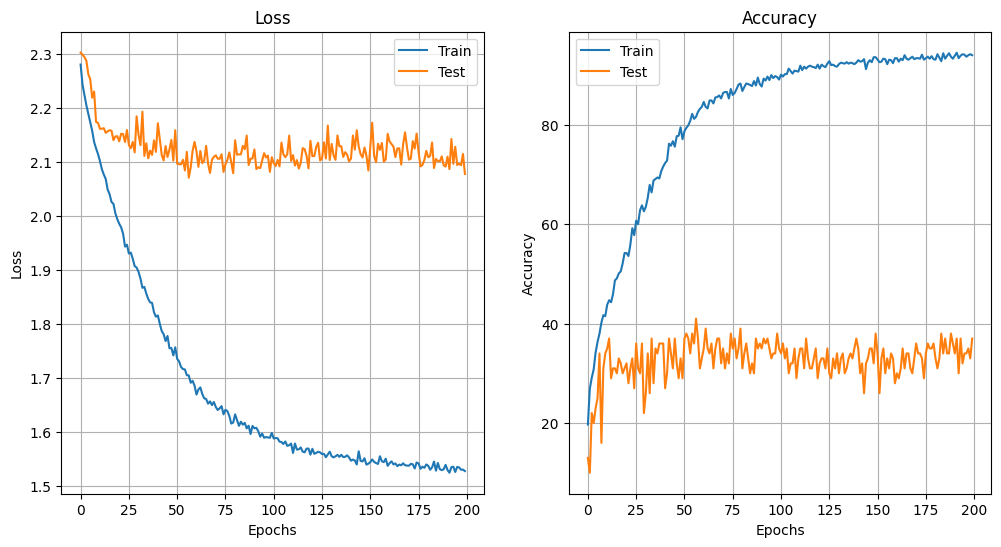

In [36]:
cnn_rms_drop_bn = CNN_Drop_BN()
rms = torch.optim.RMSprop(cnn_rms_drop_bn.parameters(), lr=0.001, alpha=0.9)
train_errors, test_errors, train_accuracies, test_accuracies = train_cnn(rms,
                                                                         cnn_rms_drop_bn,
                                                                         num_epochs=200,
                                                                         batch_size=100)
plot_error_accuracy(train_errors, test_errors, train_accuracies, test_accuracies)

| **Train Accuracy** | **Test Accuracy** |
|--------------------|-------------------|
| 94.00%             | 37.00%            |

**Observations:**
- Batch Normalization normalizes the output of the hidden layer which results in better gradients and therefore, better learning.
- The model is not able to generalize well because the number of parameters are relatively lesser compared to state of the art models.